**This notebook is used to train LSTM model on multivariate time series data and explain the model using SHAP**

**Install necessary libraries**

In [ ]:
!pip install shap

**Import necessary libraries**

In [ ]:
import shap 
import numpy as np
import pandas as pd
import tensorflow as tf
tf.compat.v1.disable_v2_behavior() 

from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tools.eval_measures import rmse
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

**Load Energy Data**

In [ ]:
energy_data = pd.read_csv('energydata.csv')
energy_data.head()

date  Appliances  lights     T1       RH_1    T2       RH_2  \
0  2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
1  2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2  2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
3  2016-01-11 17:30:00          50      40  19.89  46.066667  19.2  44.590000   
4  2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   

      T3       RH_3         T4  ...         T9   RH_9     T_out  Press_mm_hg  \
0  19.79  44.730000  19.000000  ...  17.033333  45.53  6.600000        733.5   
1  19.79  44.790000  19.000000  ...  17.066667  45.56  6.483333        733.6   
2  19.79  44.933333  18.926667  ...  17.000000  45.50  6.366667        733.7   
3  19.79  45.000000  18.890000  ...  17.000000  45.40  6.250000        733.8   
4  19.79  45.000000  18.890000  ...  17.000000  45.40  6.133333        733.9   

   RH_out  Windspeed  Visibility  Tdewpoint        rv1        rv2  
0    92.0   7.000000   63.000000        5.3  13.275433  13.275433  
1    92.0   6.666667   59.166667        5.2  18.606195  18.606195  
2    92.0   6.333333   55.333333        5.1  28.642668  28.642668  
3    92.0   6.000000   51.500000        5.0  45.410389  45.410389  
4    92.0   5.666667   47.666667        4.9  10.084097  10.084097  

[5 rows x 29 columns]

**Do necessary preprocessing**

In [ ]:
energy_data['date'] = pd.to_datetime(energy_data['date'])
energy_data_input = energy_data.drop(['date', 'lights'], axis=1)

**MinMax() scale the data**

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(energy_data_input)

**Perform train test split**

In [ ]:
n_inputs = 144
batch_size = 32
n_features =  scaled_data.shape[1]

train_data = scaled_data[:-144]
test_data = scaled_data[-144:]

**Generate Time Series Data for LSTM**

In [ ]:
train_generator = TimeseriesGenerator(train_data, train_data[:,0], length=n_inputs, batch_size=batch_size)

**Define a LSTM Model**

In [ ]:
model = Sequential()
model.add(LSTM(150, activation='relu', return_sequences = True, input_shape=(n_inputs, n_features)))
model.add(LeakyReLU(alpha=0.5))
model.add(LSTM(150, return_sequences = True))
model.add(LeakyReLU(alpha=0.5))
model.add(Dropout(0.3))
model.add(LSTM(65, return_sequences = False))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss=tf.keras.metrics.mean_squared_error, metrics=['mae'])
model.fit_generator(train_generator,epochs= 50)

**shap.force_plot()**

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


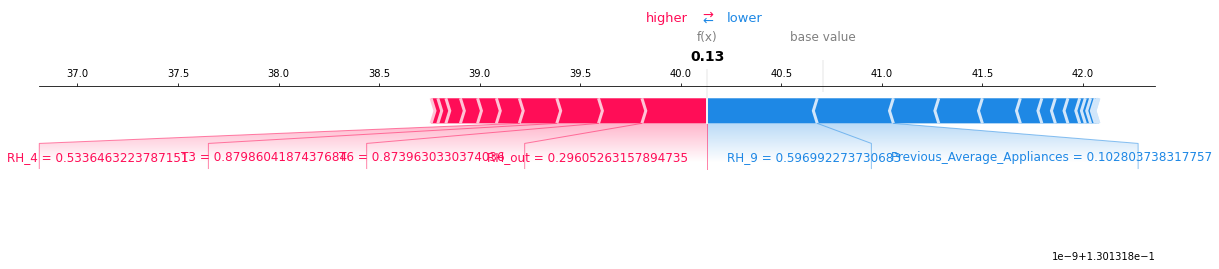

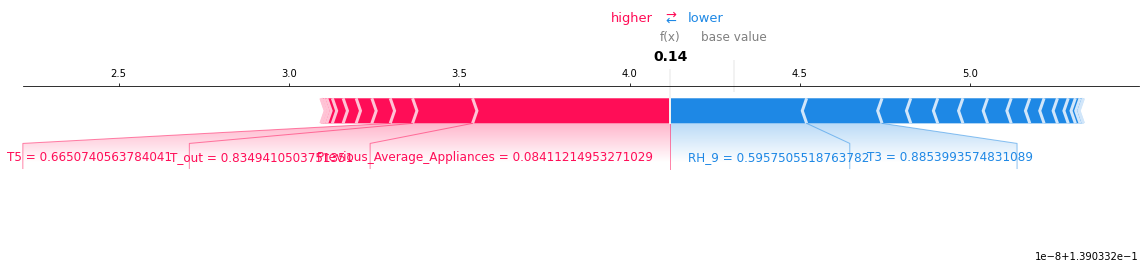

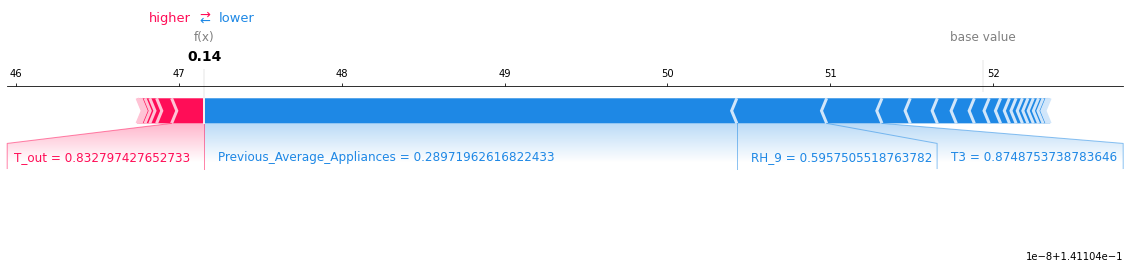

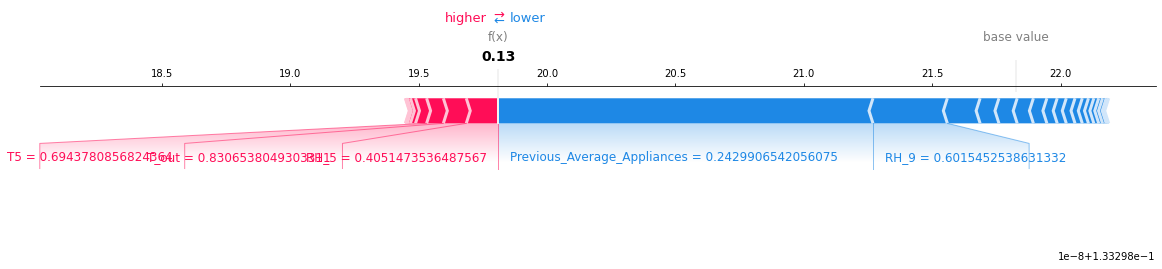

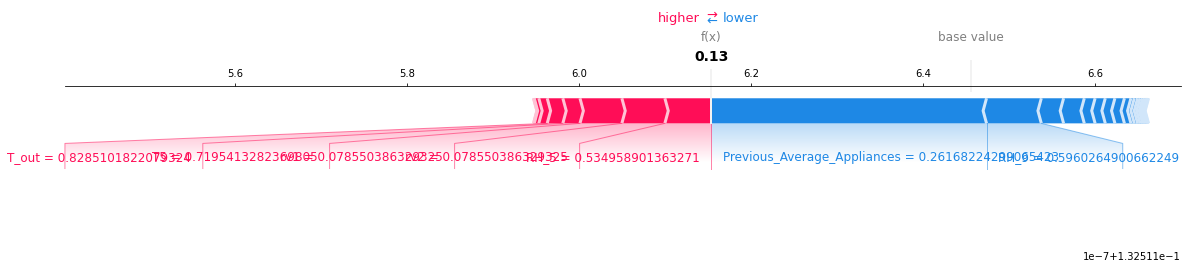

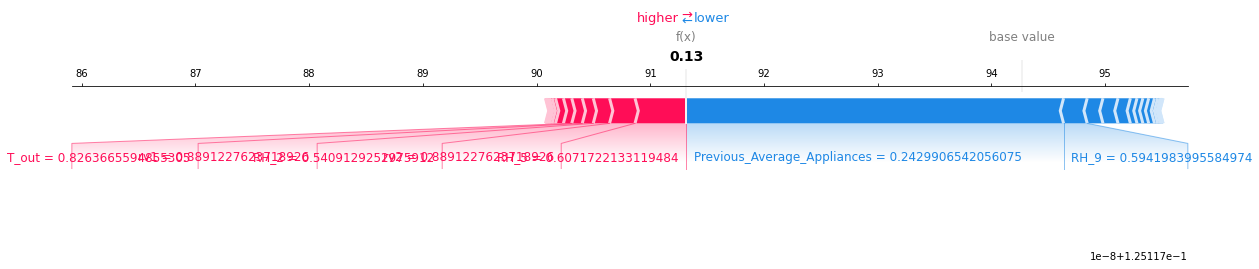

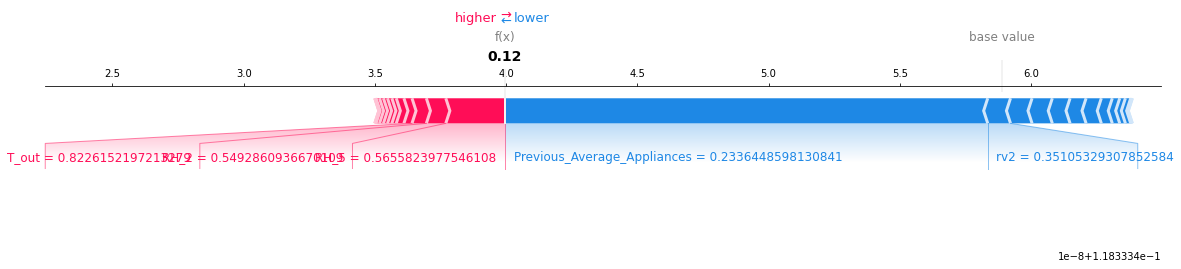

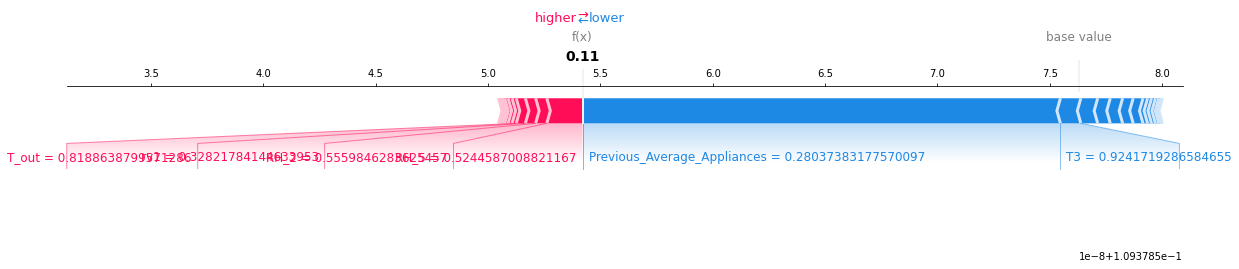

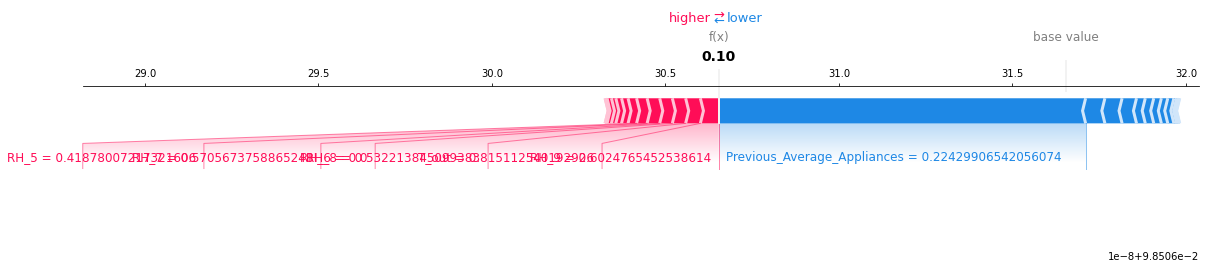

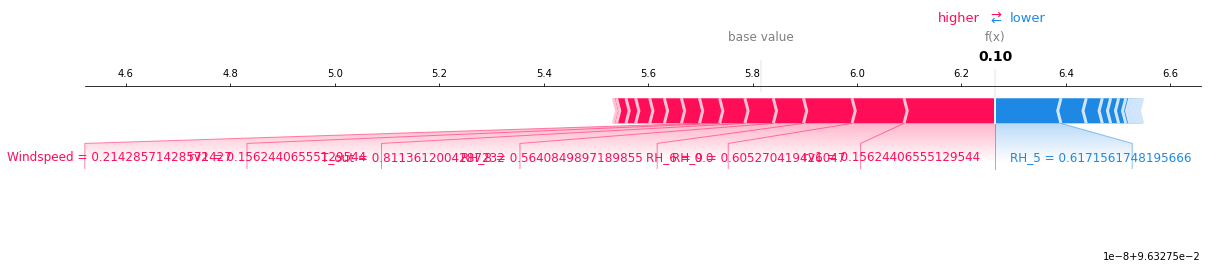

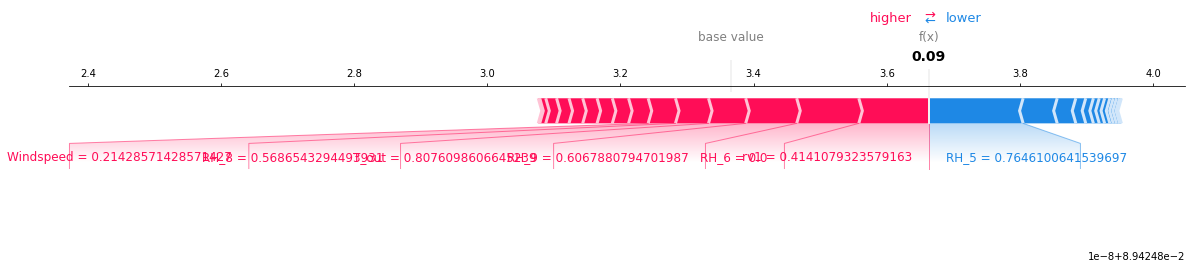

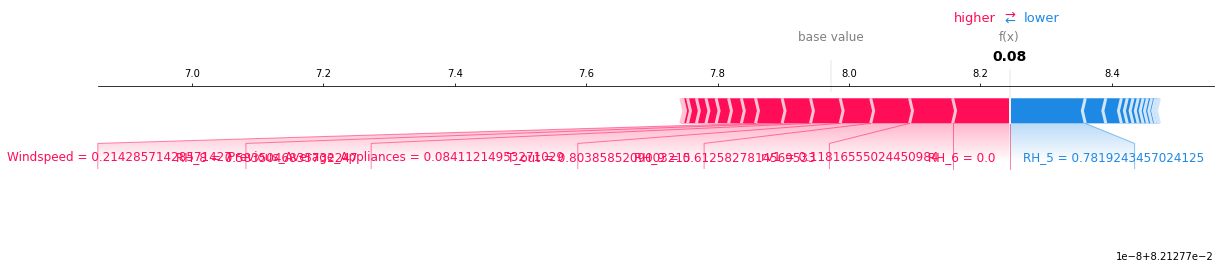

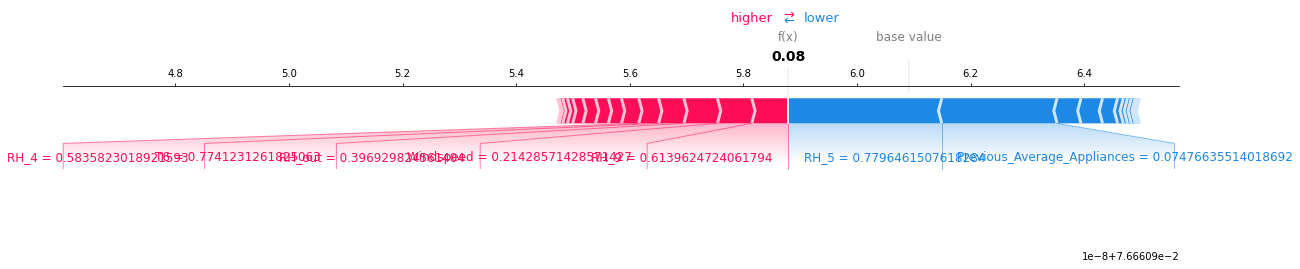

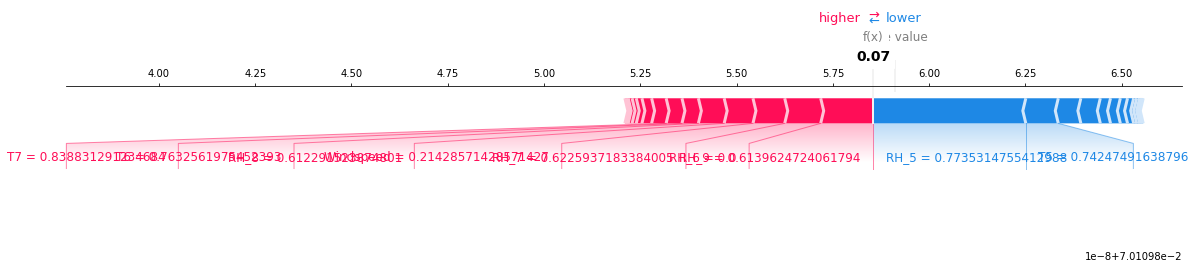

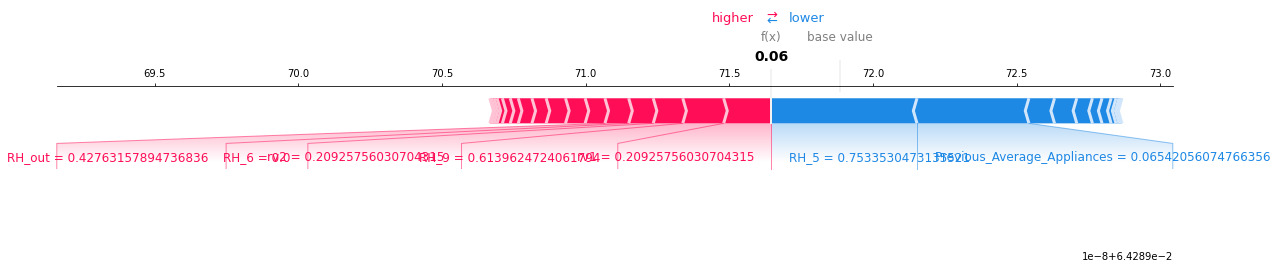

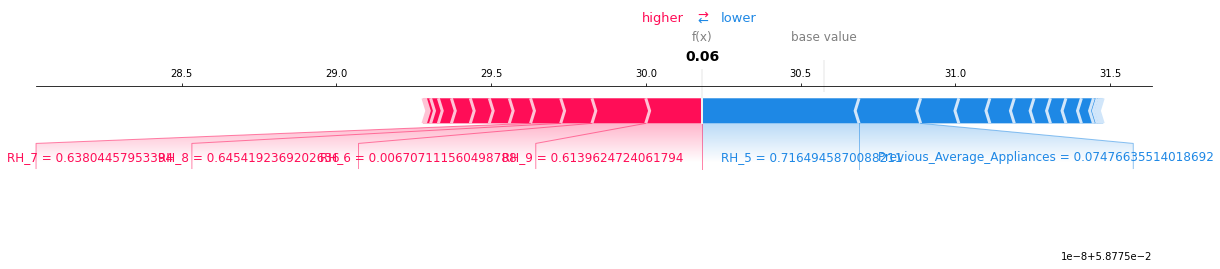

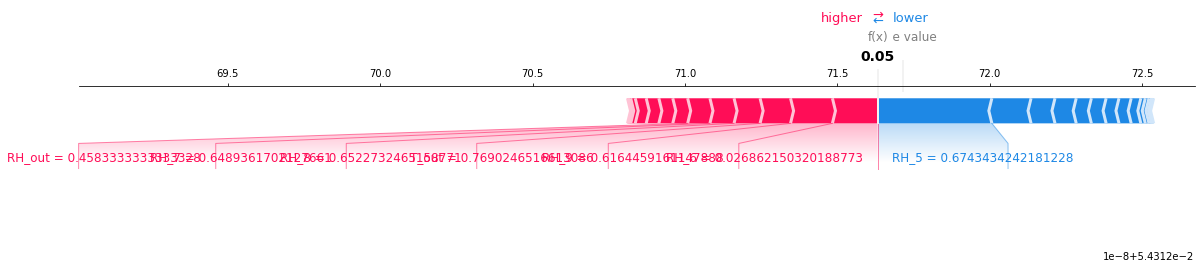

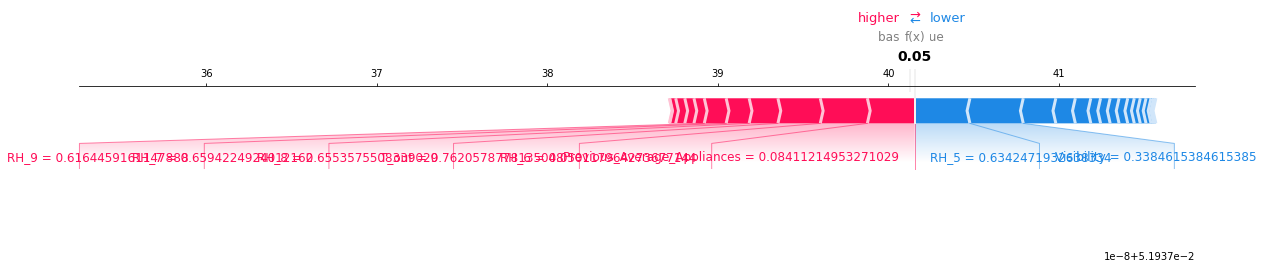

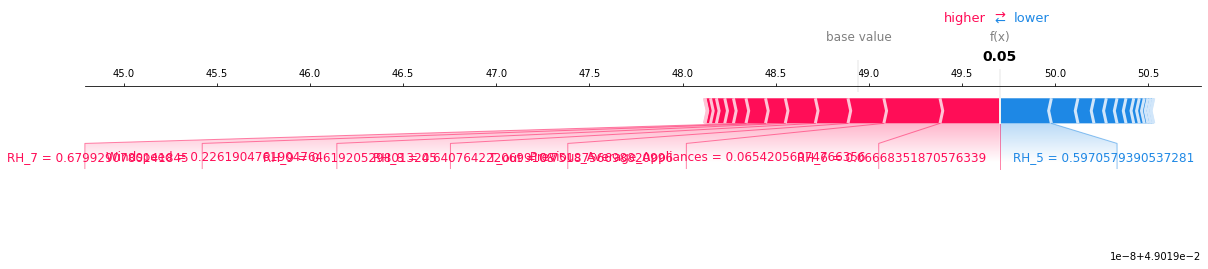

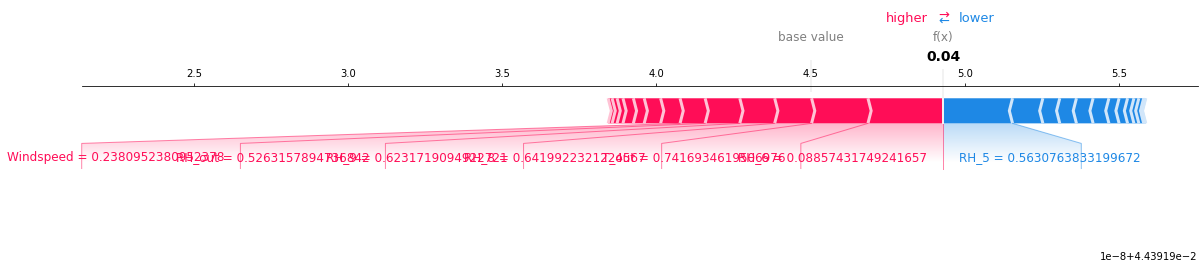

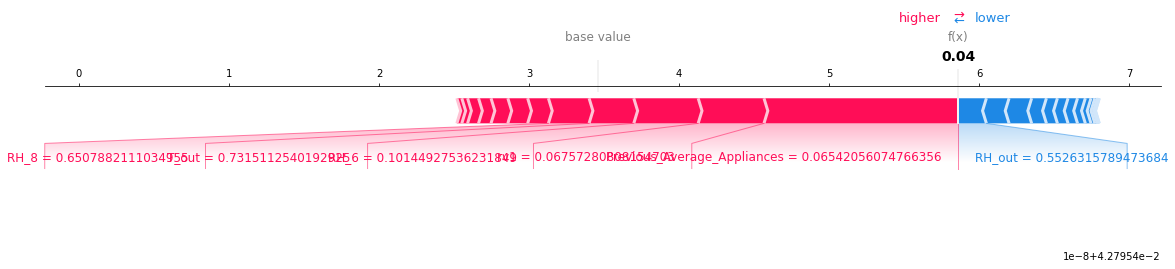

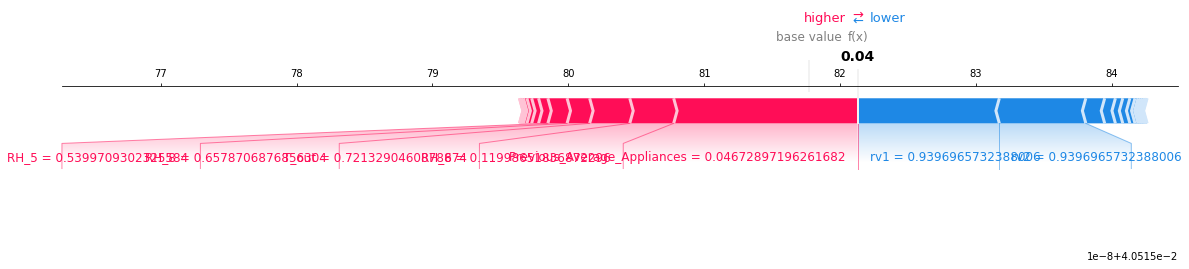

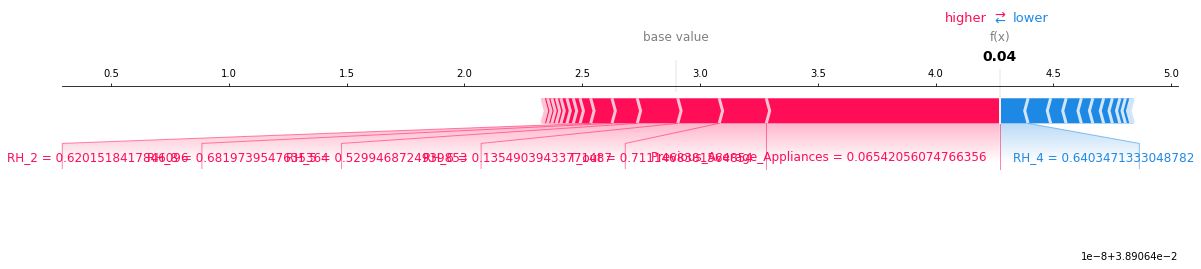

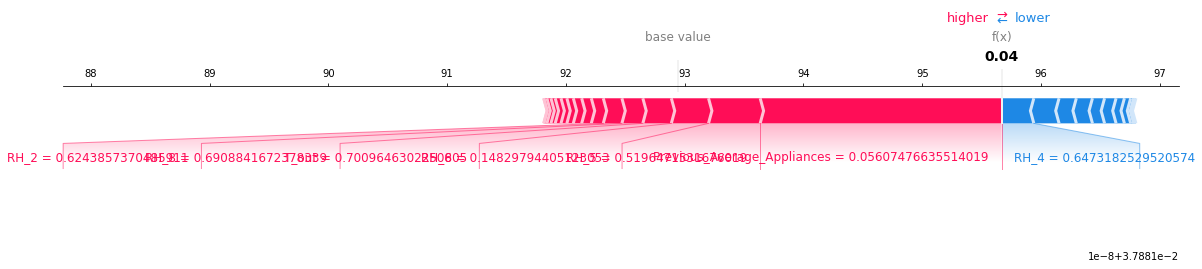

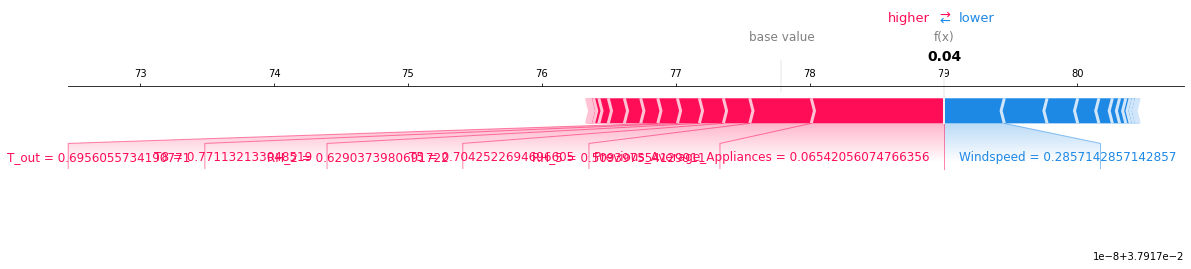

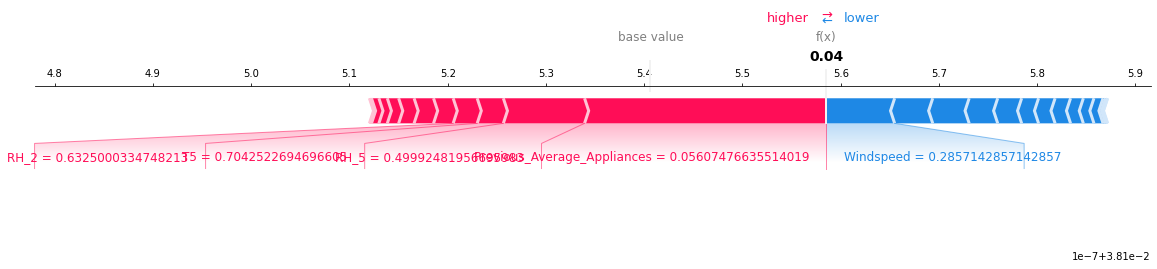

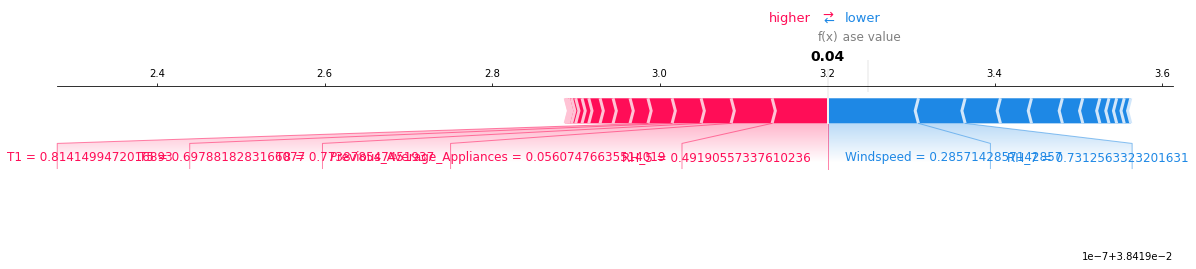

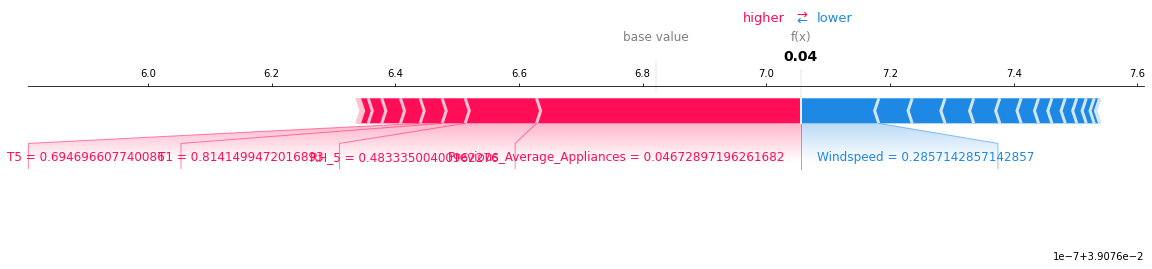

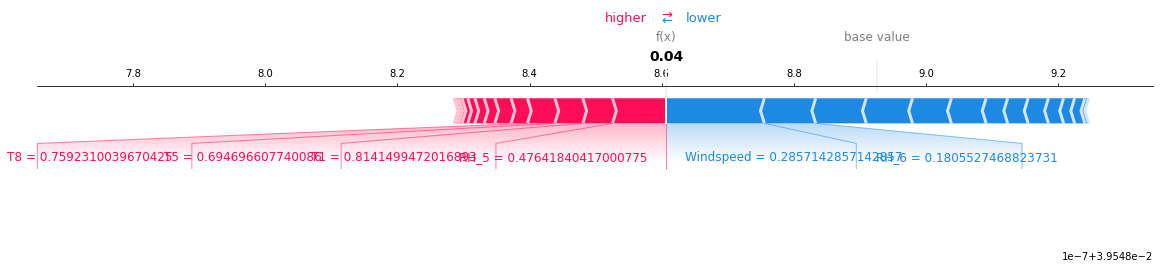

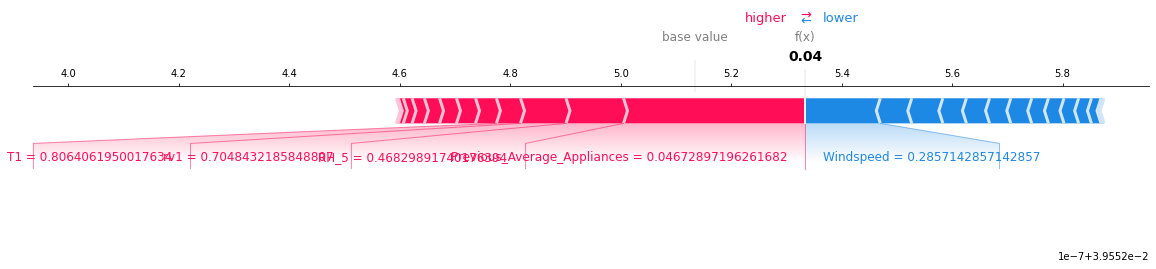

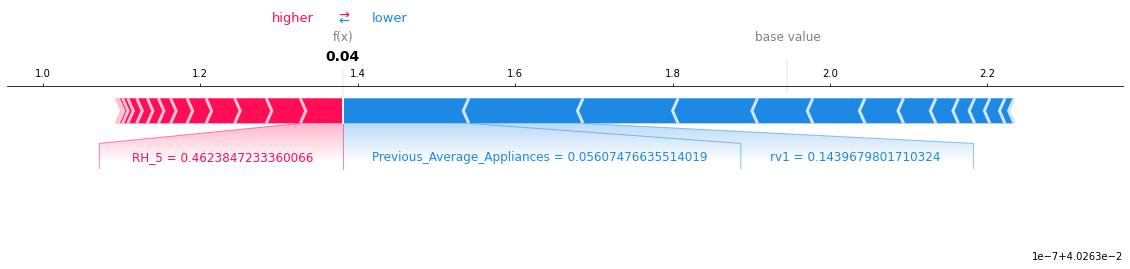

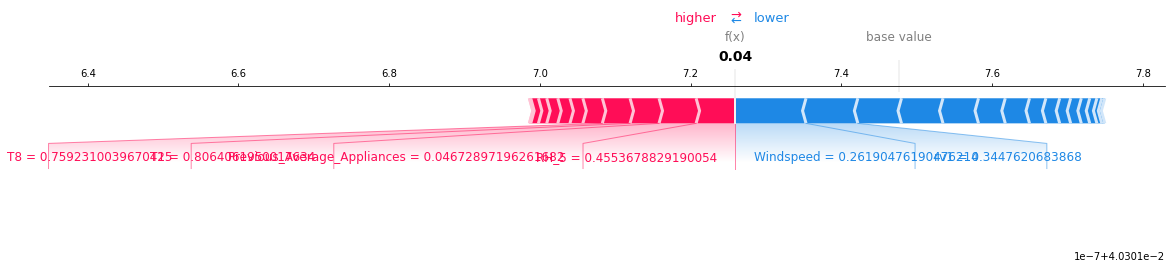

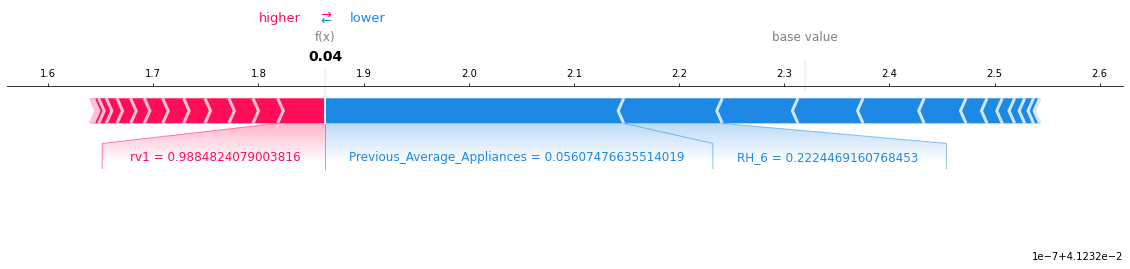

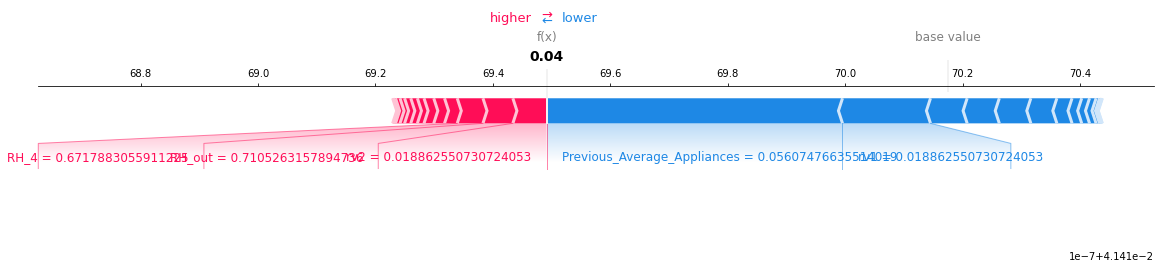

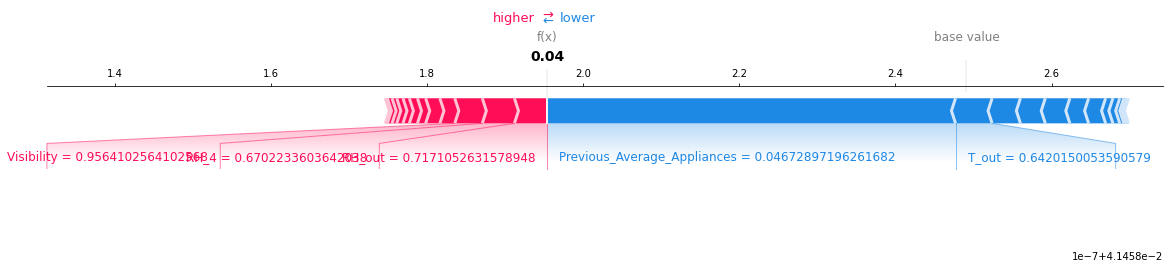

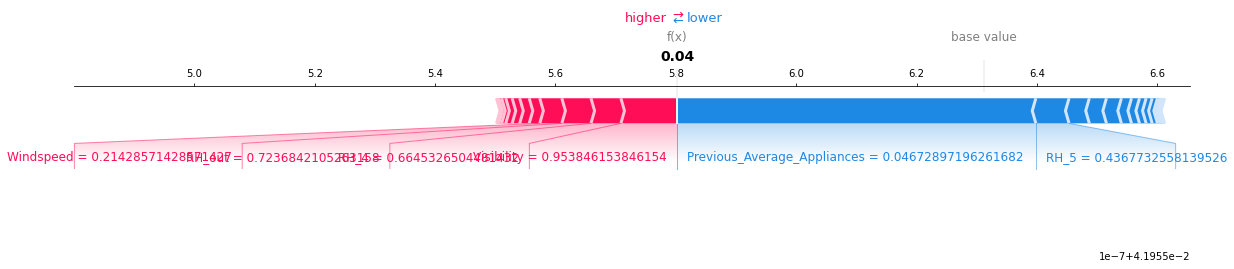

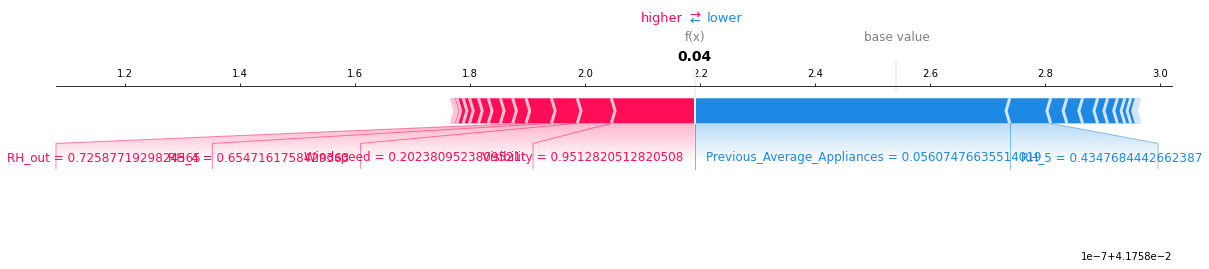

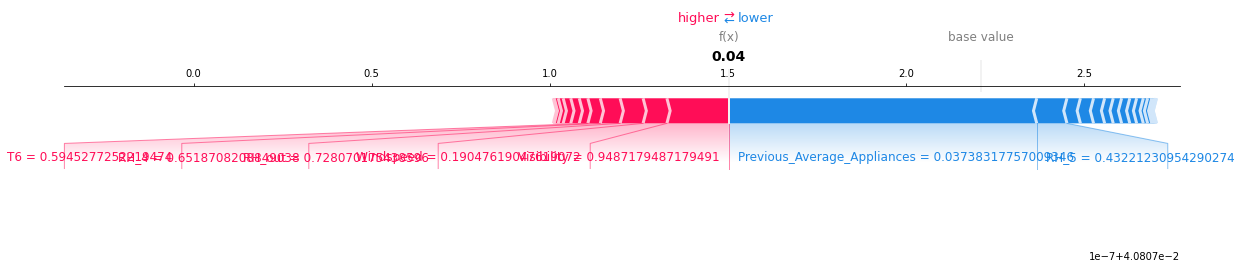

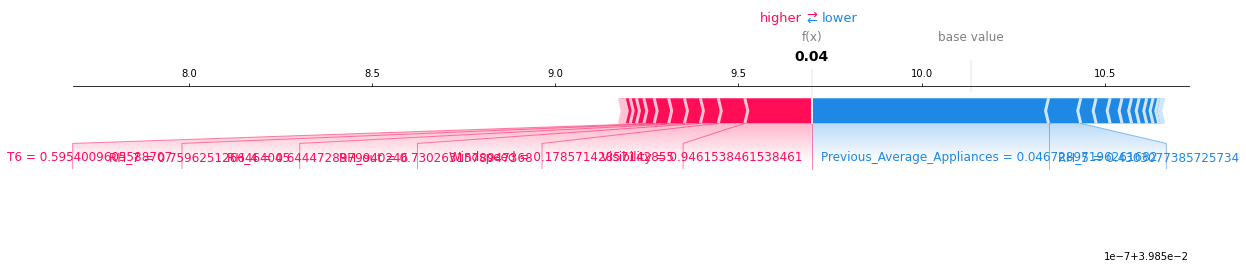

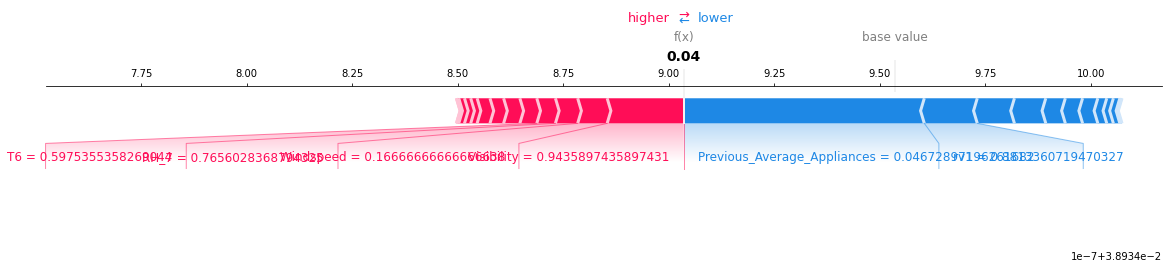

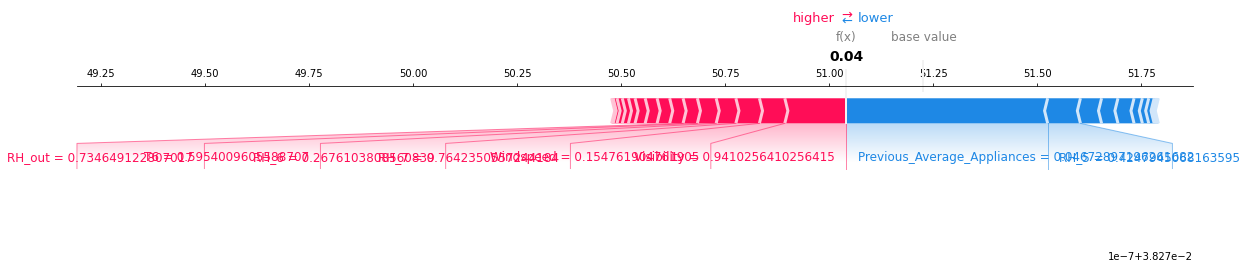

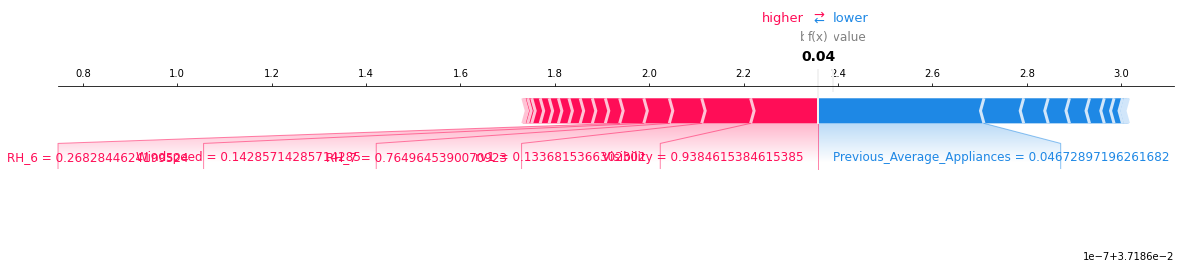

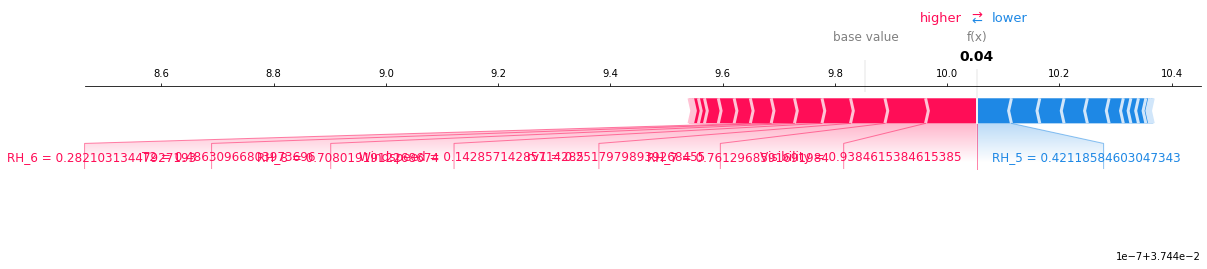

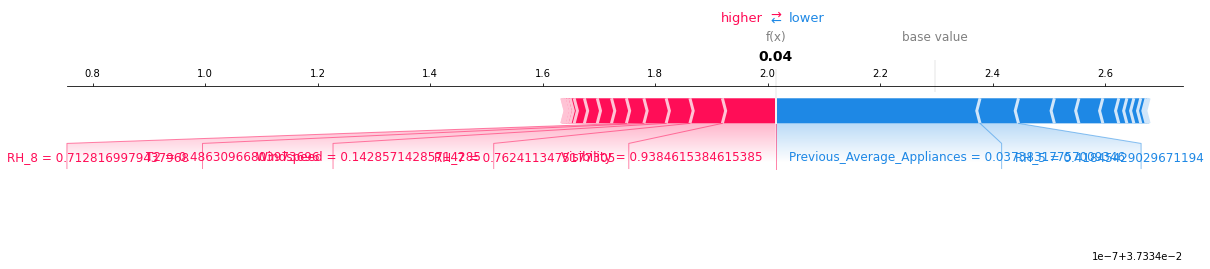

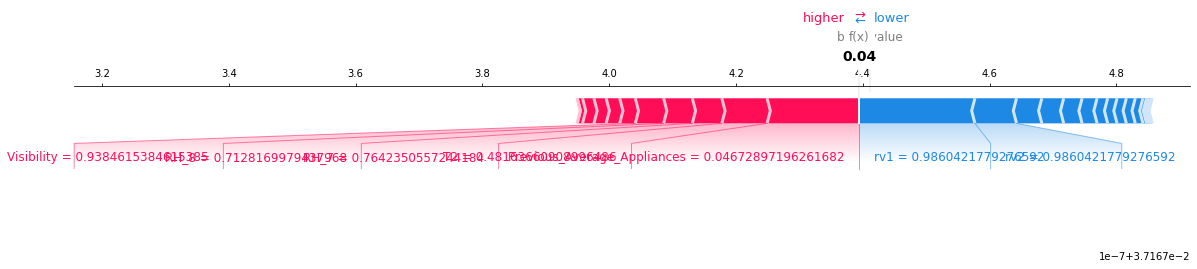

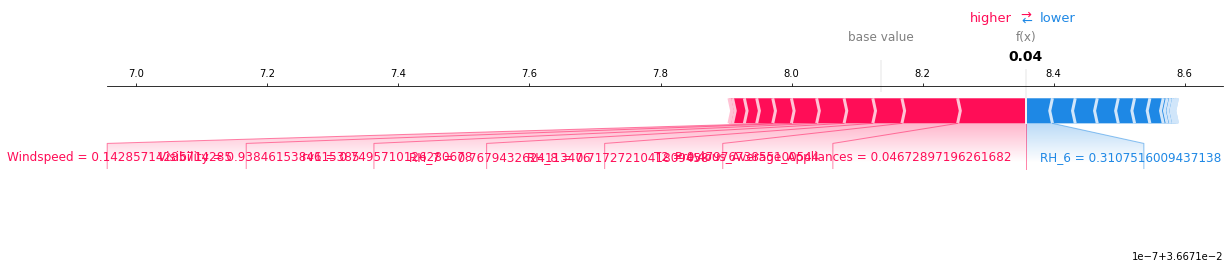

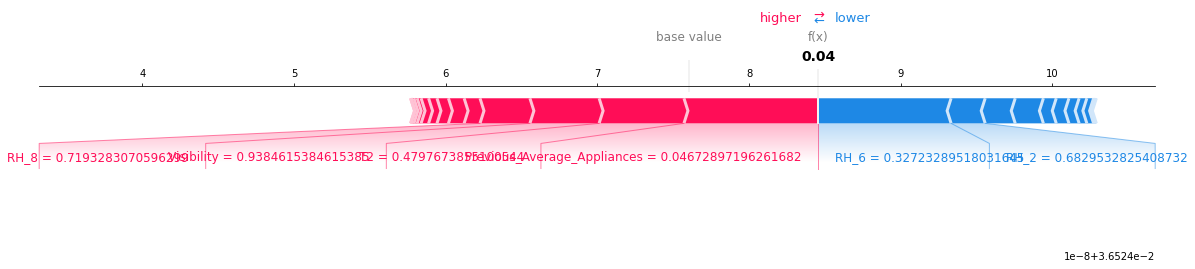

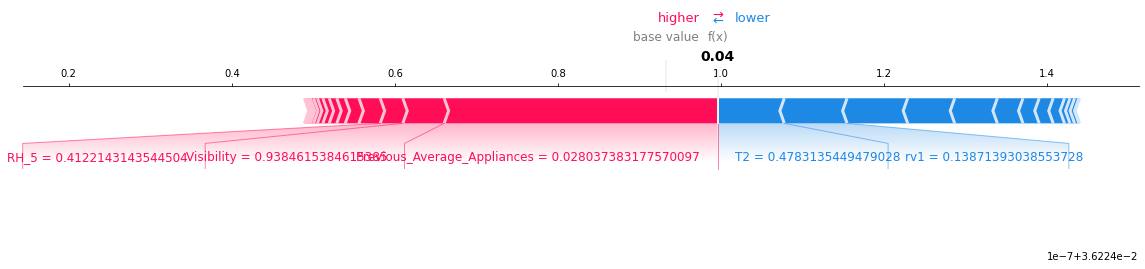

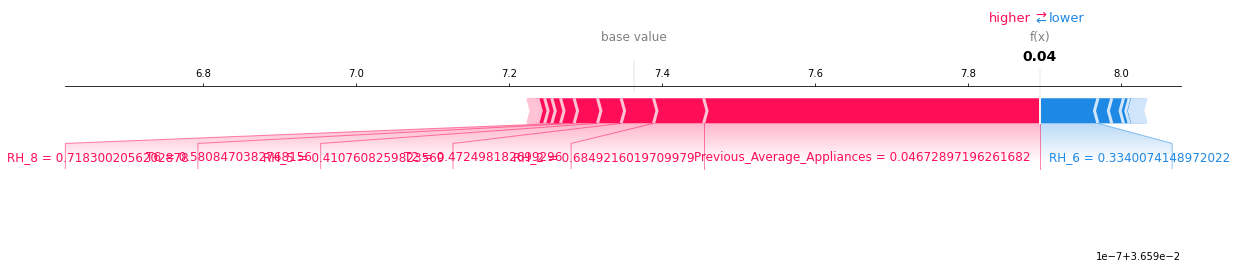

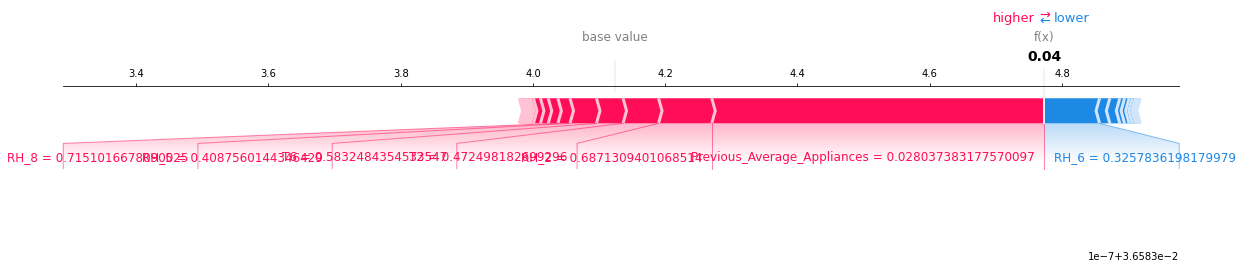

In [ ]:
predictions = []
features = ['Previous_Average_Appliances', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2']

inference_data = np.concatenate((train_data[-n_inputs:], test_data[:n_inputs]))

for i in range(n_inputs):
    sum_value = 0
    for j in range(i-n_inputs, i):
        sum_value = sum_value + inference_data[:, 0][j]
    average_value = sum_value/n_inputs
    inference_data[:, 0][i] = average_value

train_batch = inference_data[:n_inputs].reshape((1, n_inputs, n_features))
test_batch = inference_data[-n_inputs:]

new_shap_values = []

for i in range(n_inputs):
    explainer = shap.DeepExplainer(model, train_batch) 
    shap_values = explainer.shap_values(test_batch[:n_inputs].reshape((1, n_inputs, n_features)), check_additivity=False) 
    new_shap_values.append(shap_values[0][0][i].tolist())
    shap.force_plot(explainer.expected_value, shap_values[0][0][i], test_batch[i], features, matplotlib=True)
    predictions.append(explainer.expected_value)
    test_batch[i][0] = predictions[i]  
    train_batch = np.append(train_batch[0][1:],(test_batch[i]))
    train_batch = train_batch.reshape((1, n_inputs, n_features)) 
    
new_shap_values = np.array(new_shap_values)   

**shap.summary_plot()**

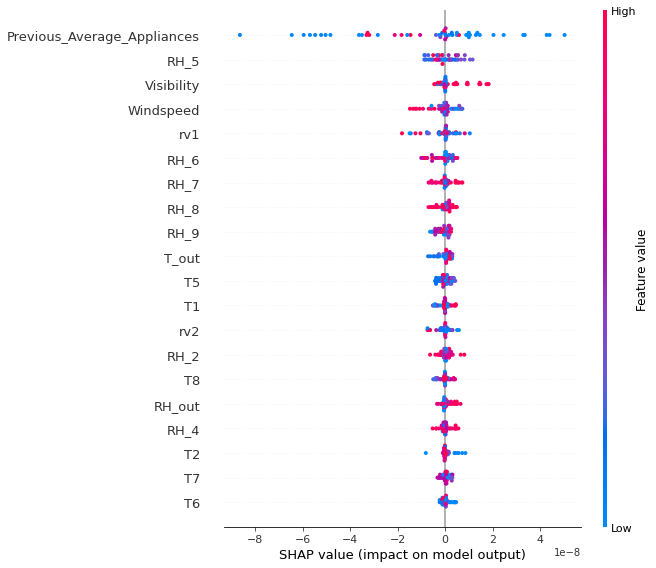

None

In [ ]:
summary_dot_plot = shap.summary_plot(new_shap_values, inference_data[-n_inputs:], features, color=new_shap_values) 
display(summary_dot_plot)

None

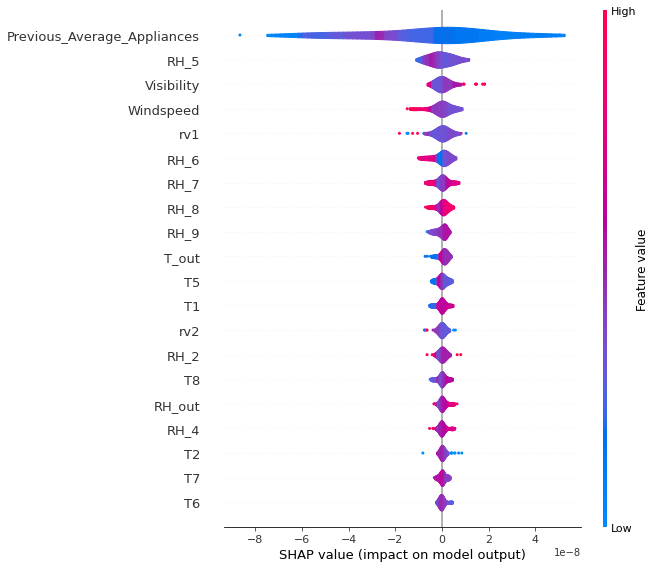

In [ ]:
summary_violin_plot = shap.summary_plot(new_shap_values, inference_data[-n_inputs:], features, plot_type='violin', show = False) 
display(summary_violin_plot)

None

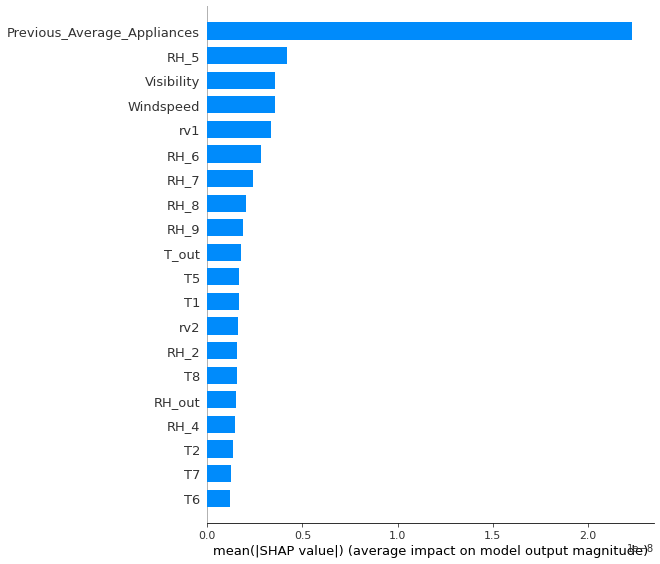

In [ ]:
summary_bar_plot = shap.summary_plot(new_shap_values, inference_data[-n_inputs:], features, plot_type='bar', show = False) 
display(summary_bar_plot)

**shap.dependence_plot()**

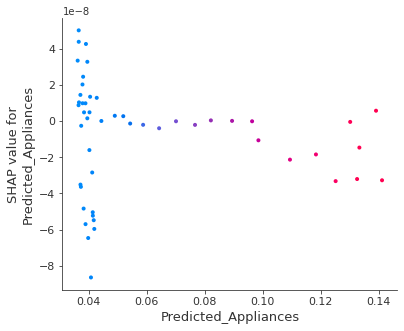

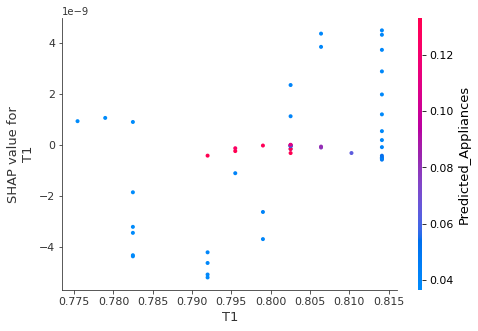

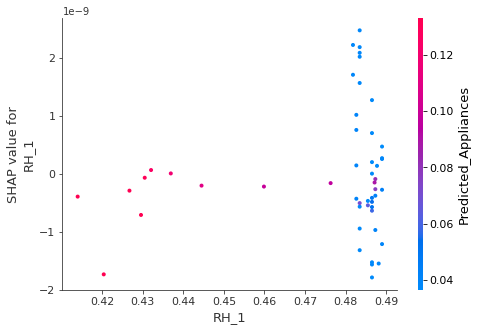

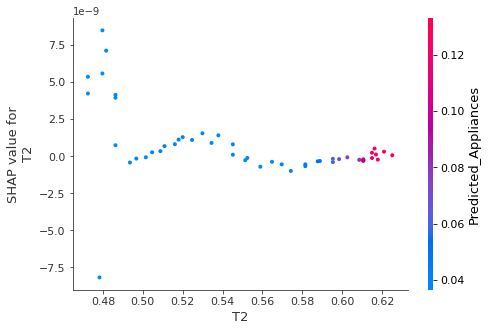

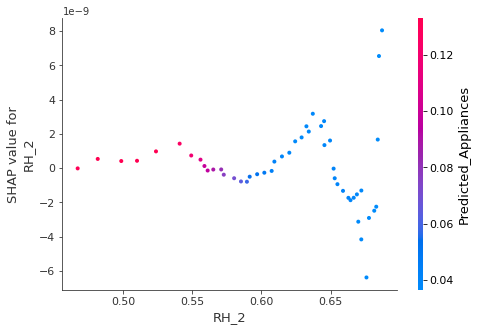

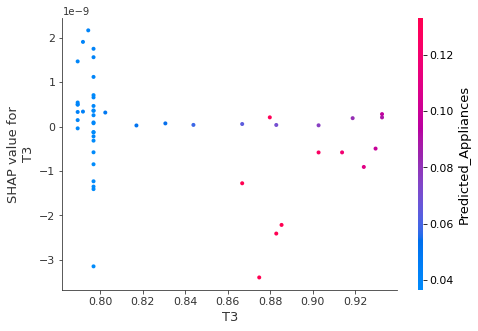

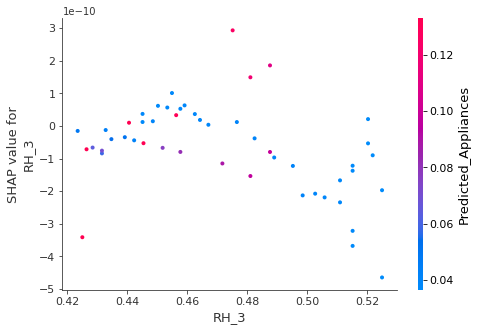

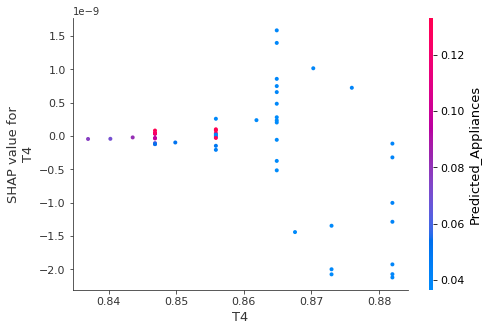

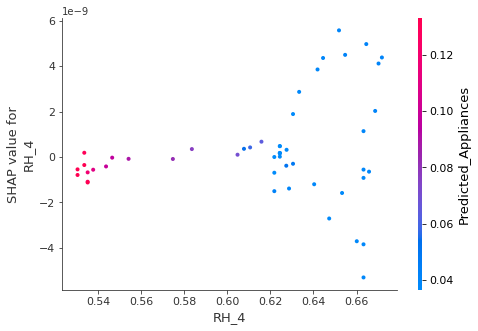

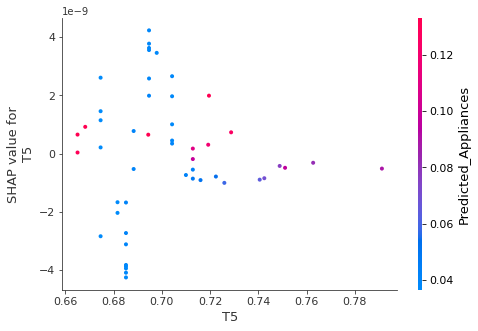

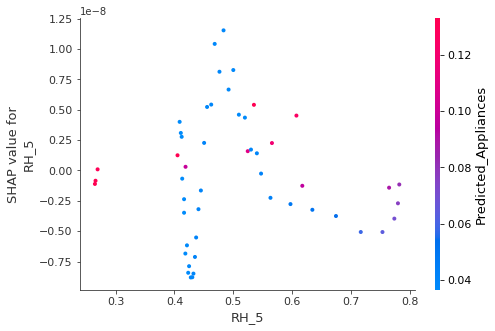

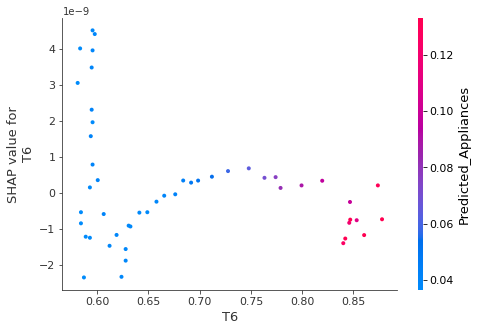

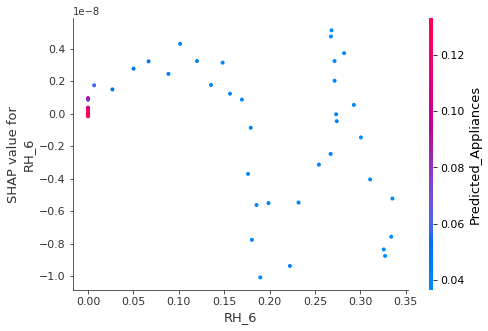

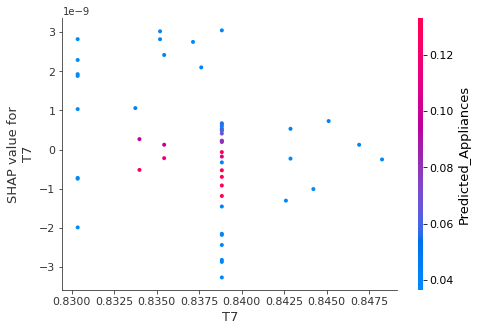

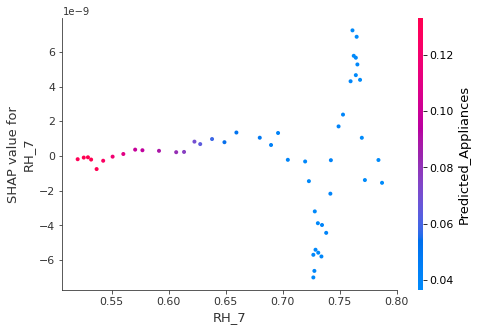

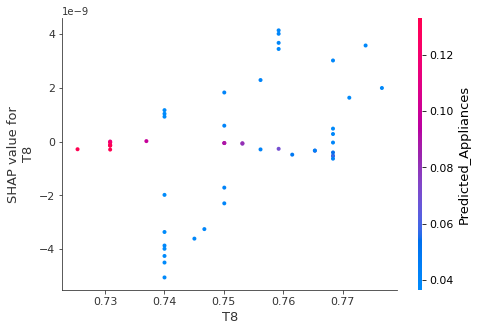

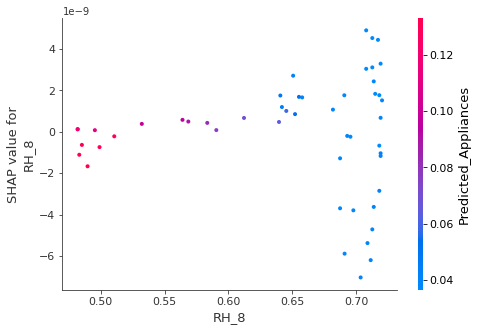

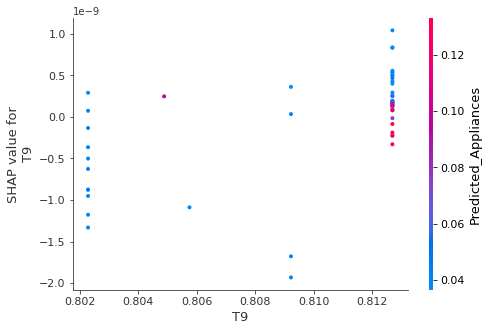

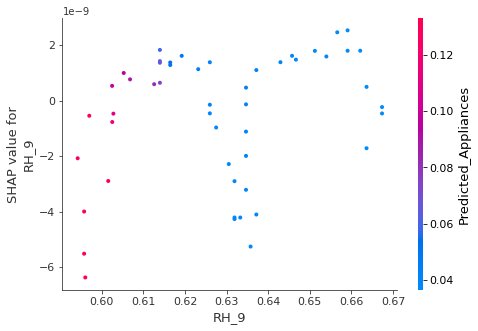

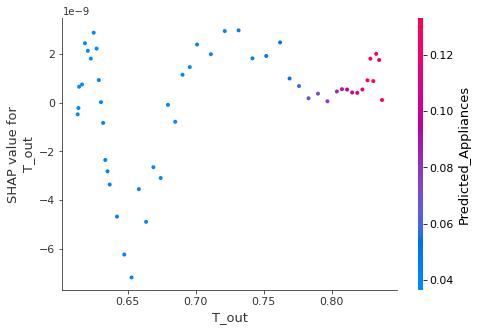

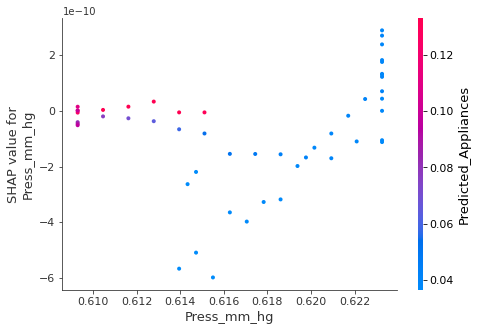

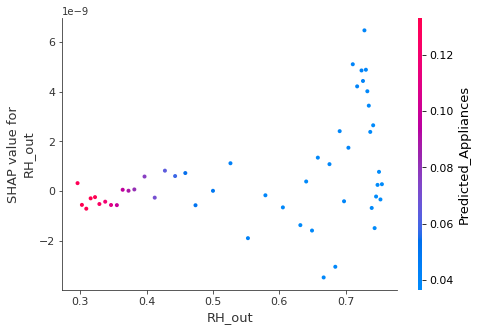

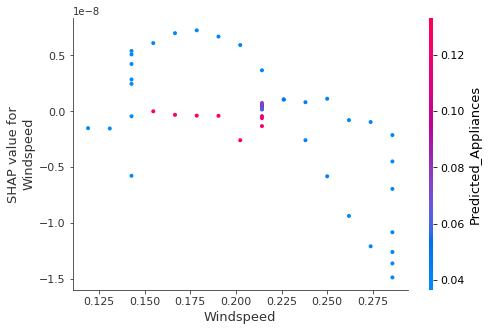

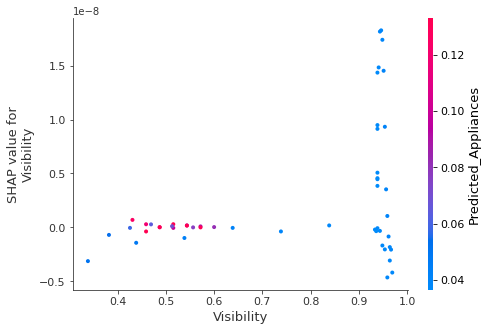

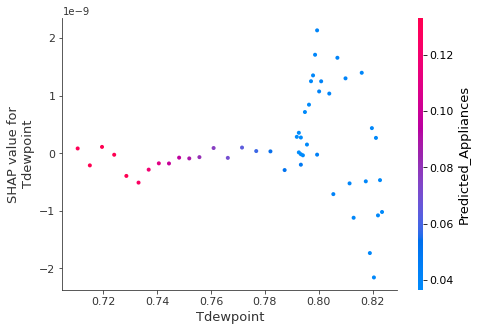

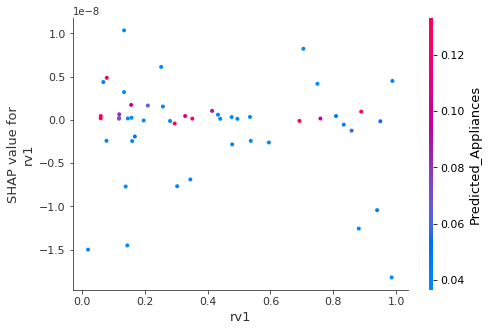

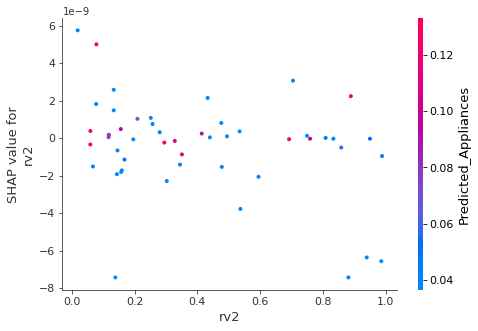

In [ ]:
features = ['Predicted_Appliances', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2']

for feature in features:
    shap.dependence_plot(feature, new_shap_values, test_batch[-n_inputs:], feature_names = features, interaction_index = "Predicted_Appliances") 

**shap.decision_plot()**

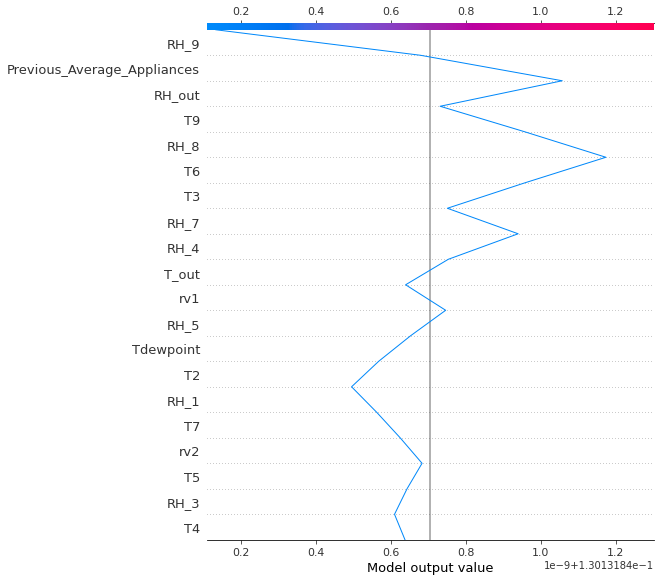

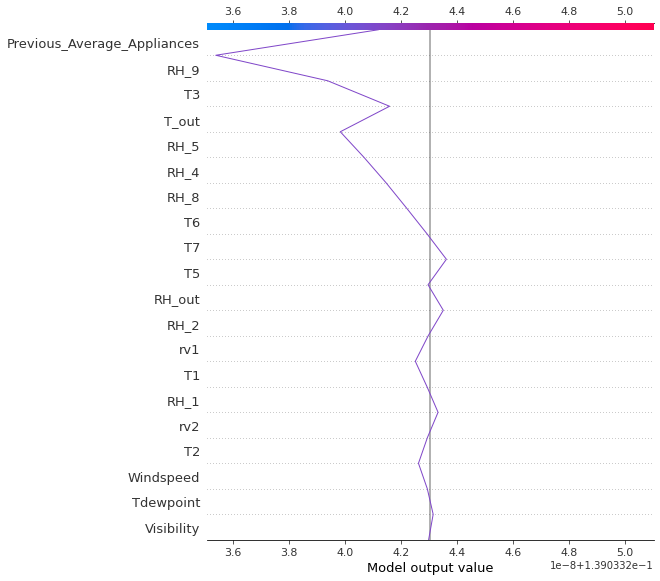

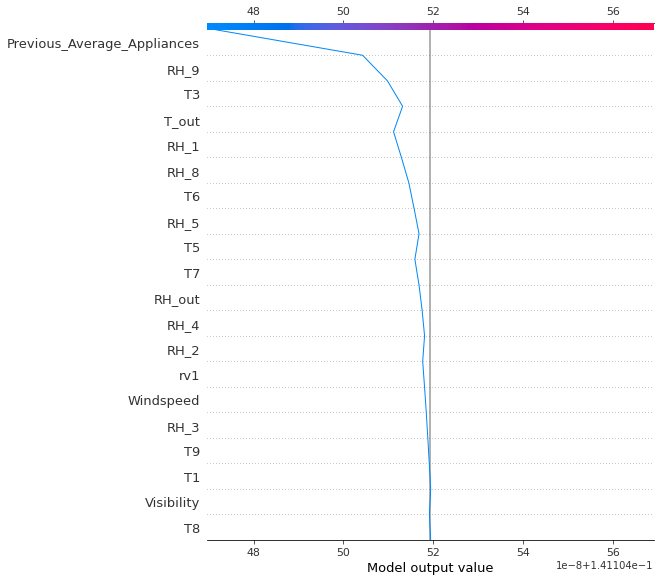

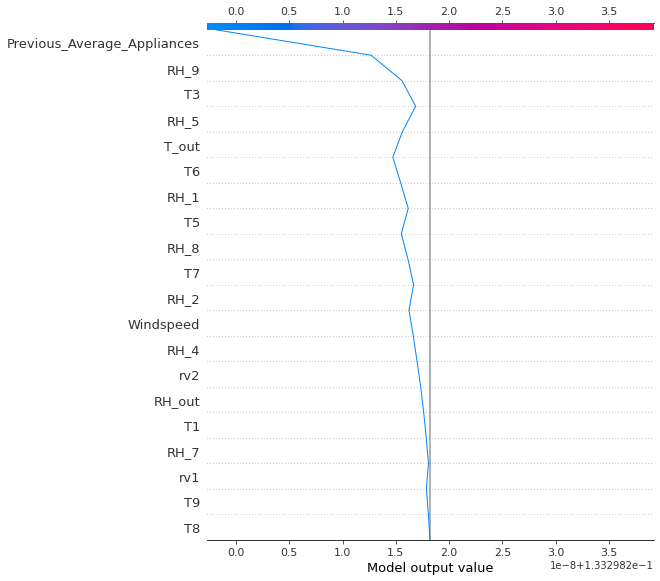

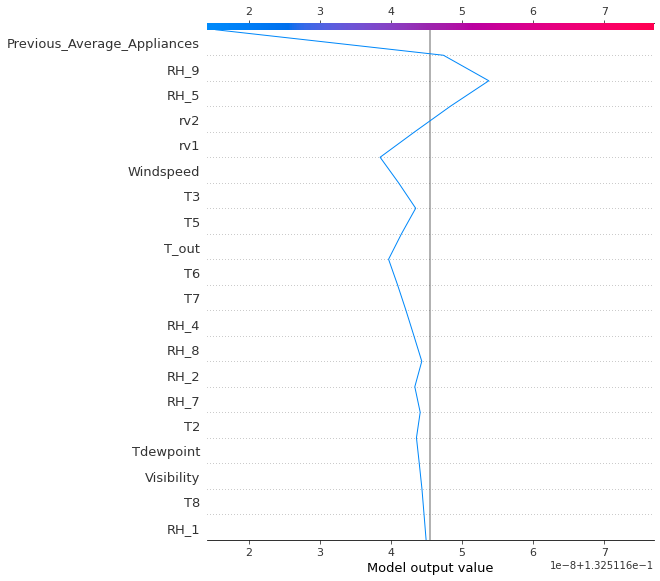

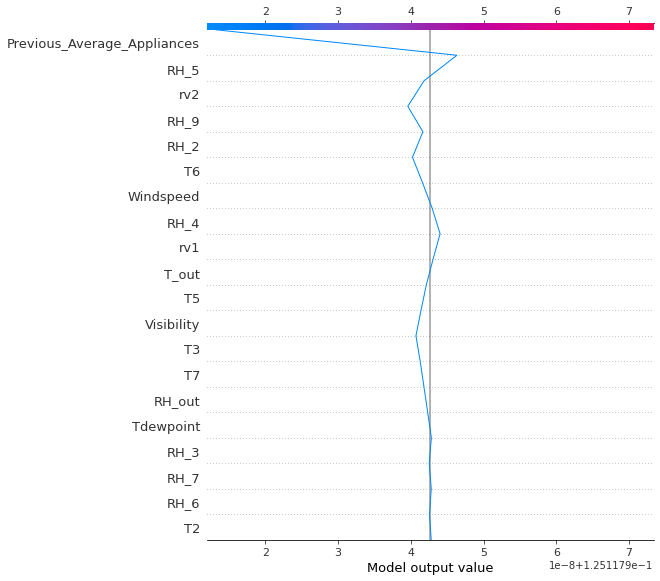

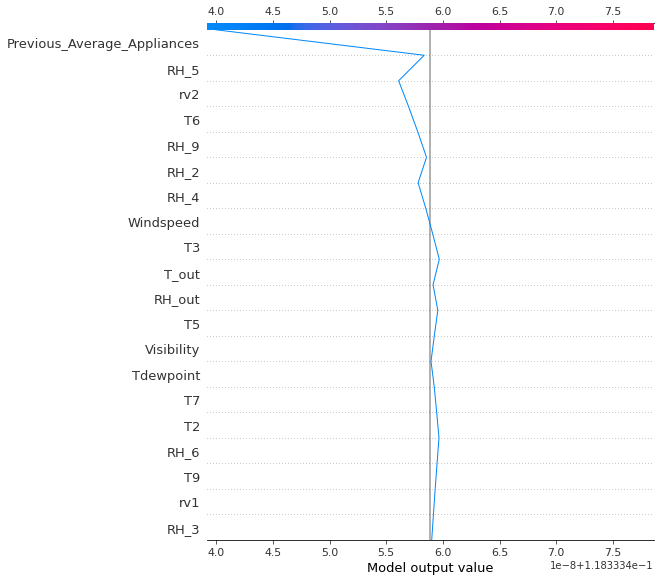

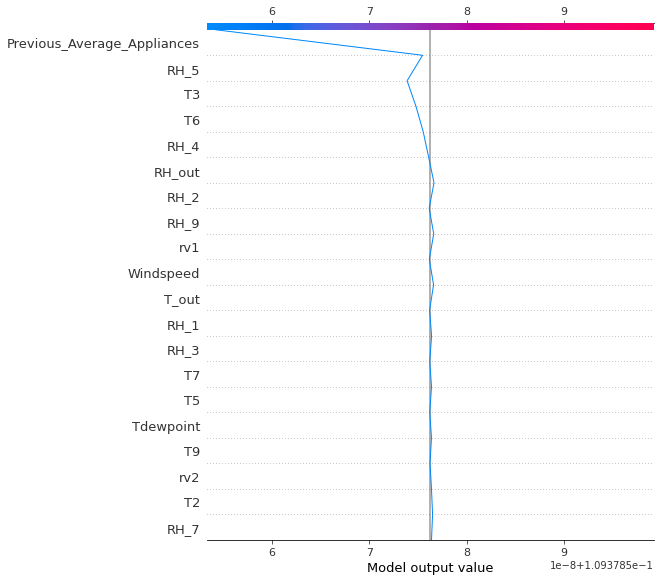

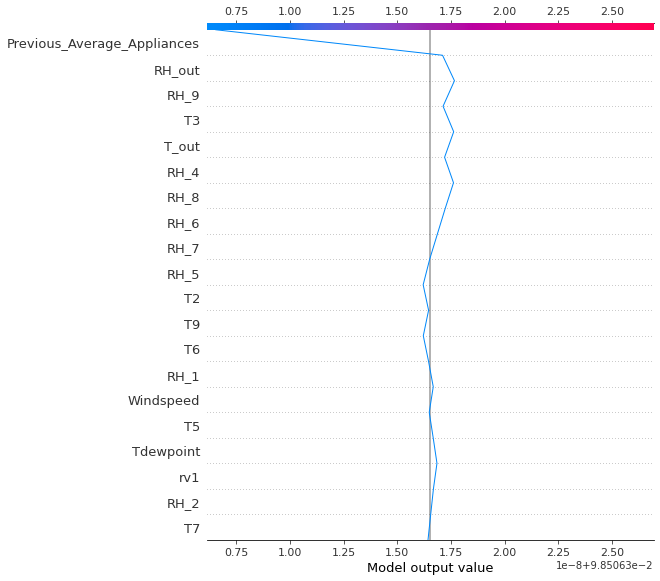

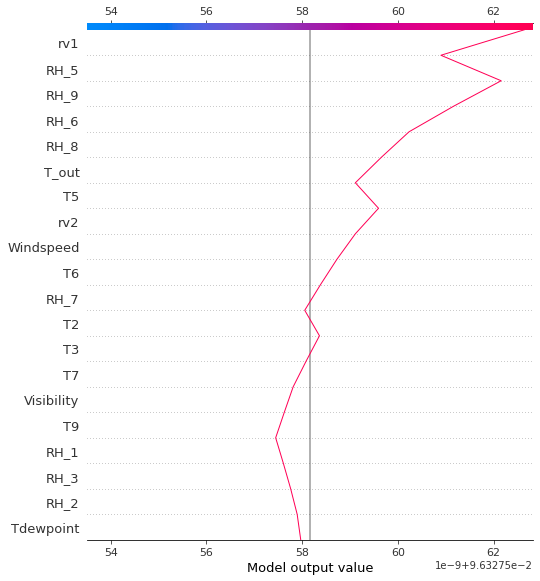

In [ ]:

features = ['Previous_Average_Appliances', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2']
for i in range(10):
    shap.decision_plot(predictions[i], new_shap_values[i], features)

**shap.embedding_plot()**

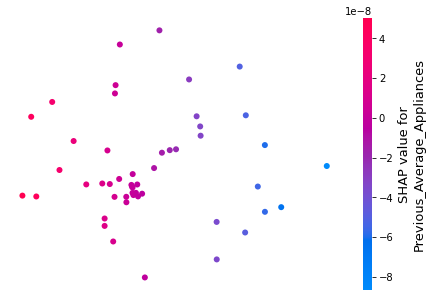

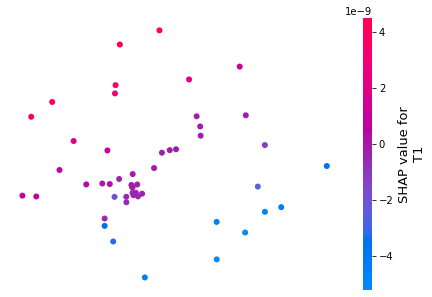

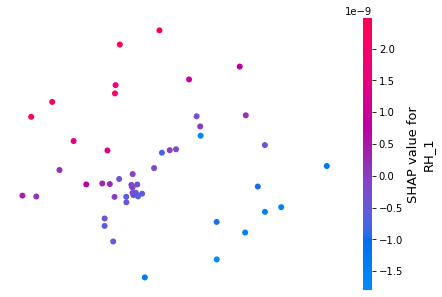

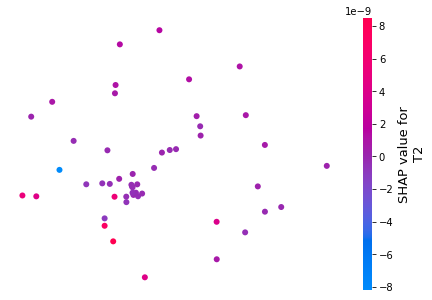

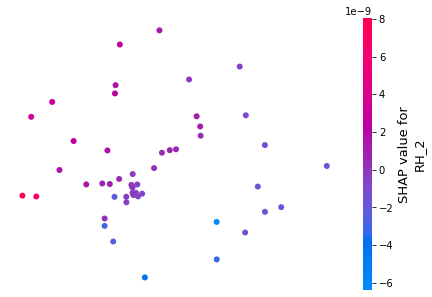

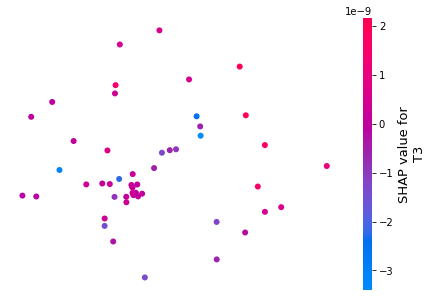

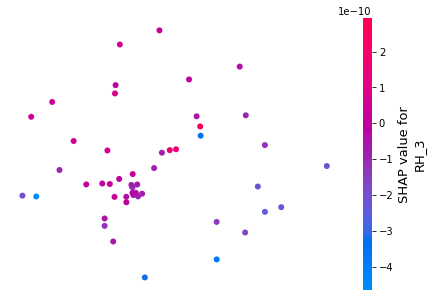

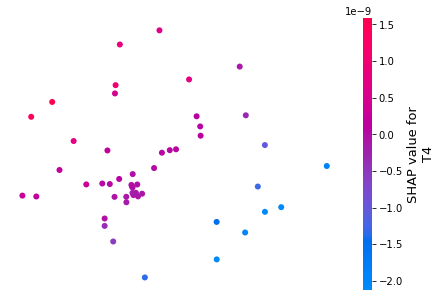

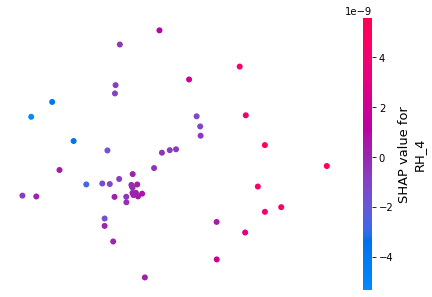

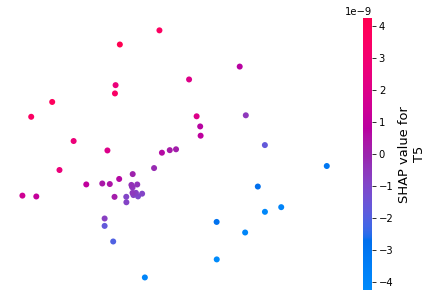

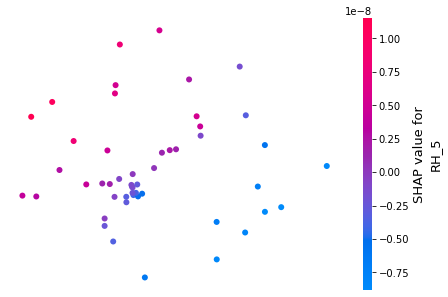

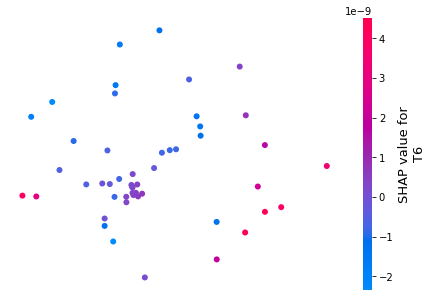

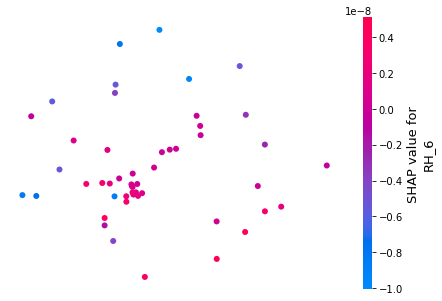

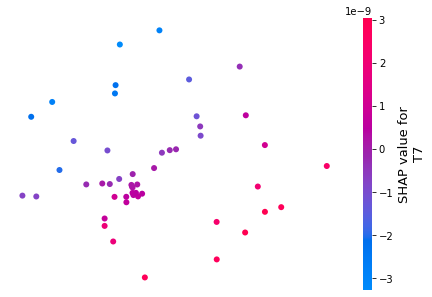

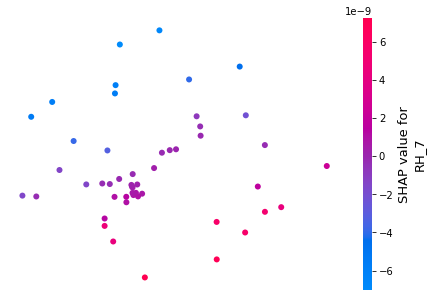

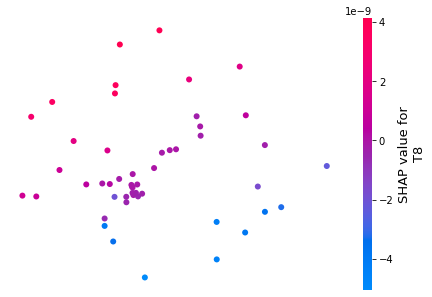

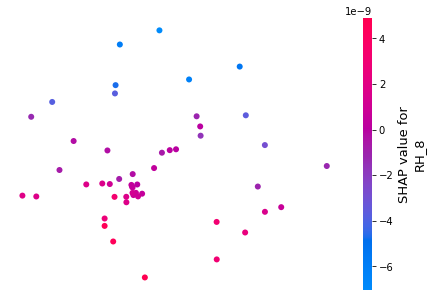

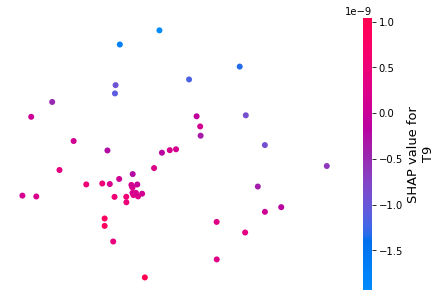

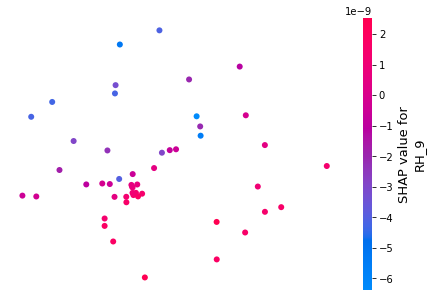

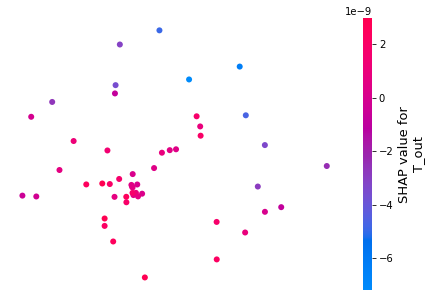

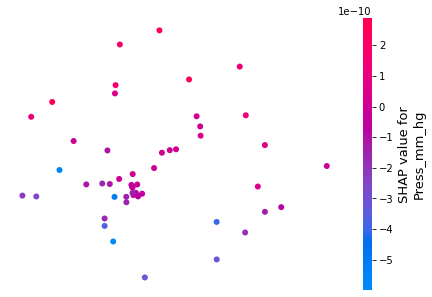

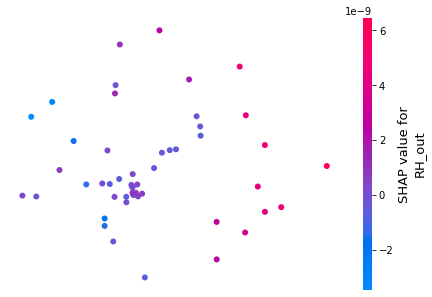

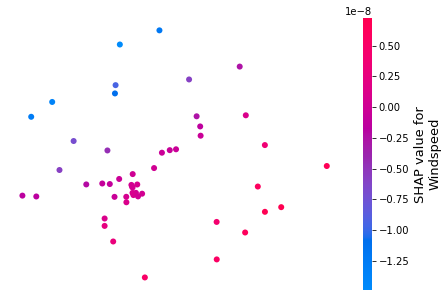

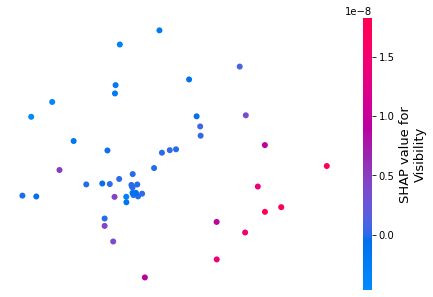

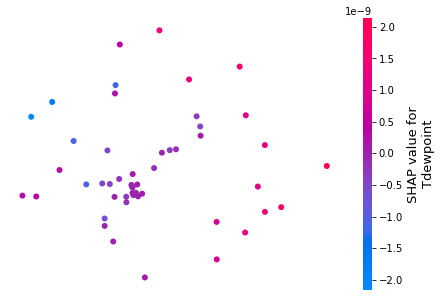

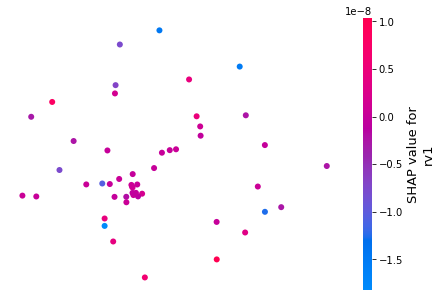

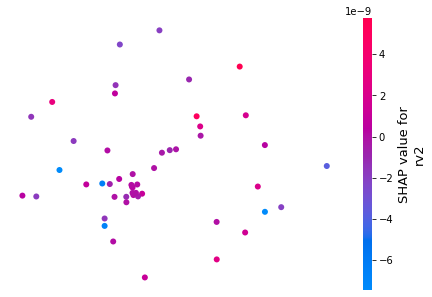

In [ ]:
features = ['Previous_Average_Appliances', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2']
for feature in features:
    shap.embedding_plot(feature, new_shap_values, feature_names = features) 

**shap.bar_plot()**

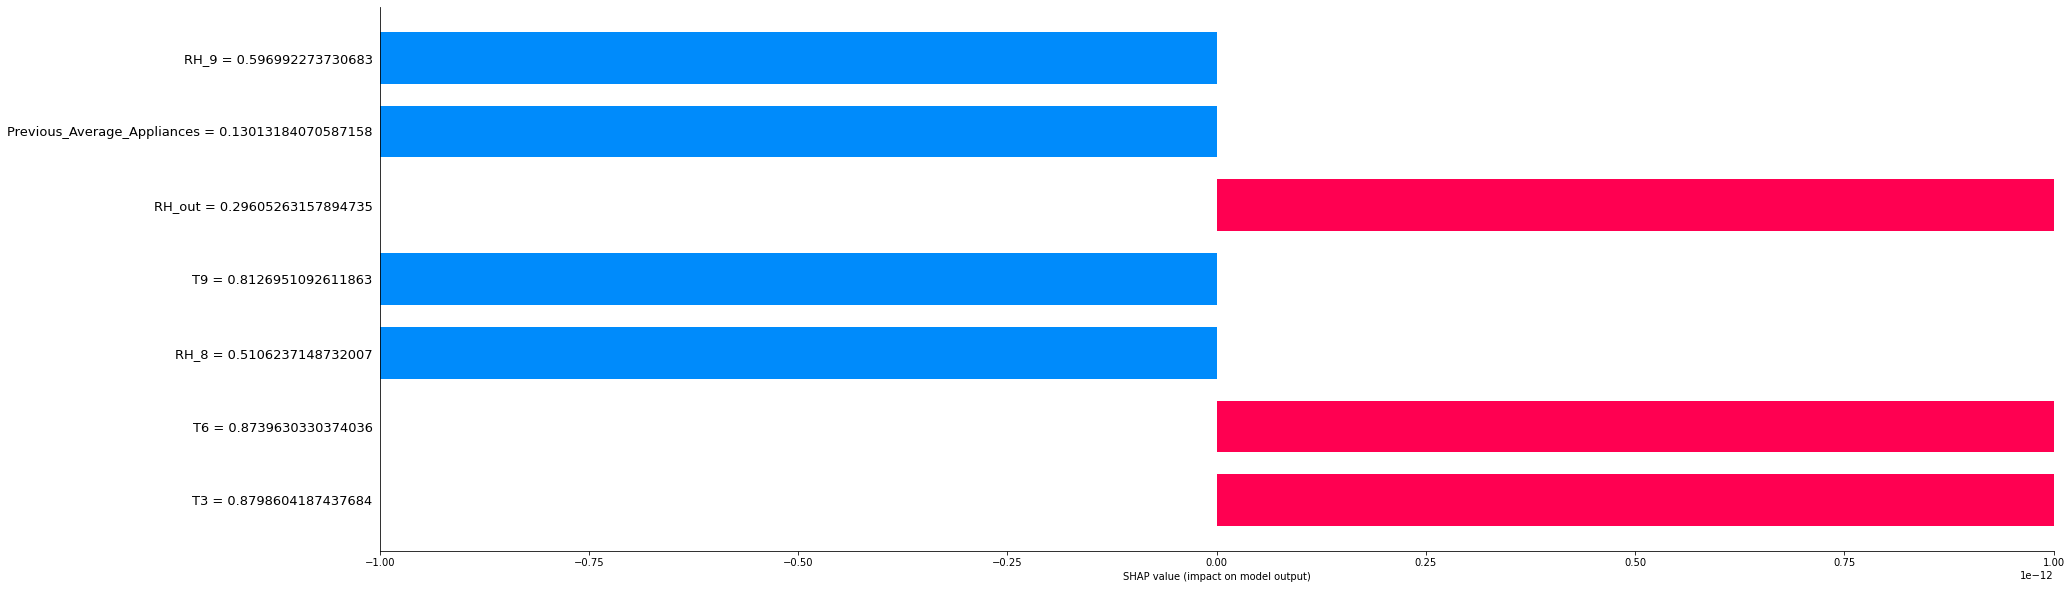

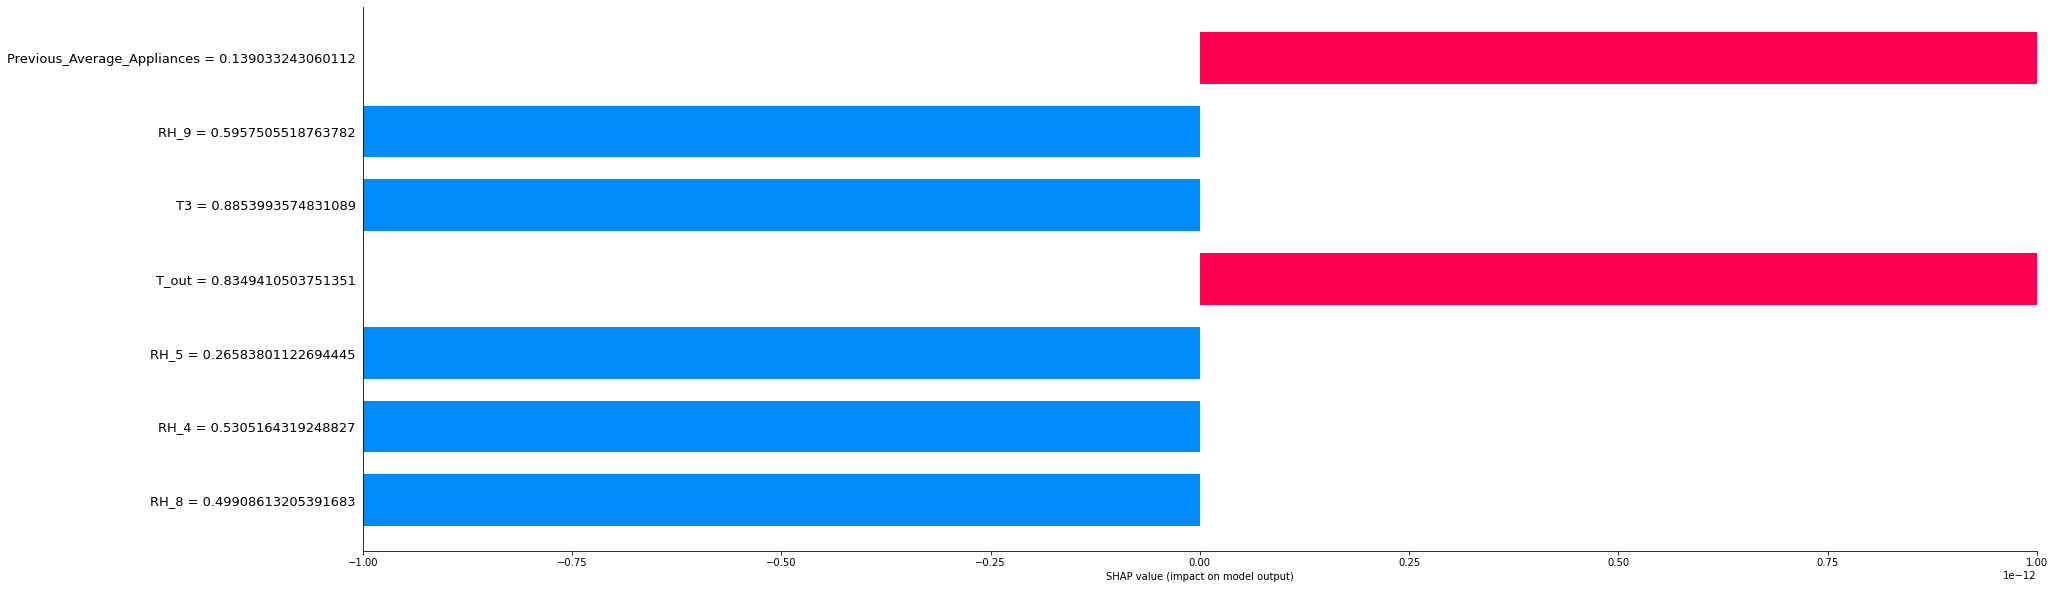

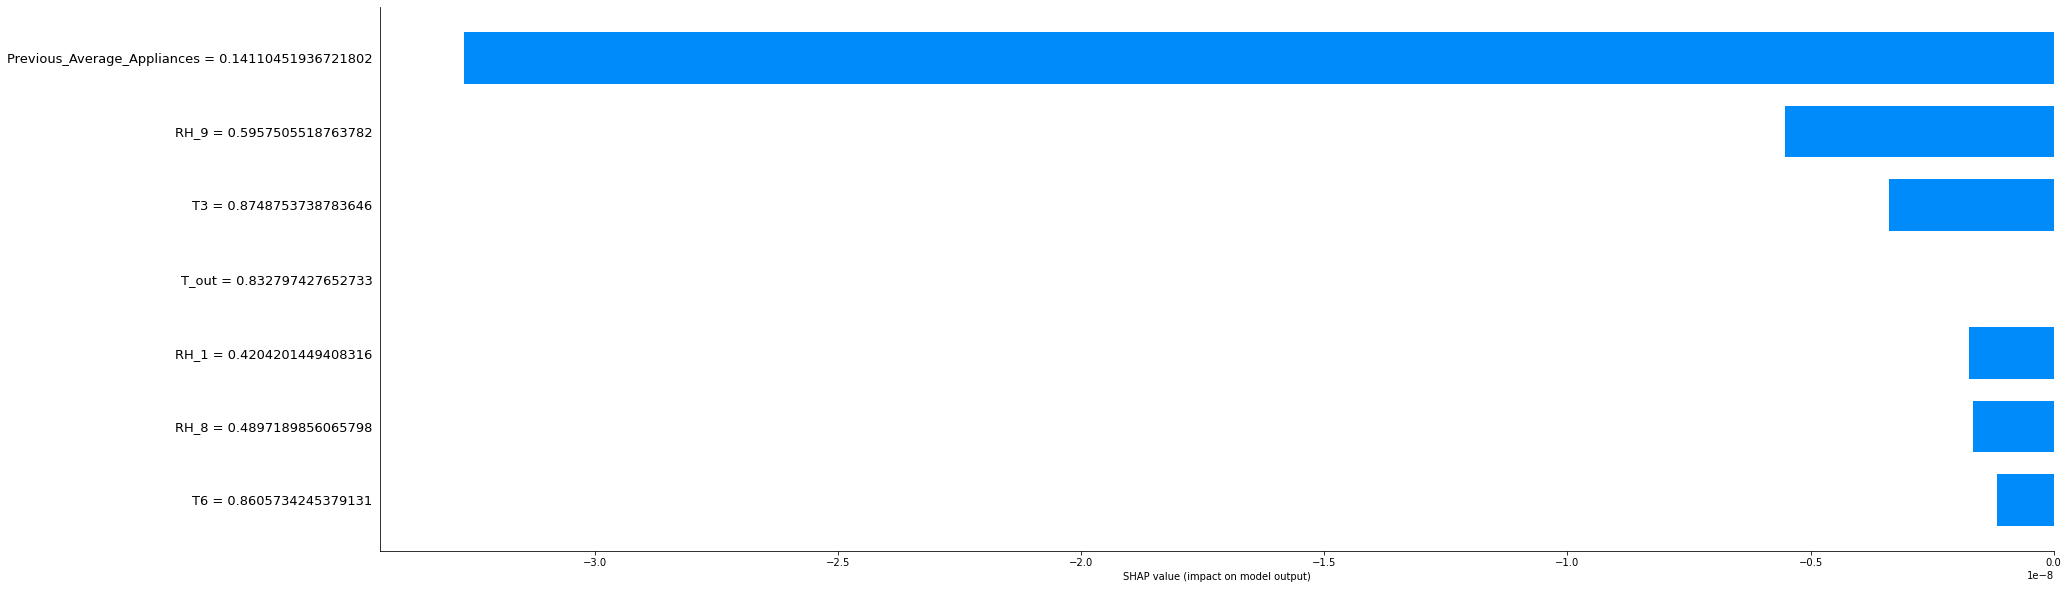

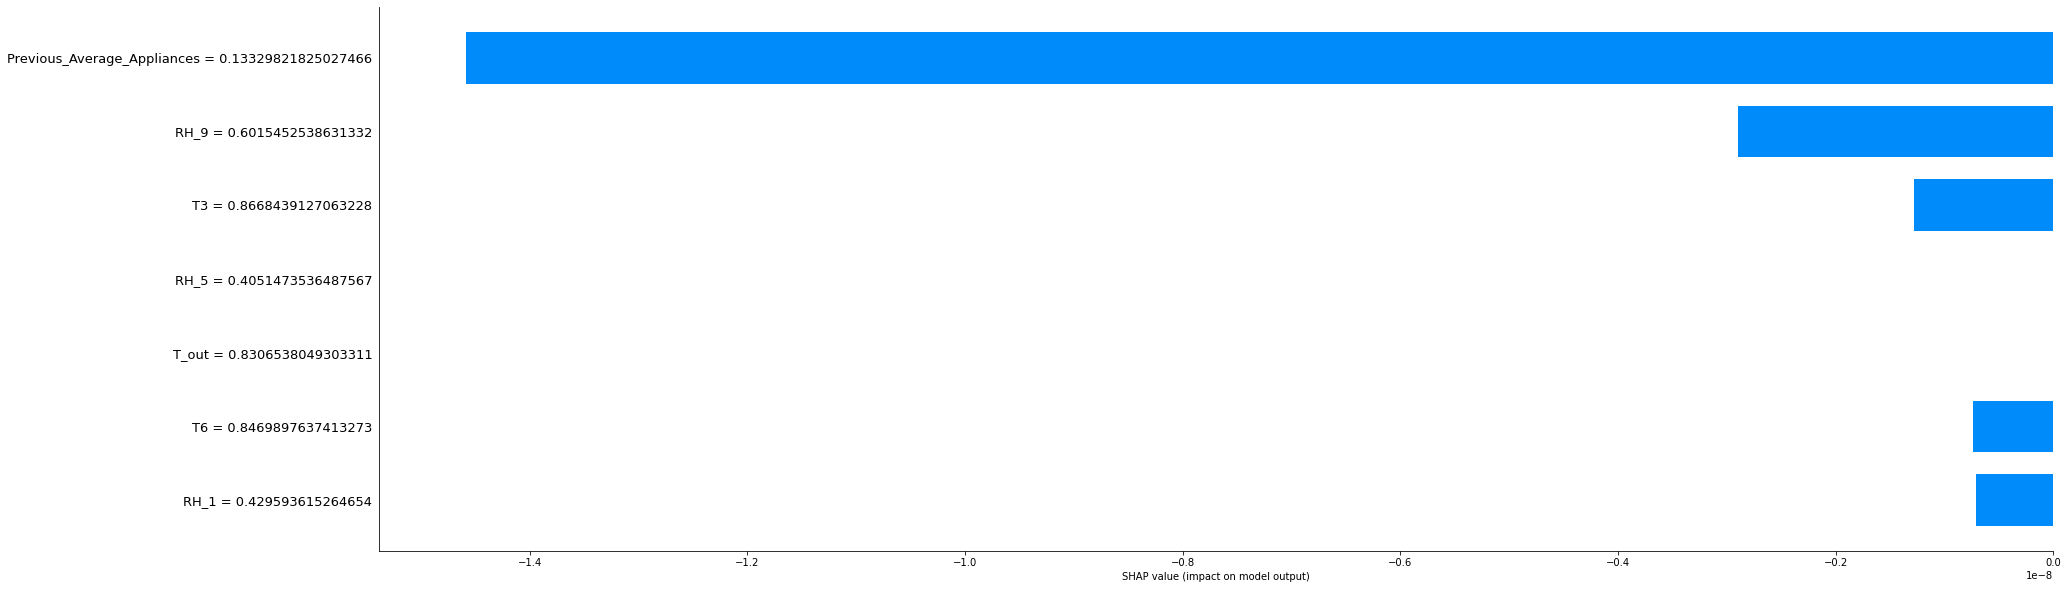

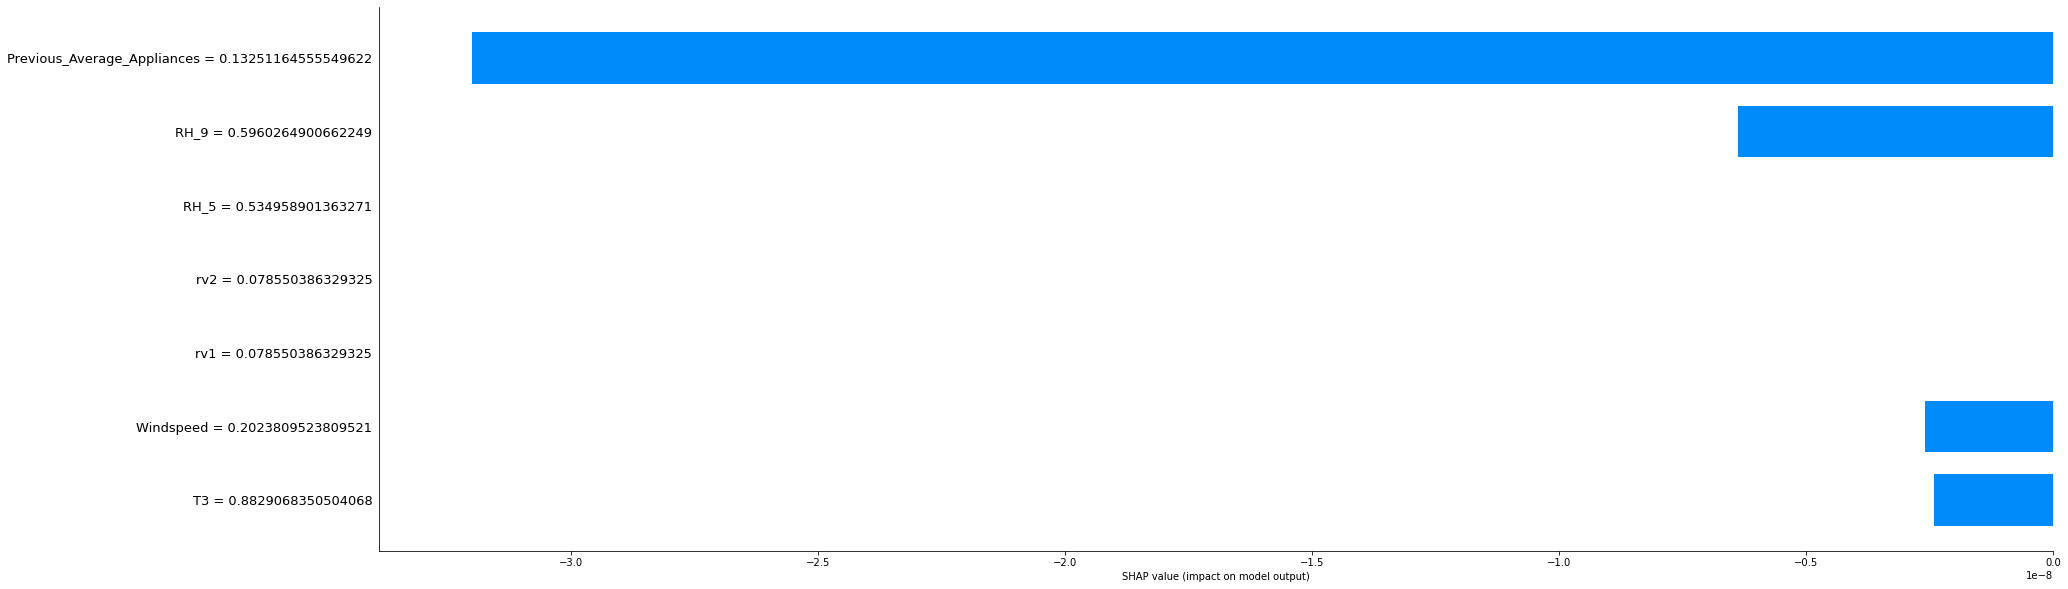

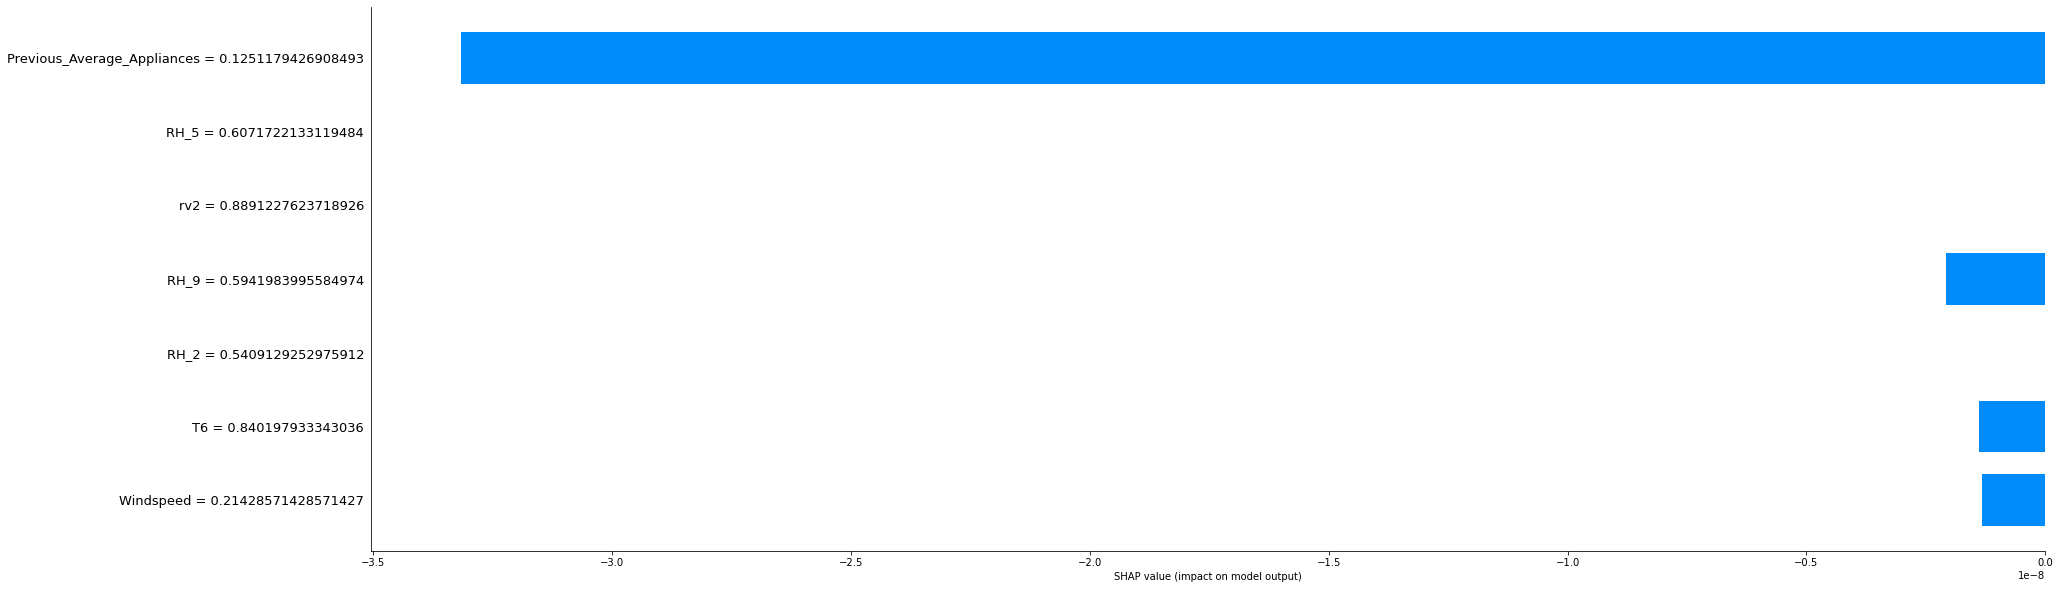

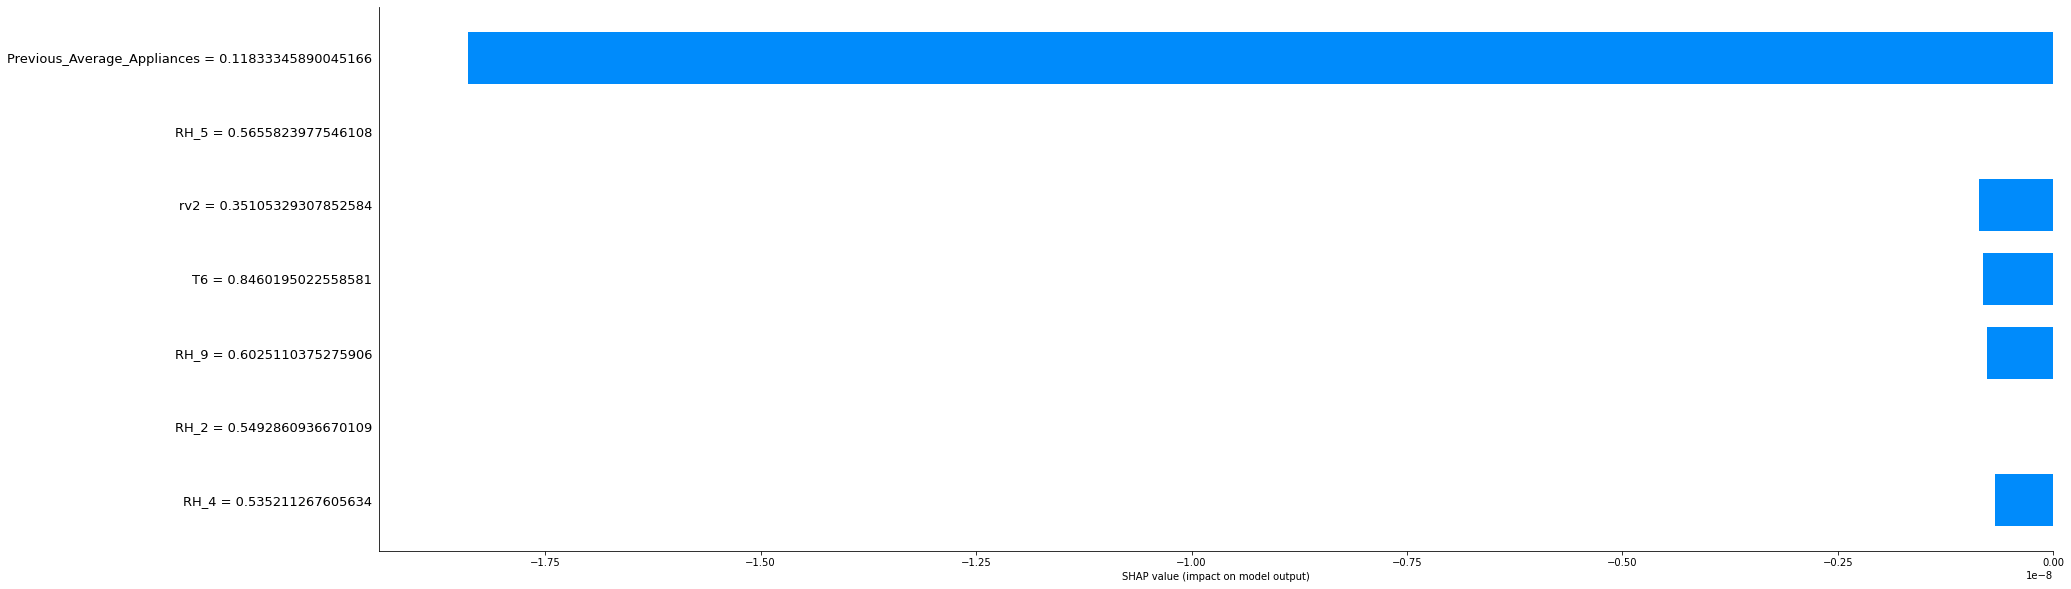

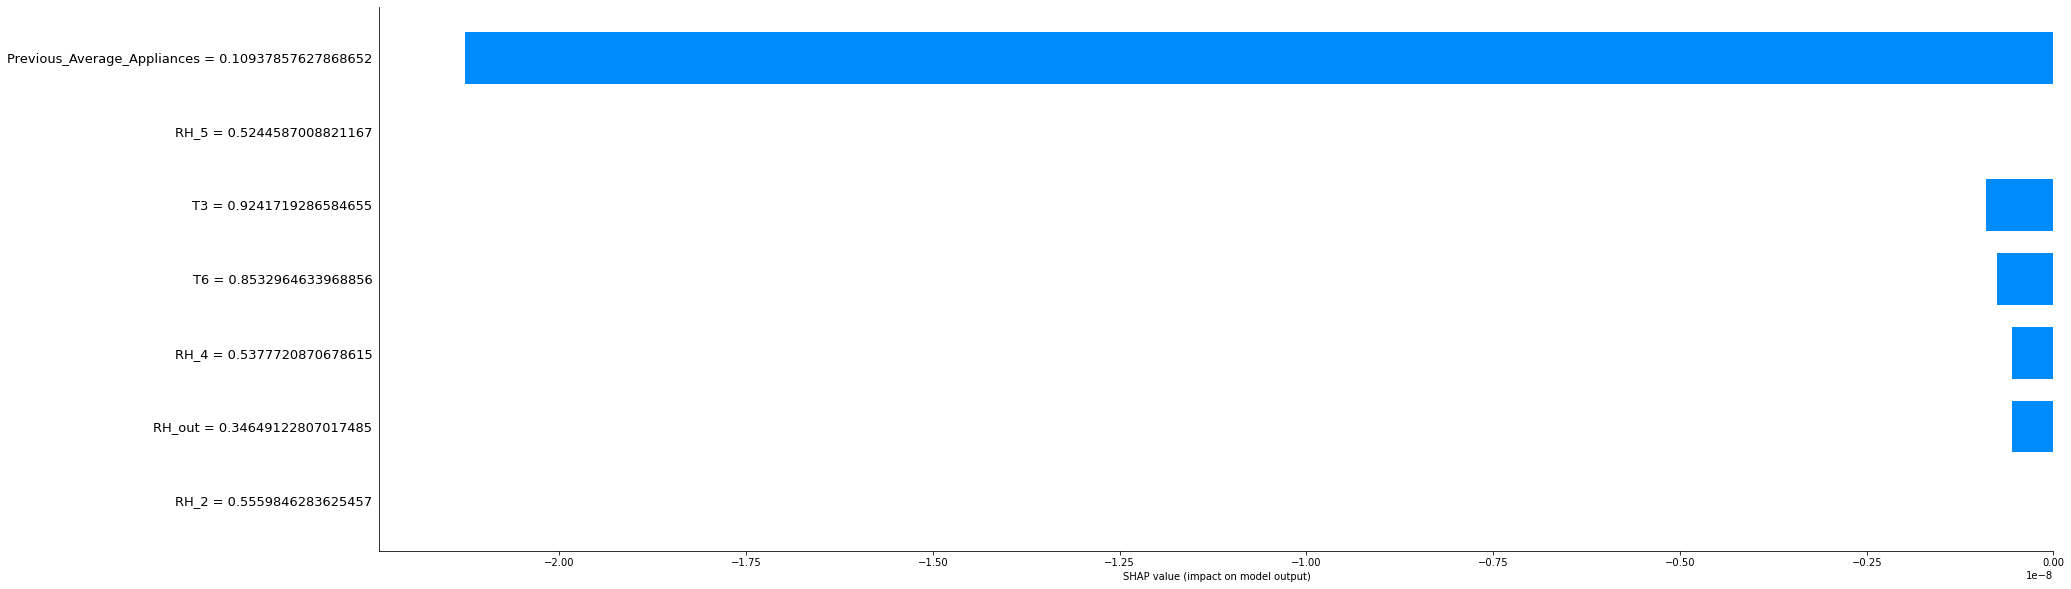

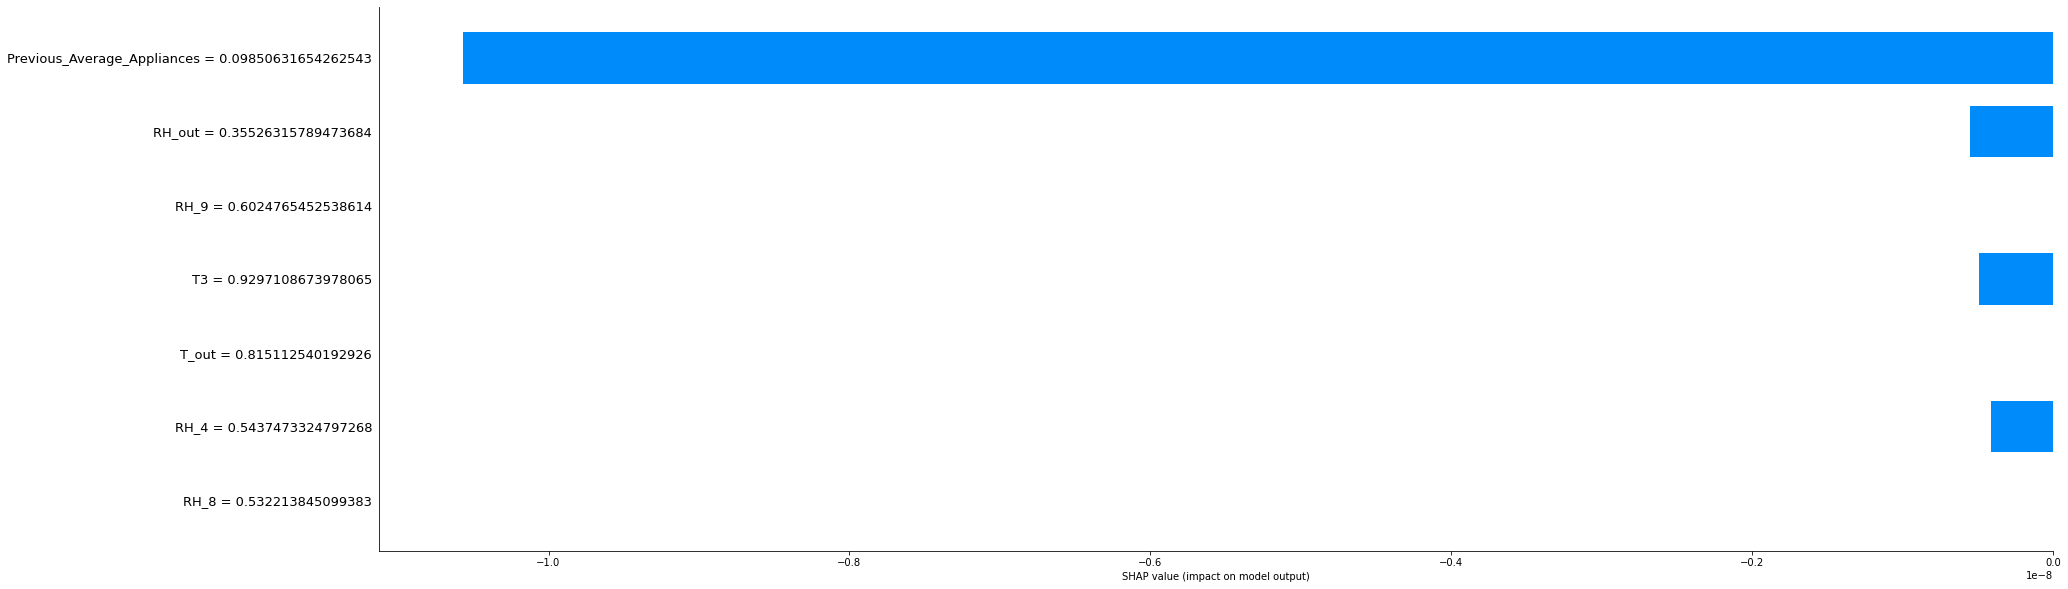

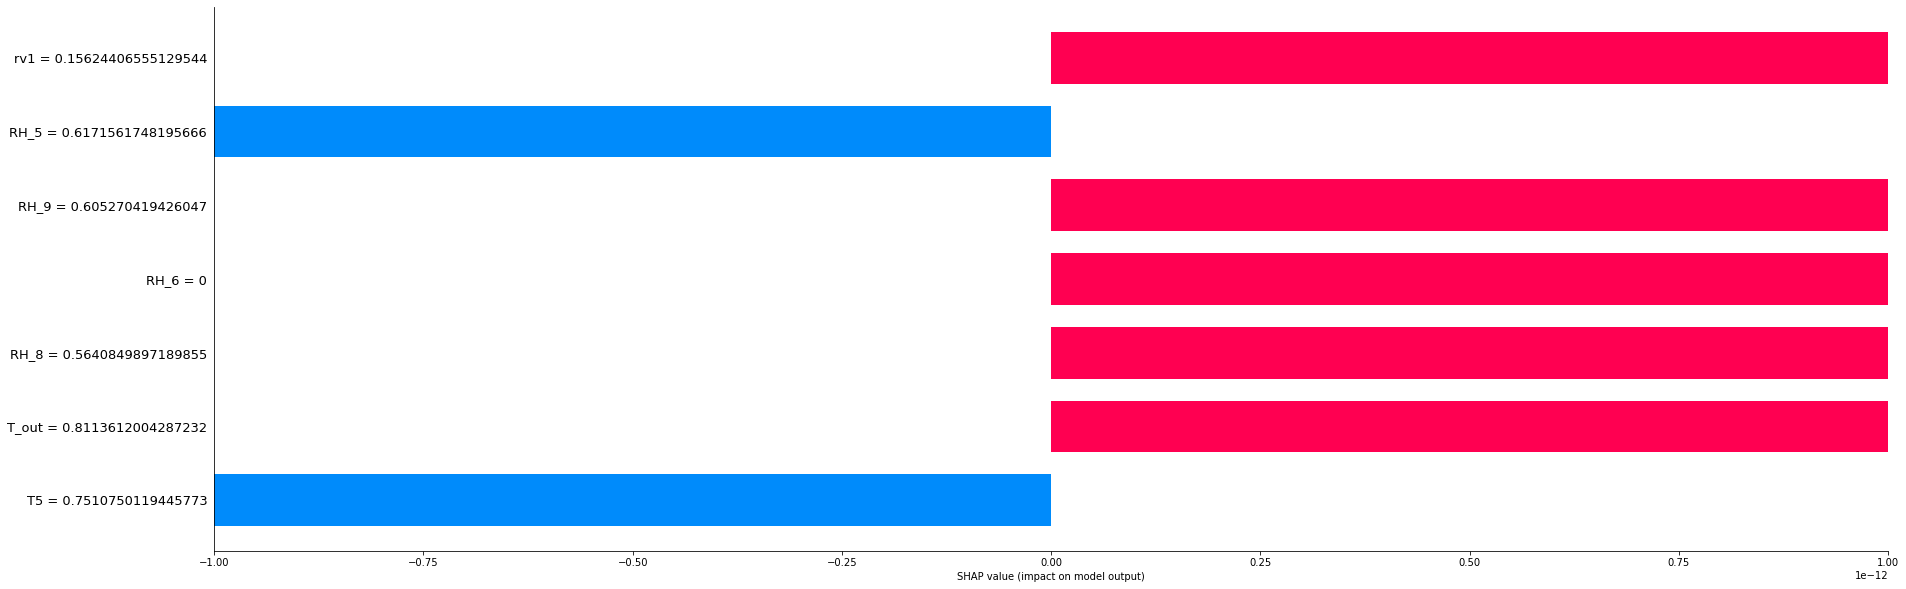

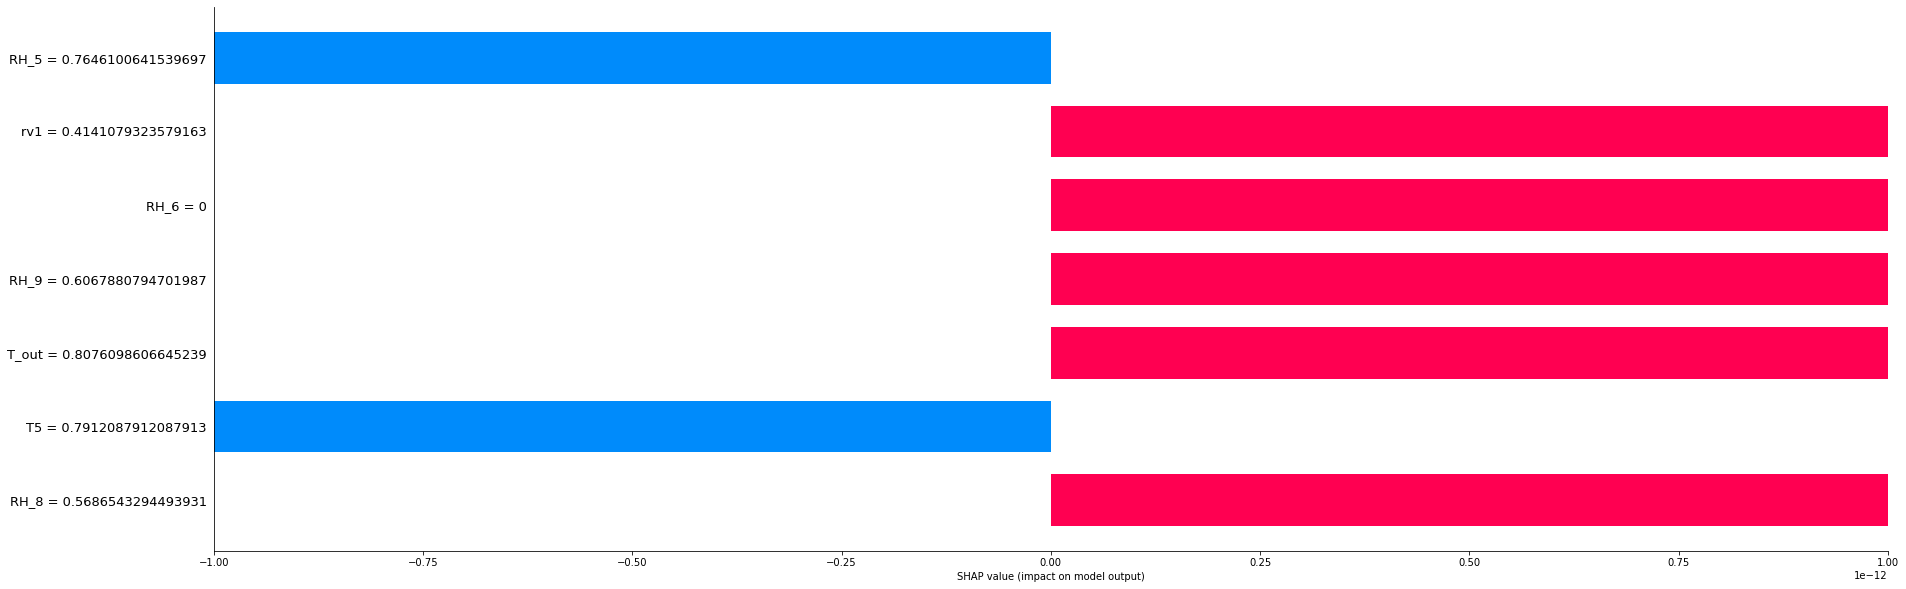

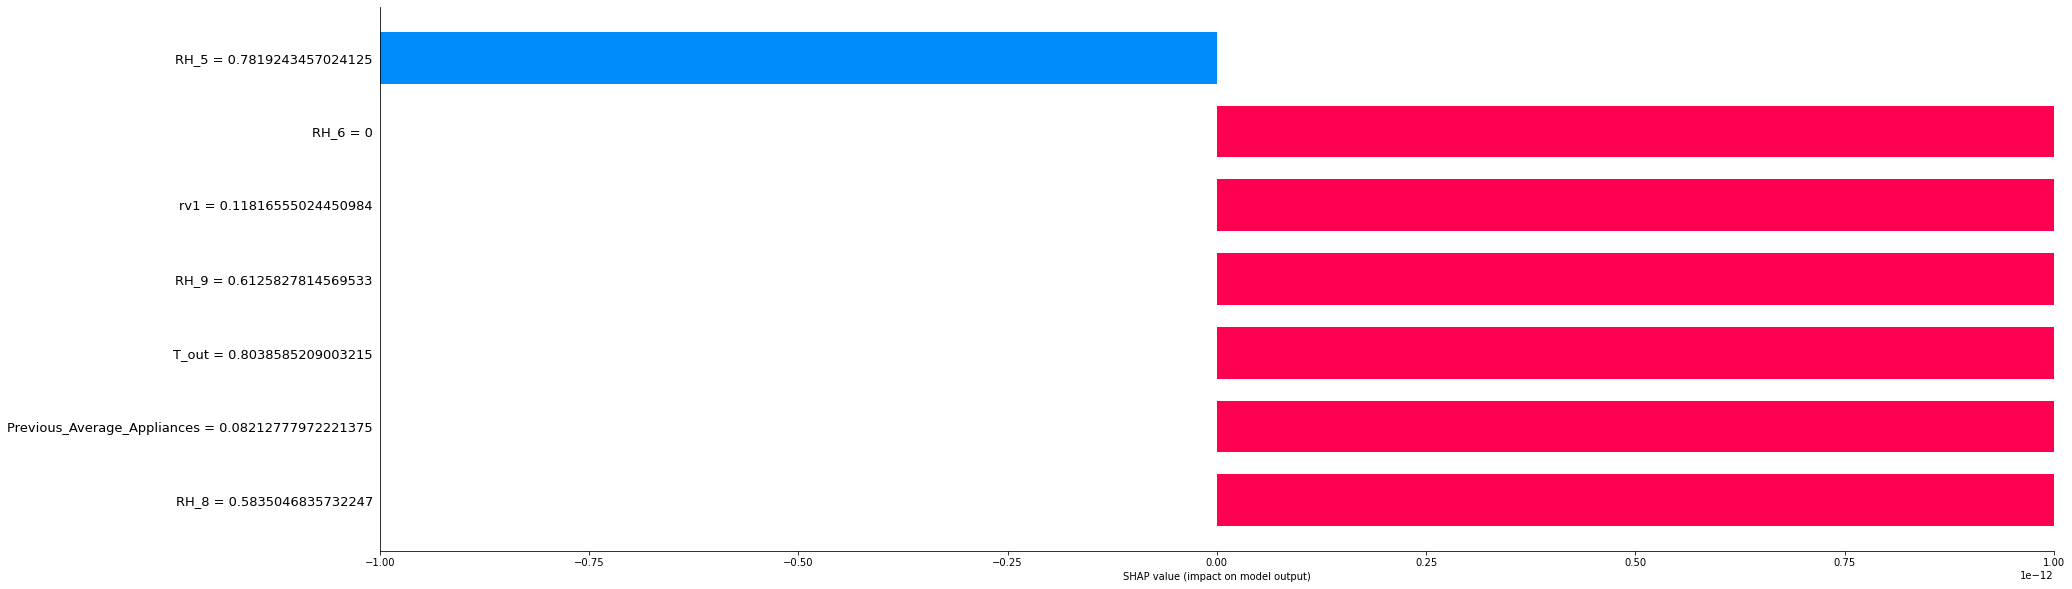

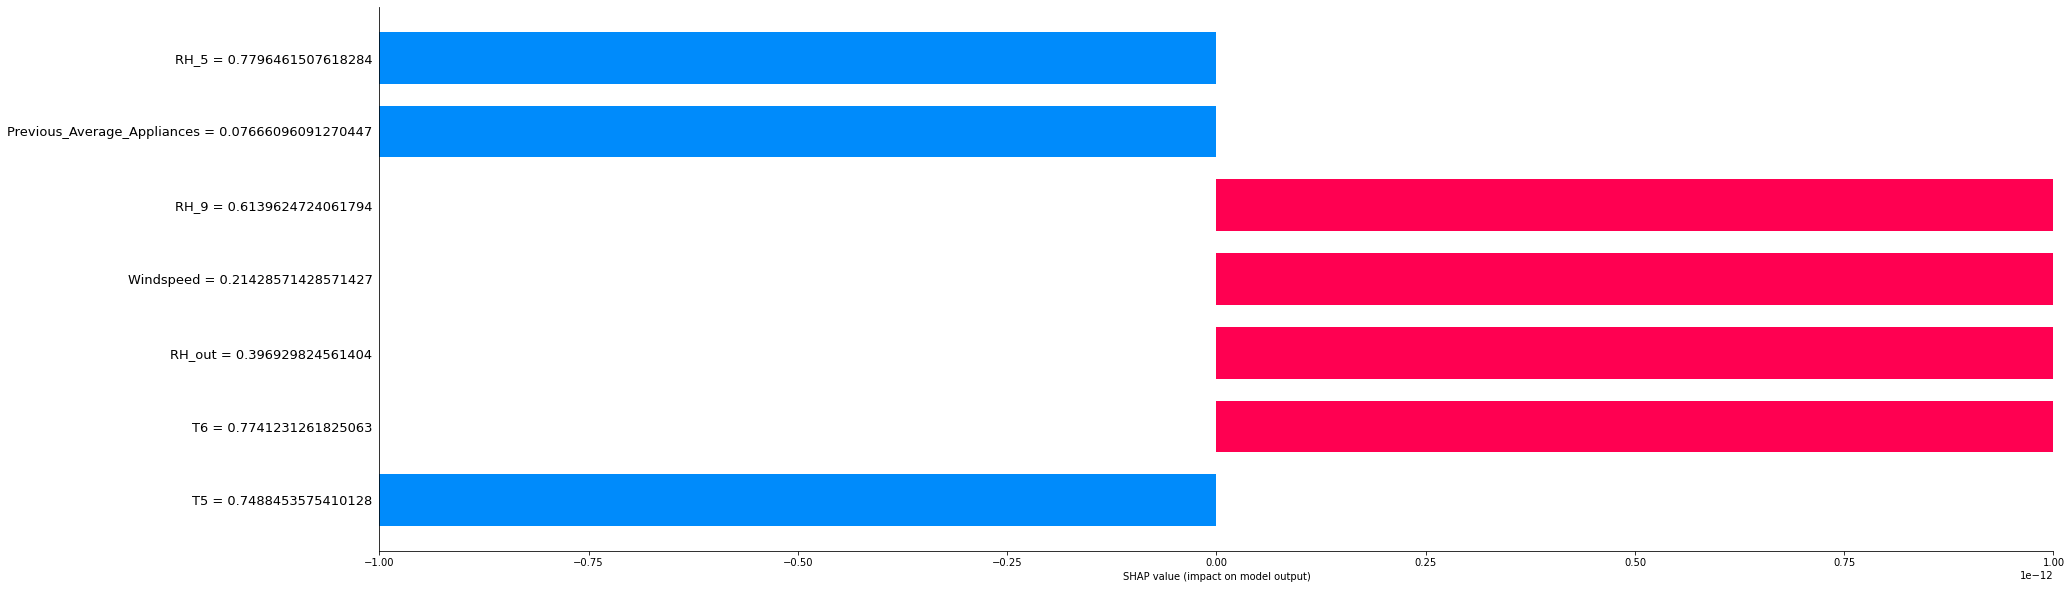

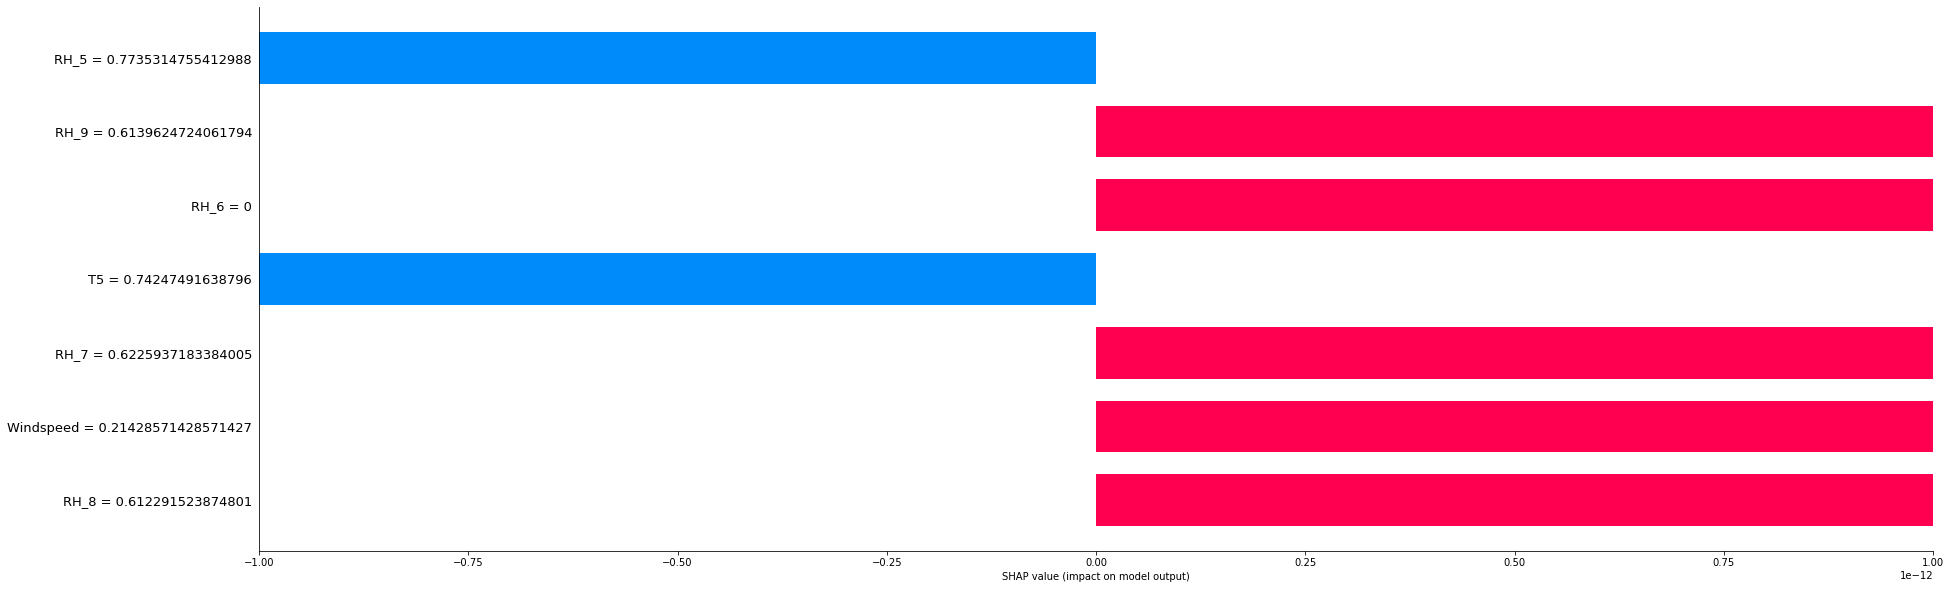

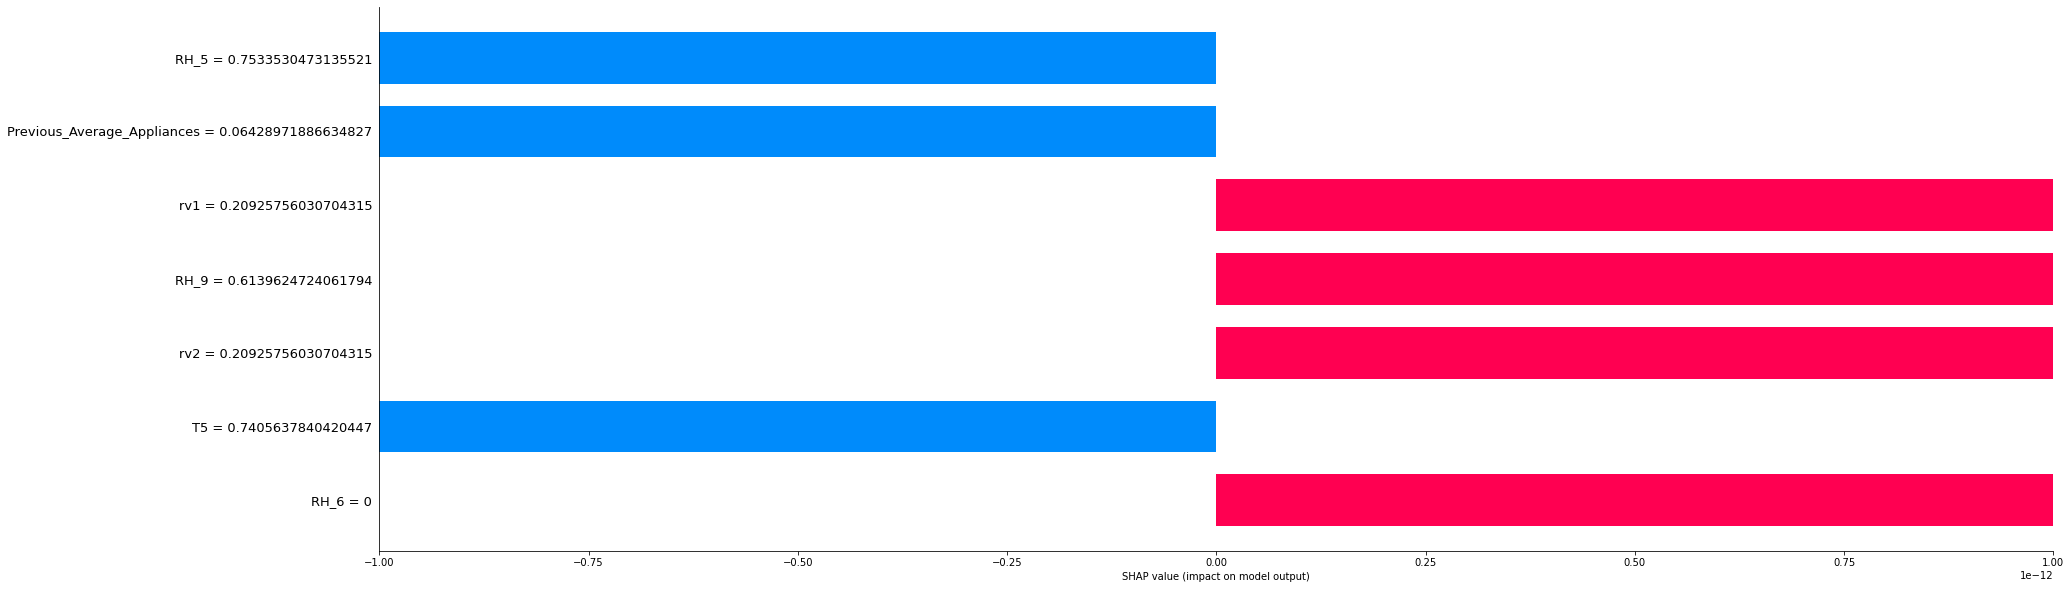

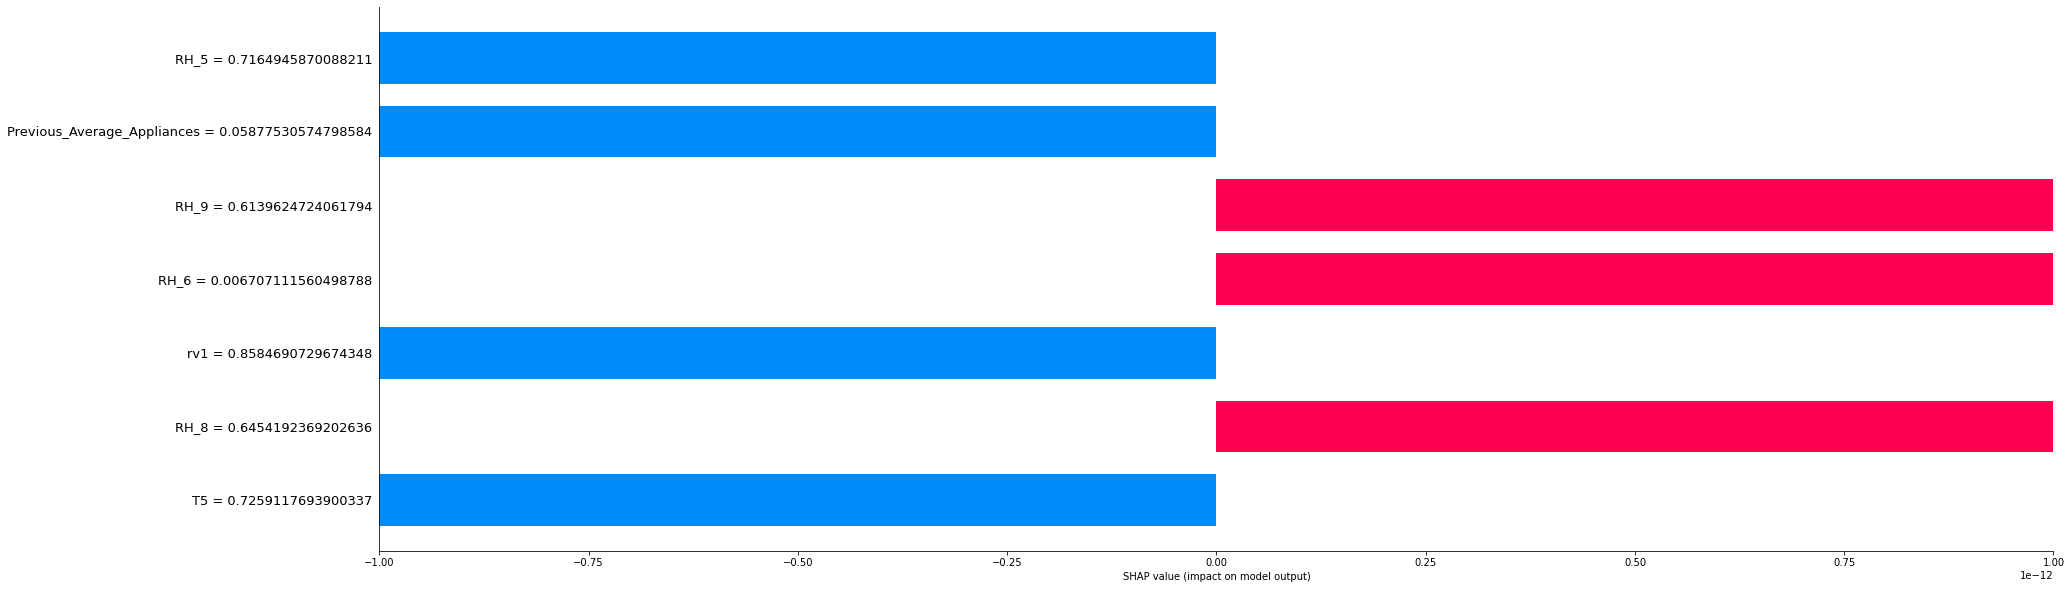

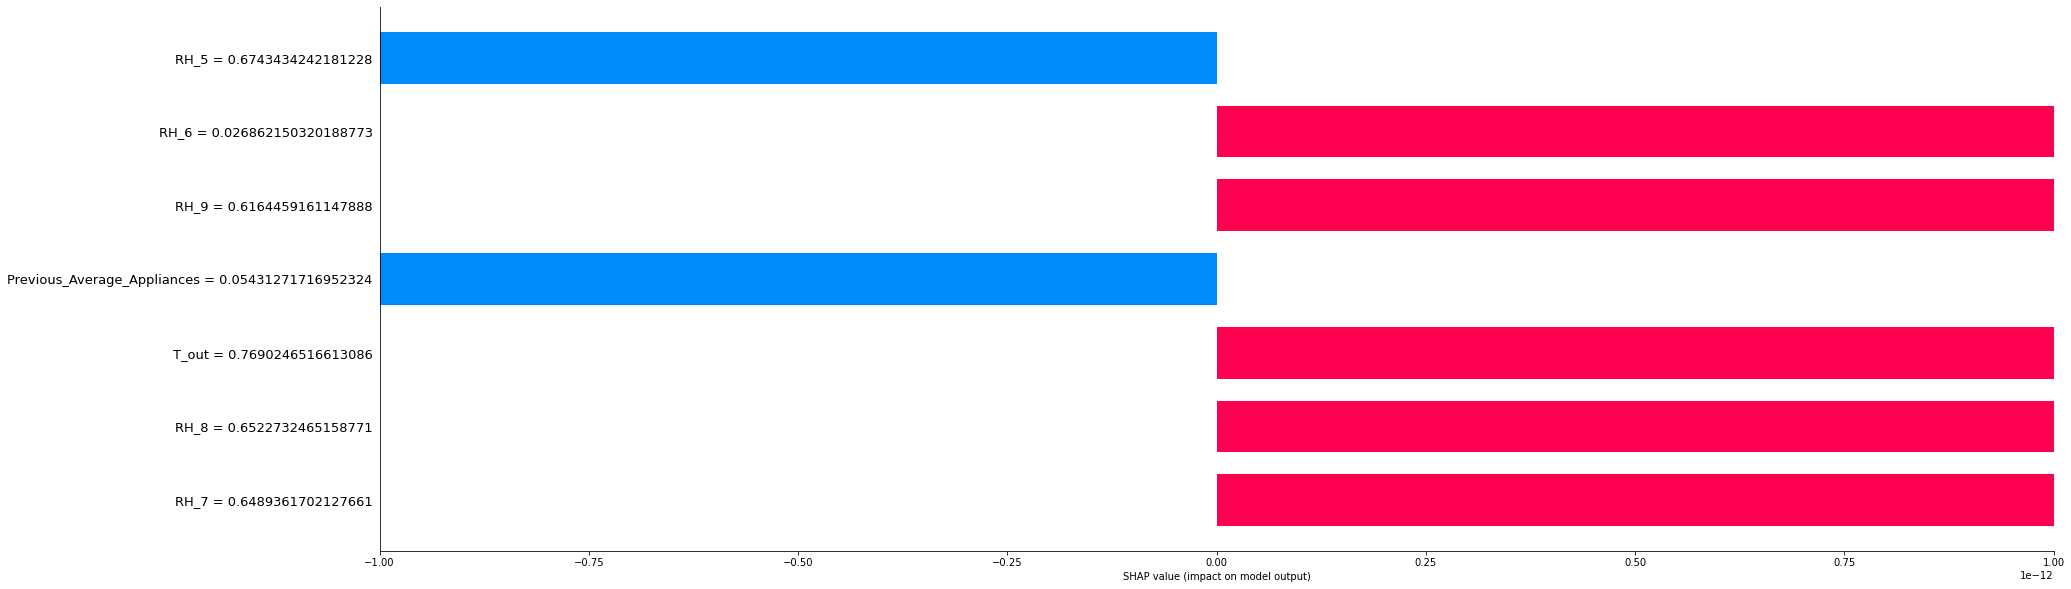

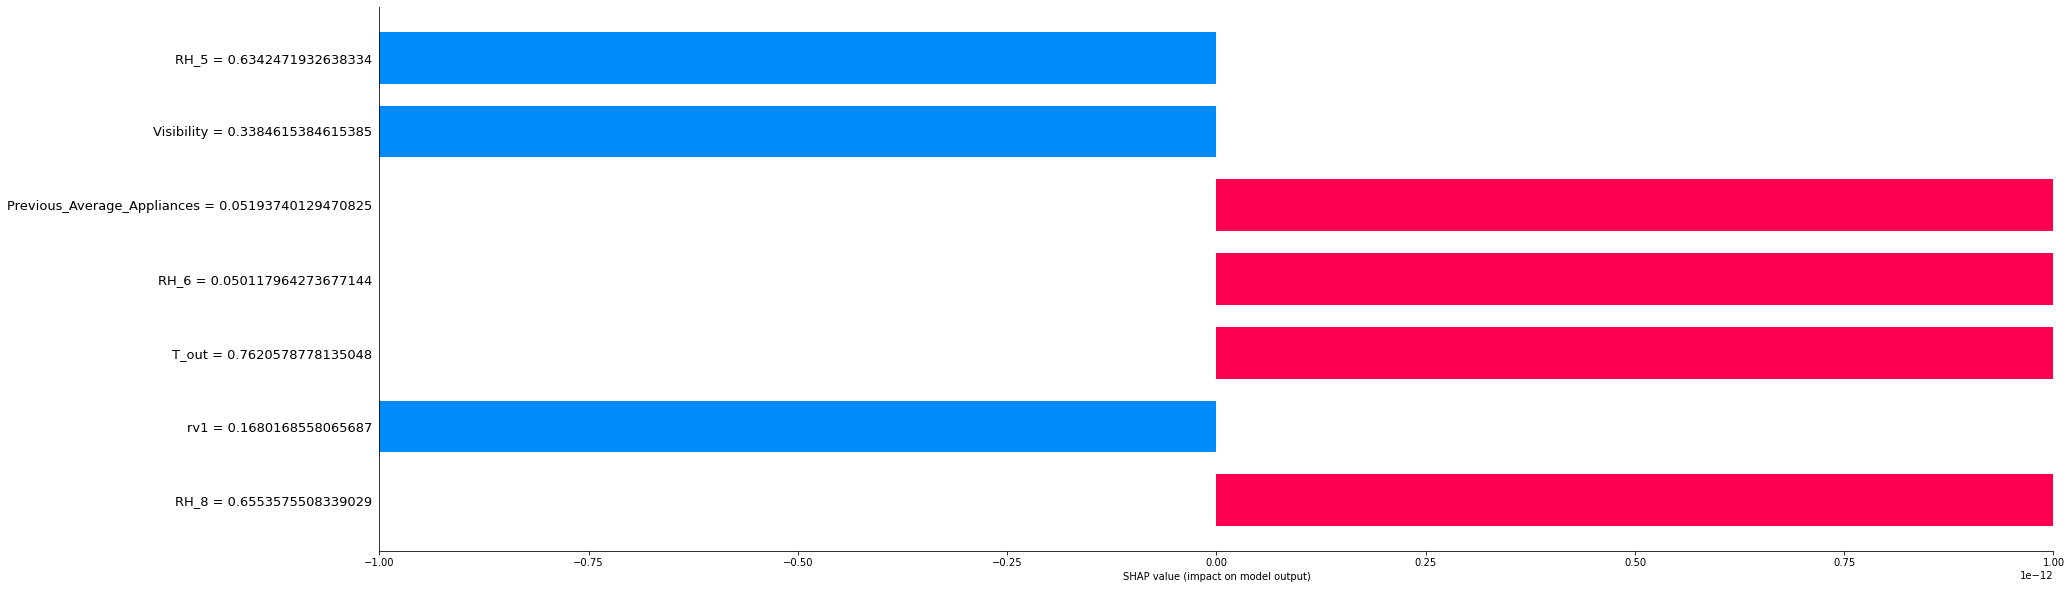

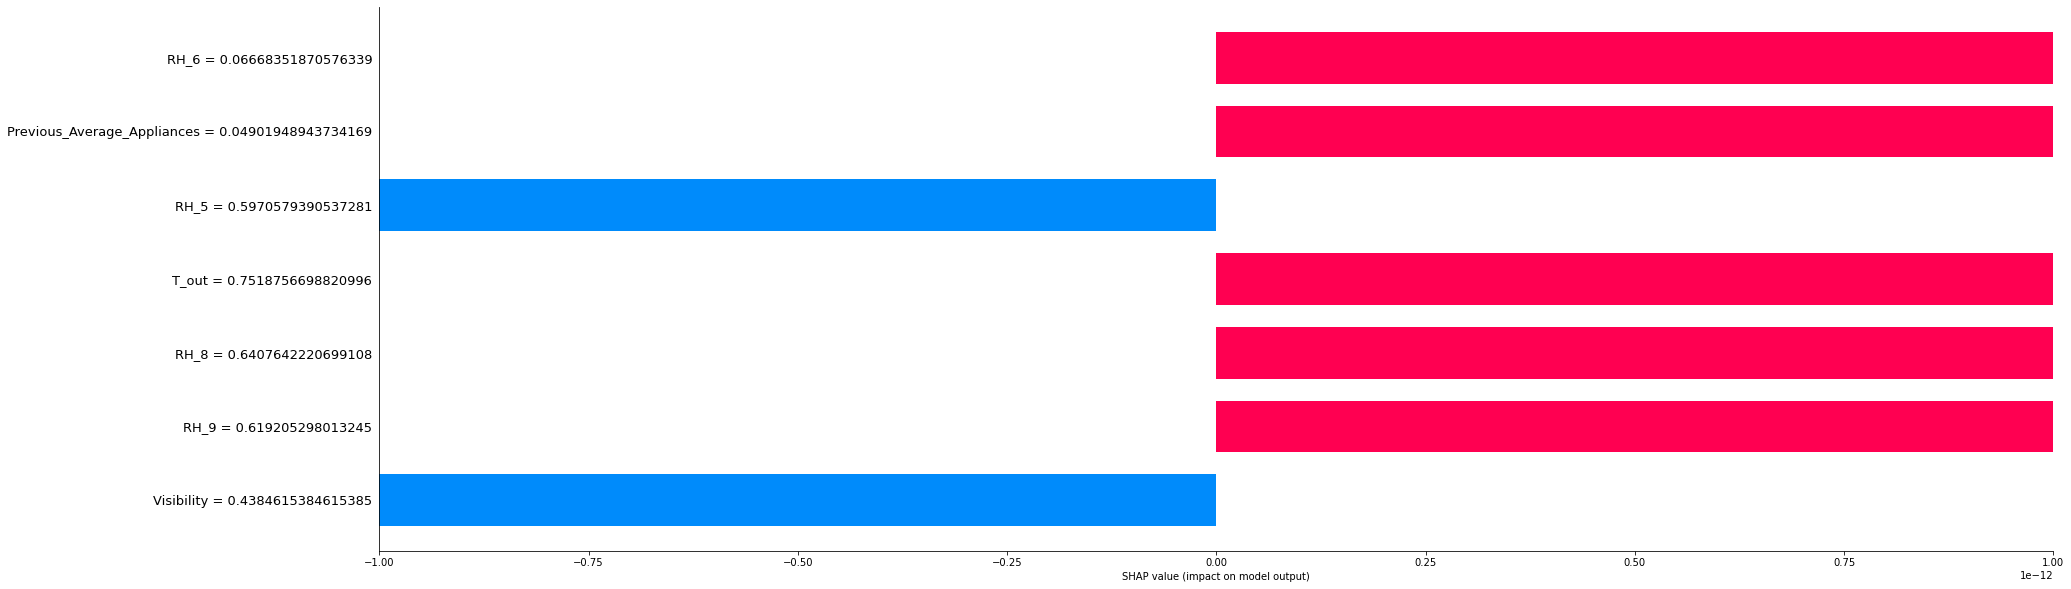

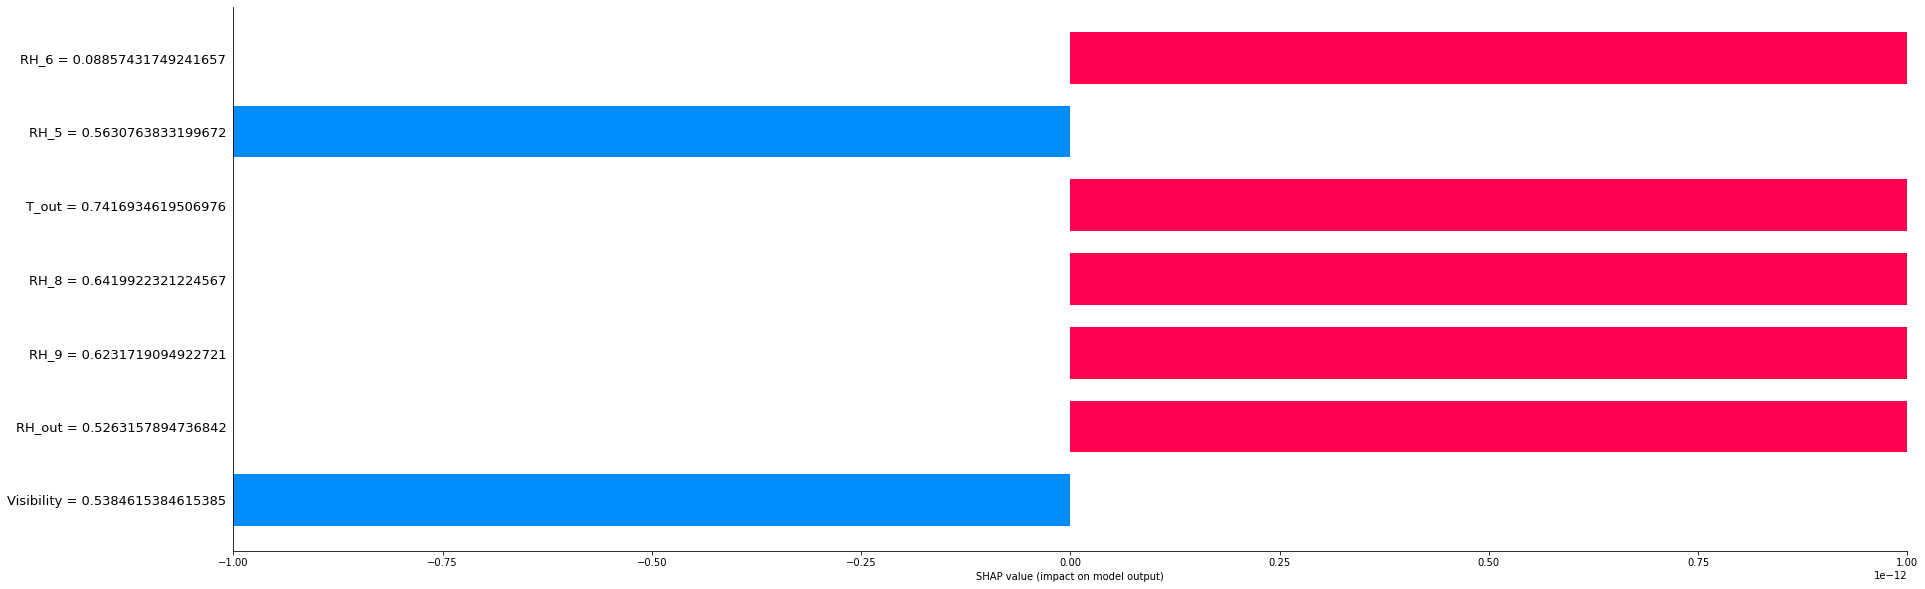

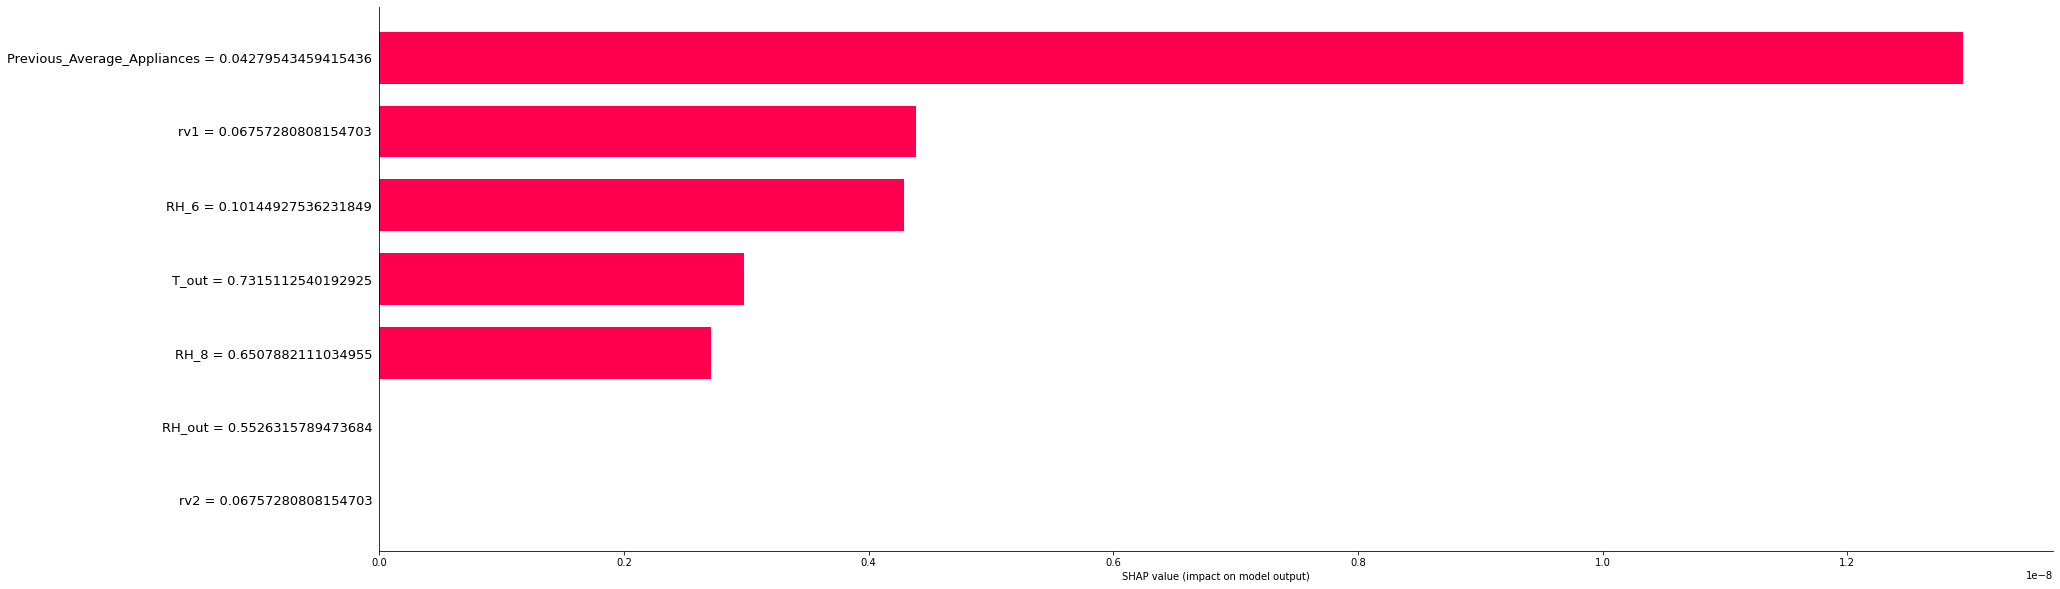

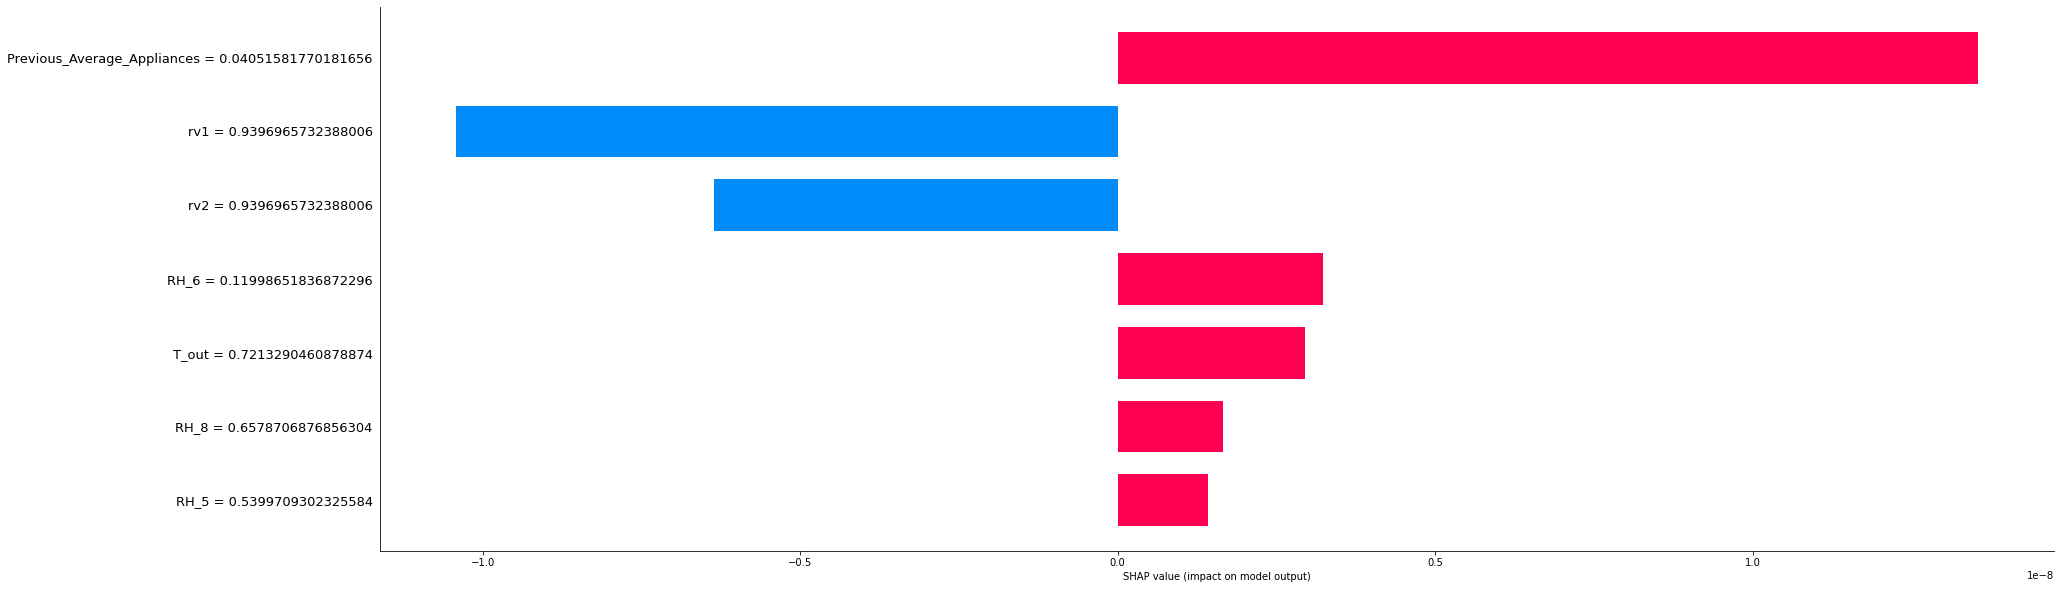

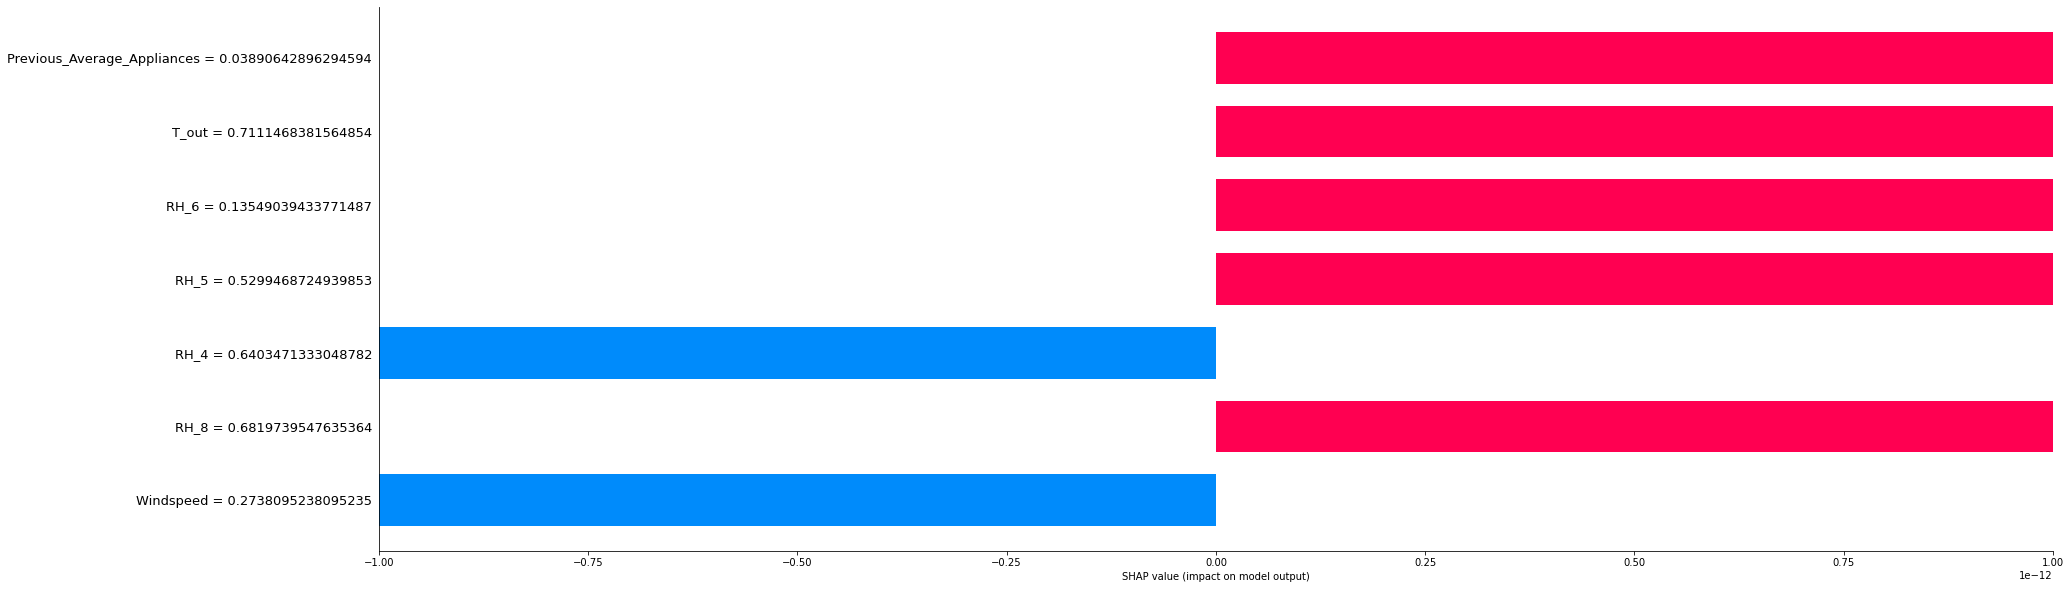

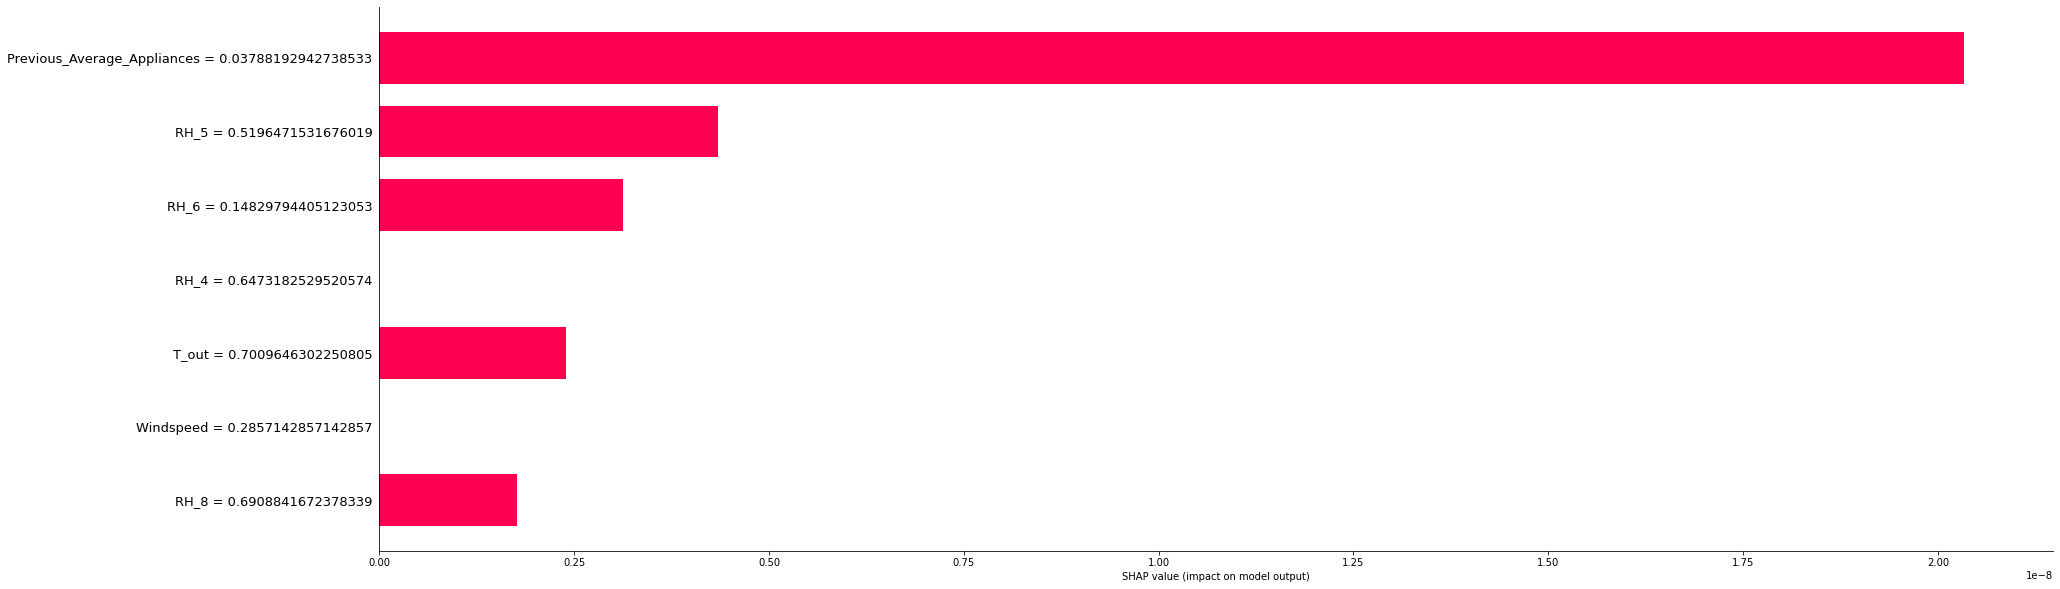

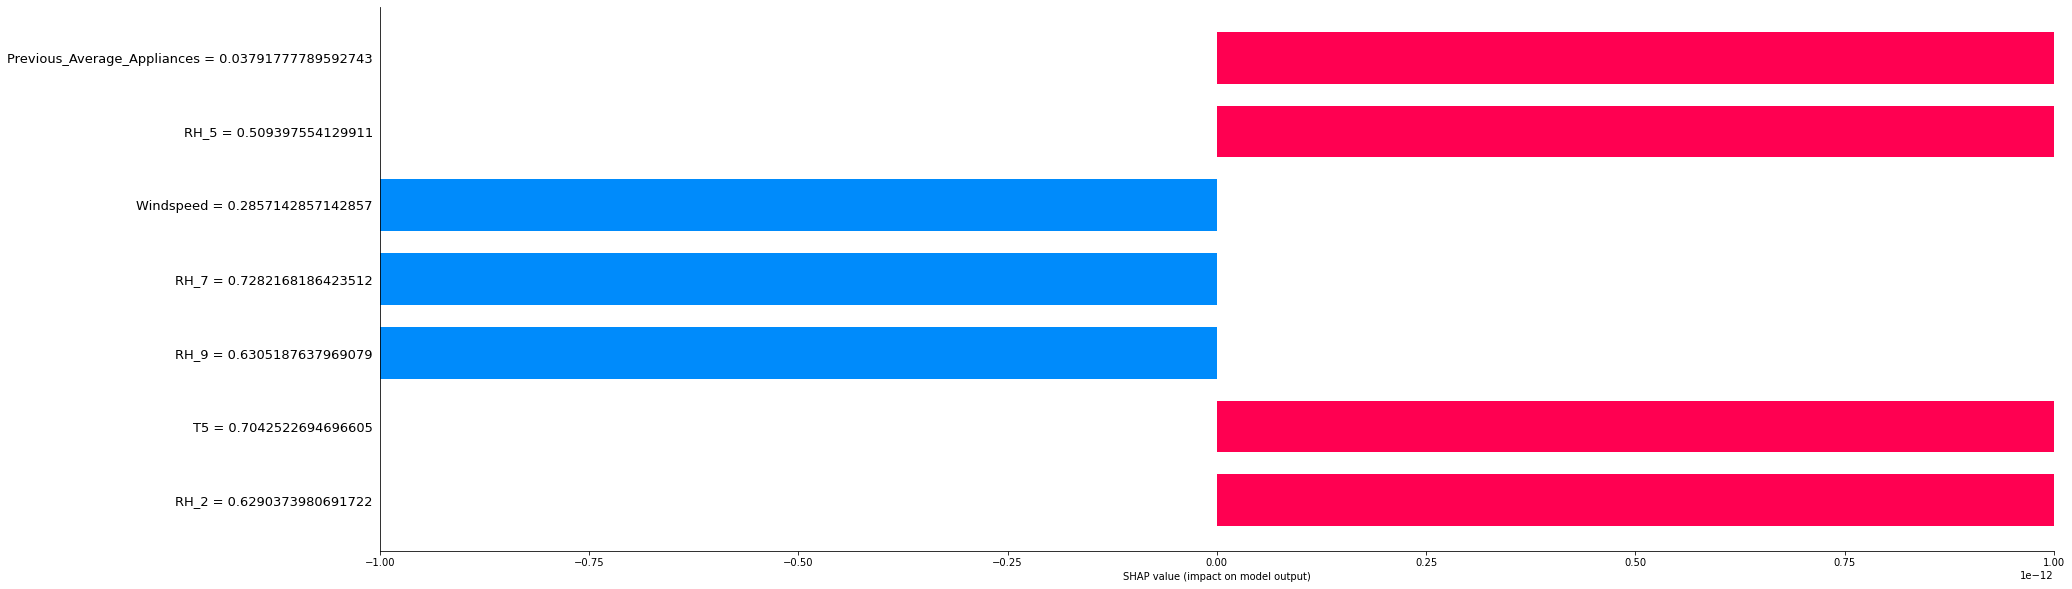

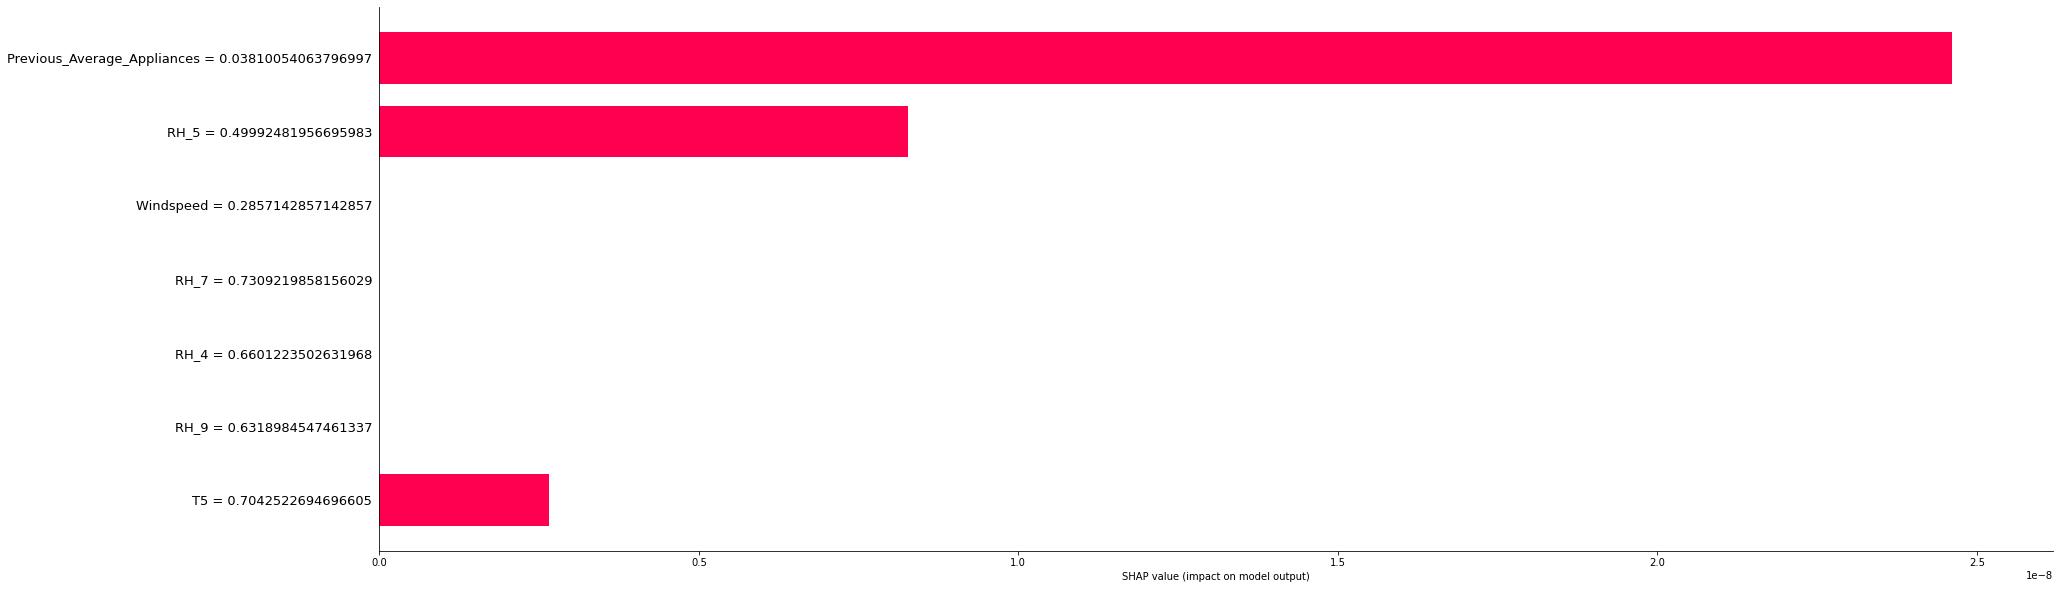

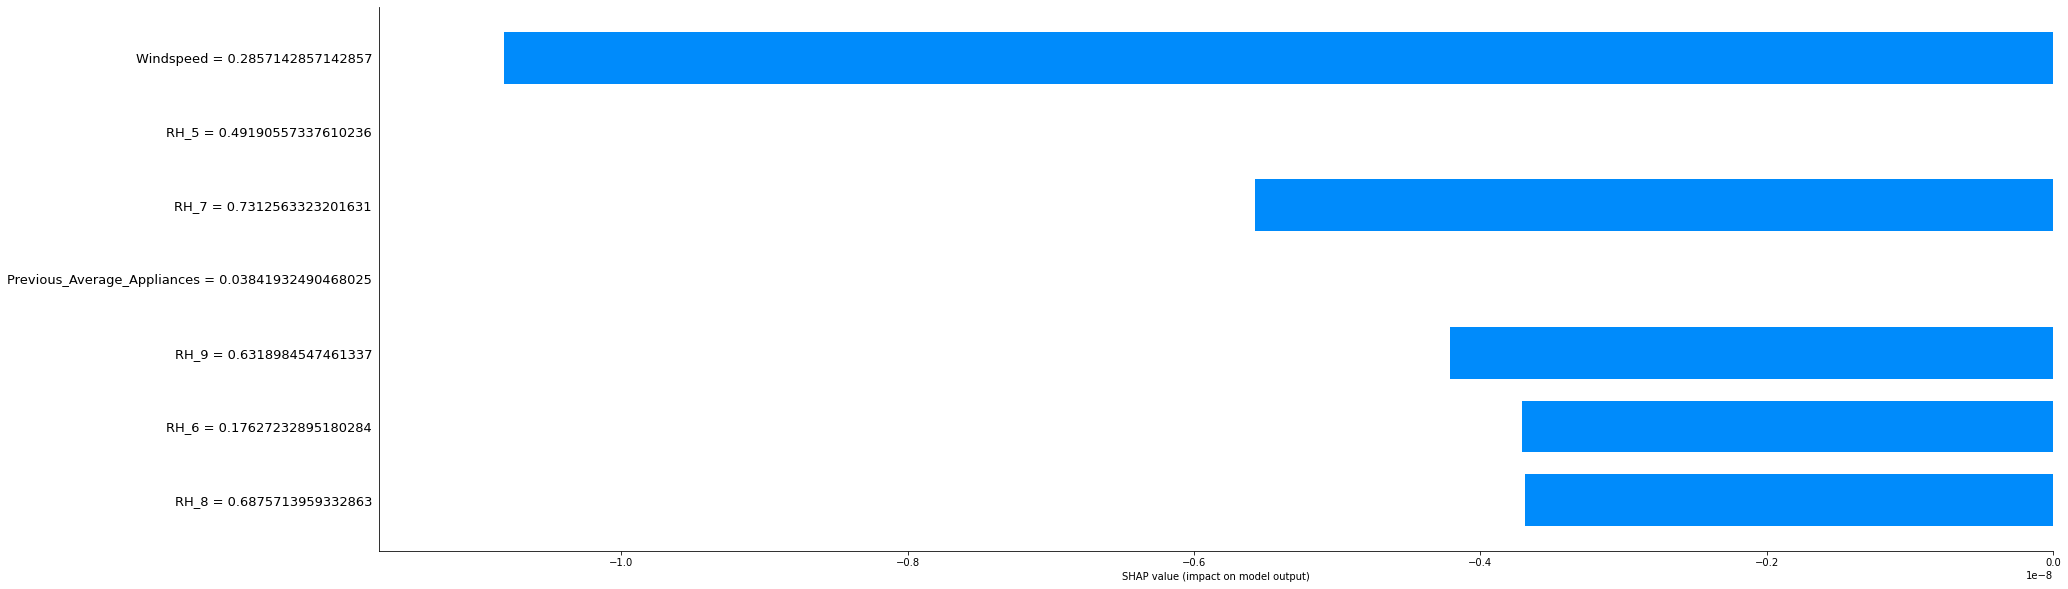

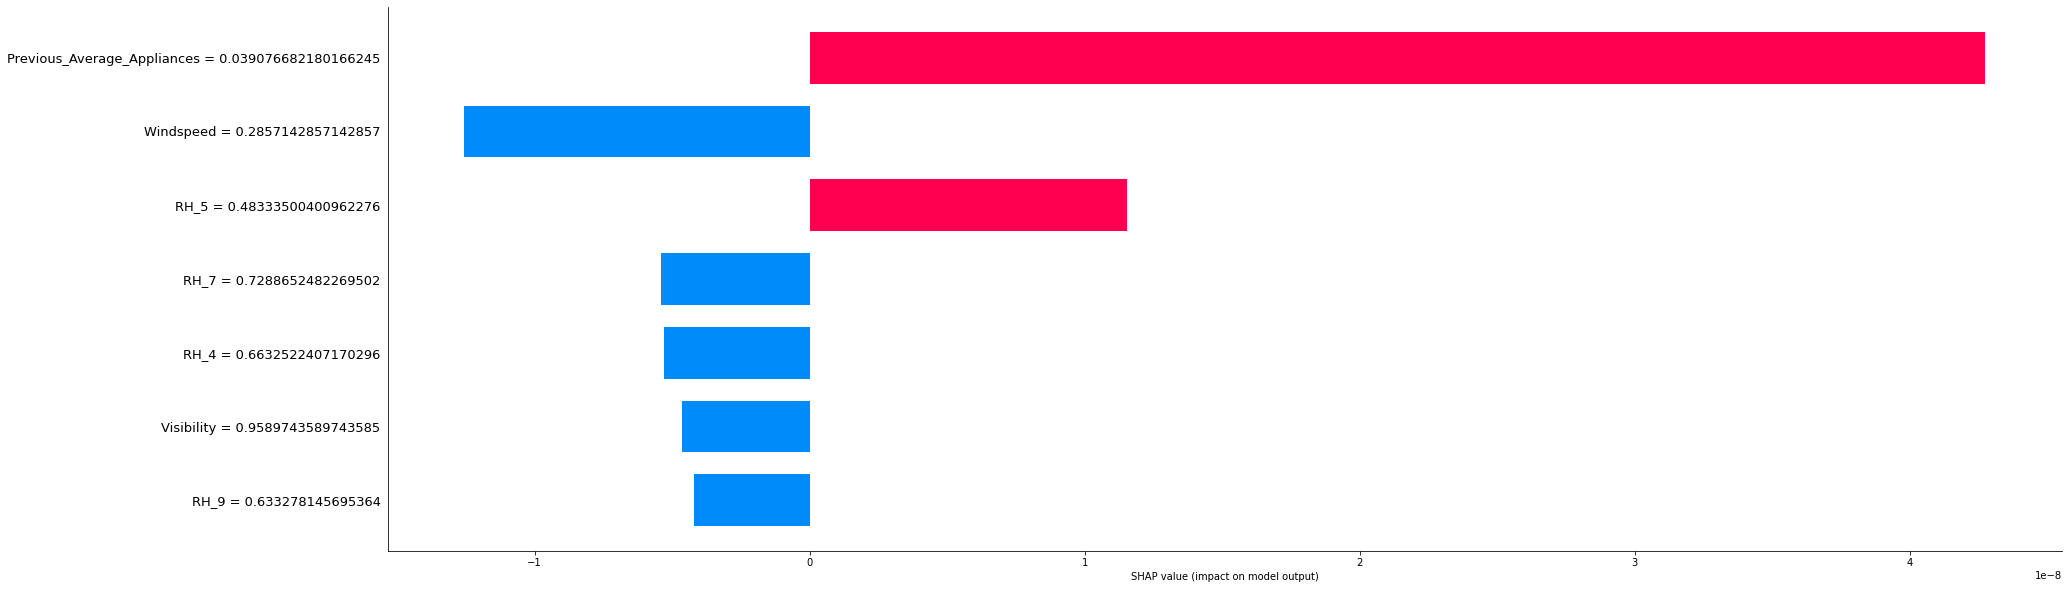

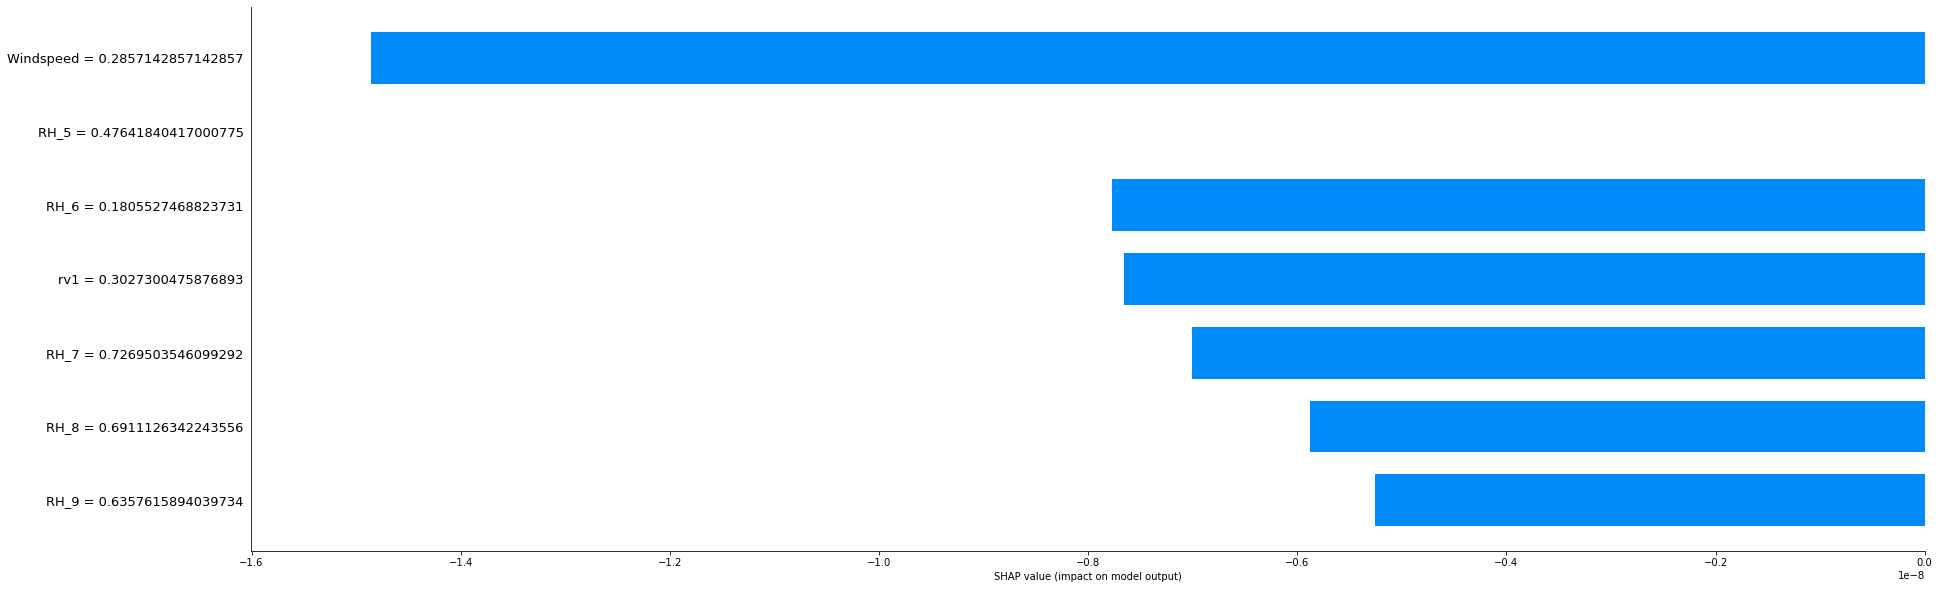

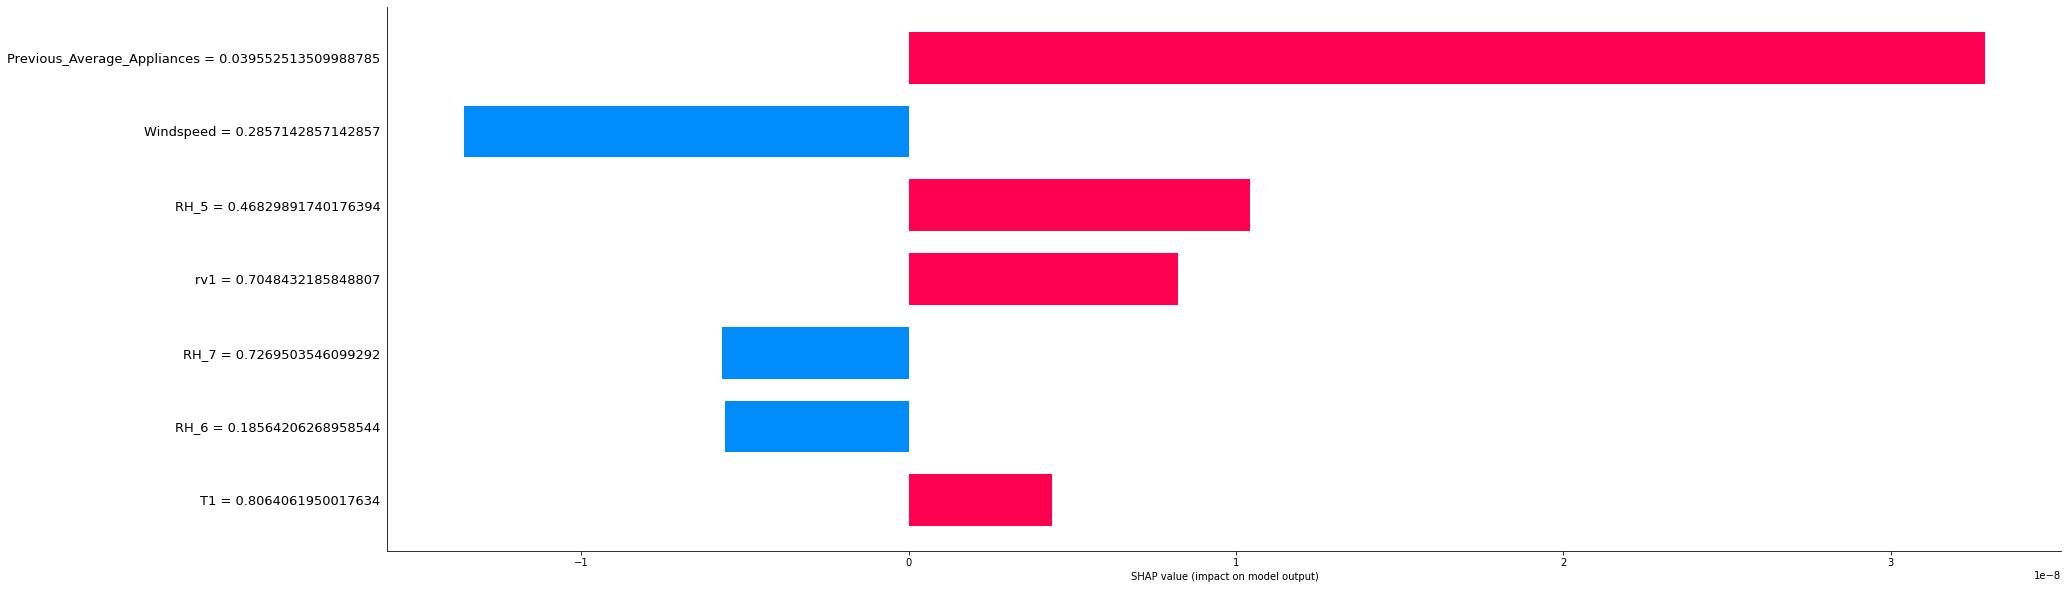

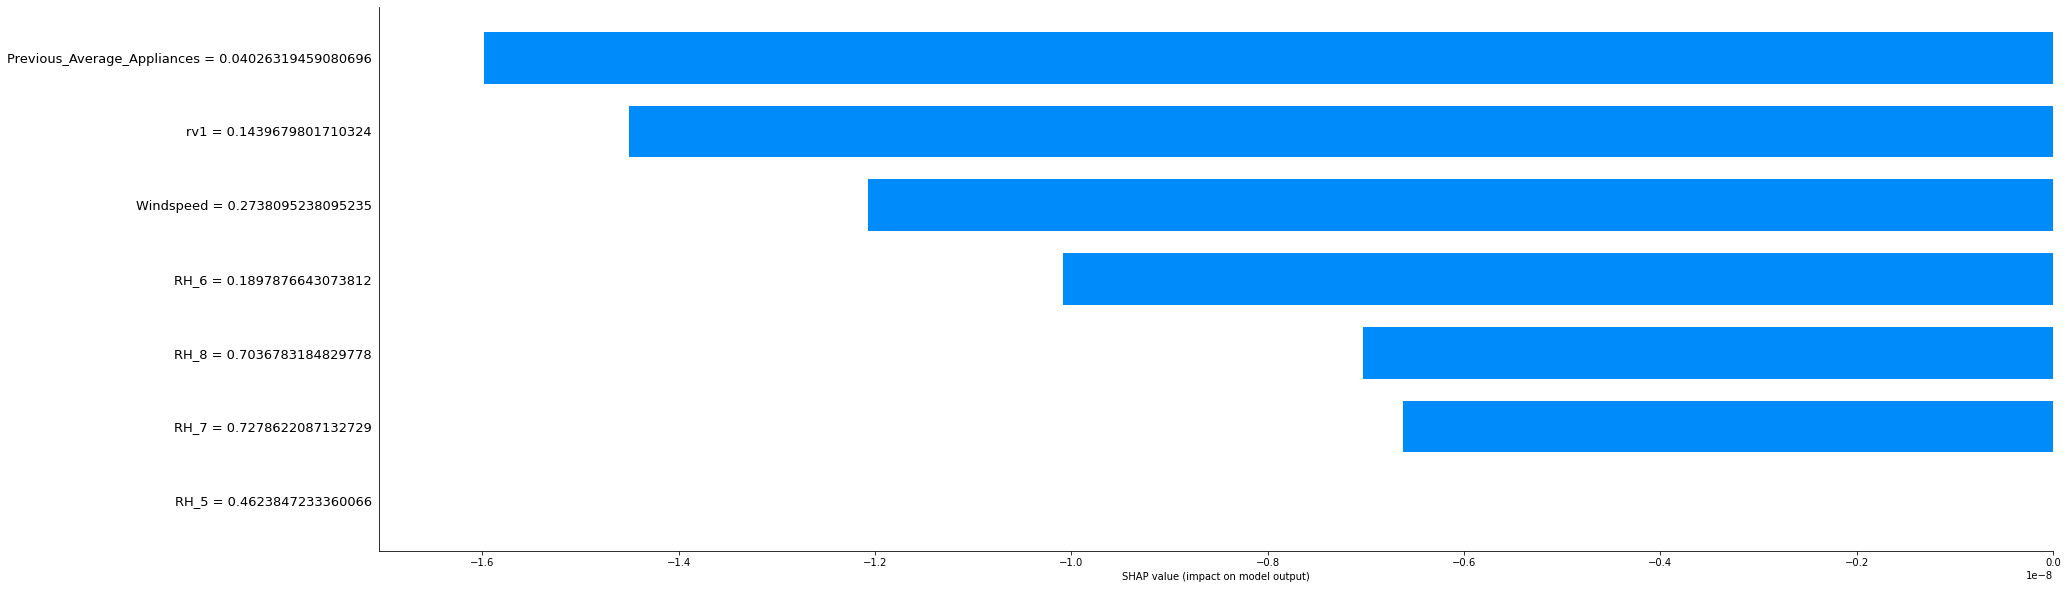

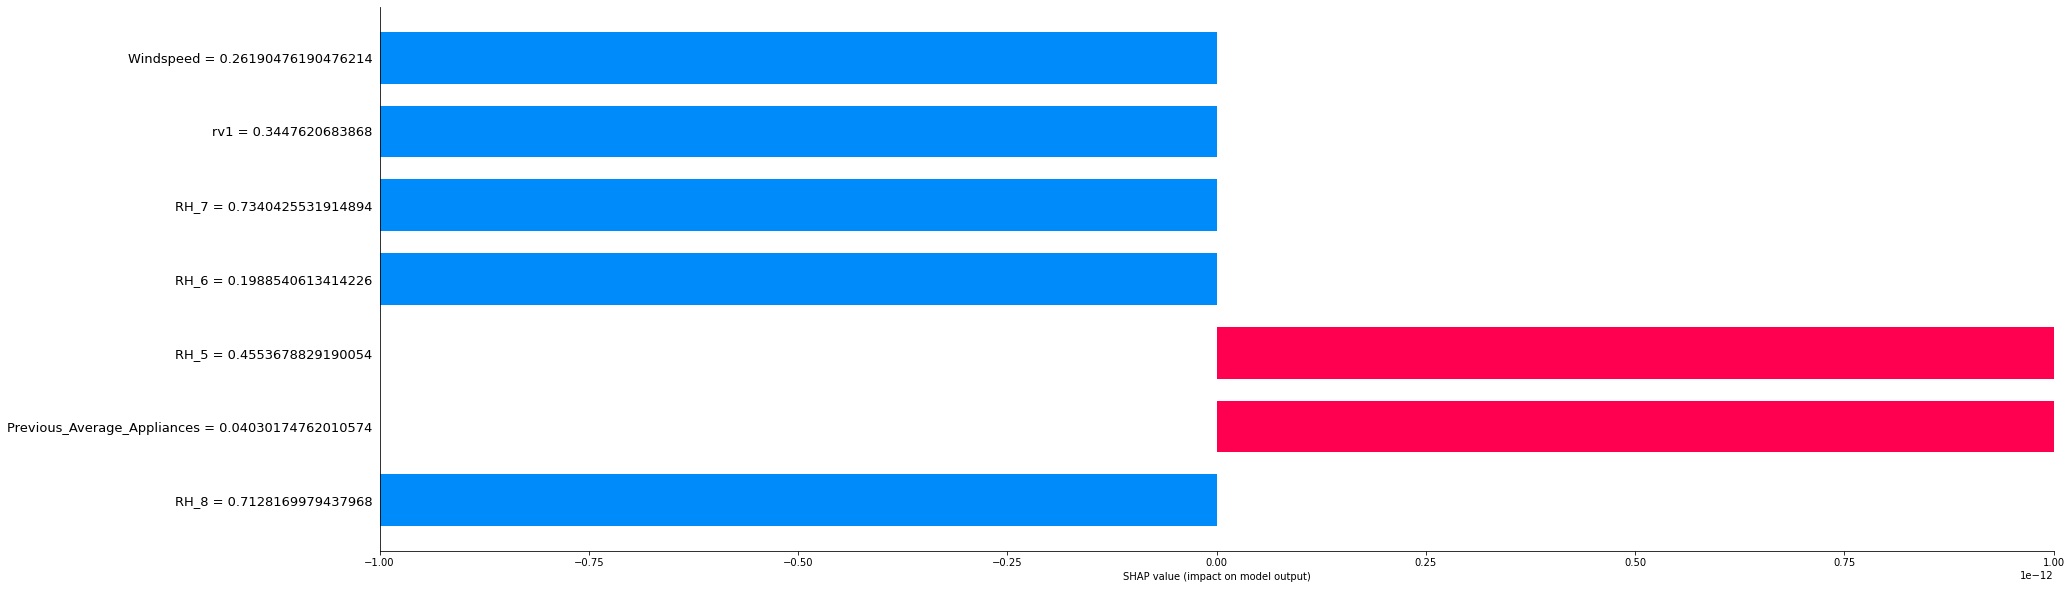

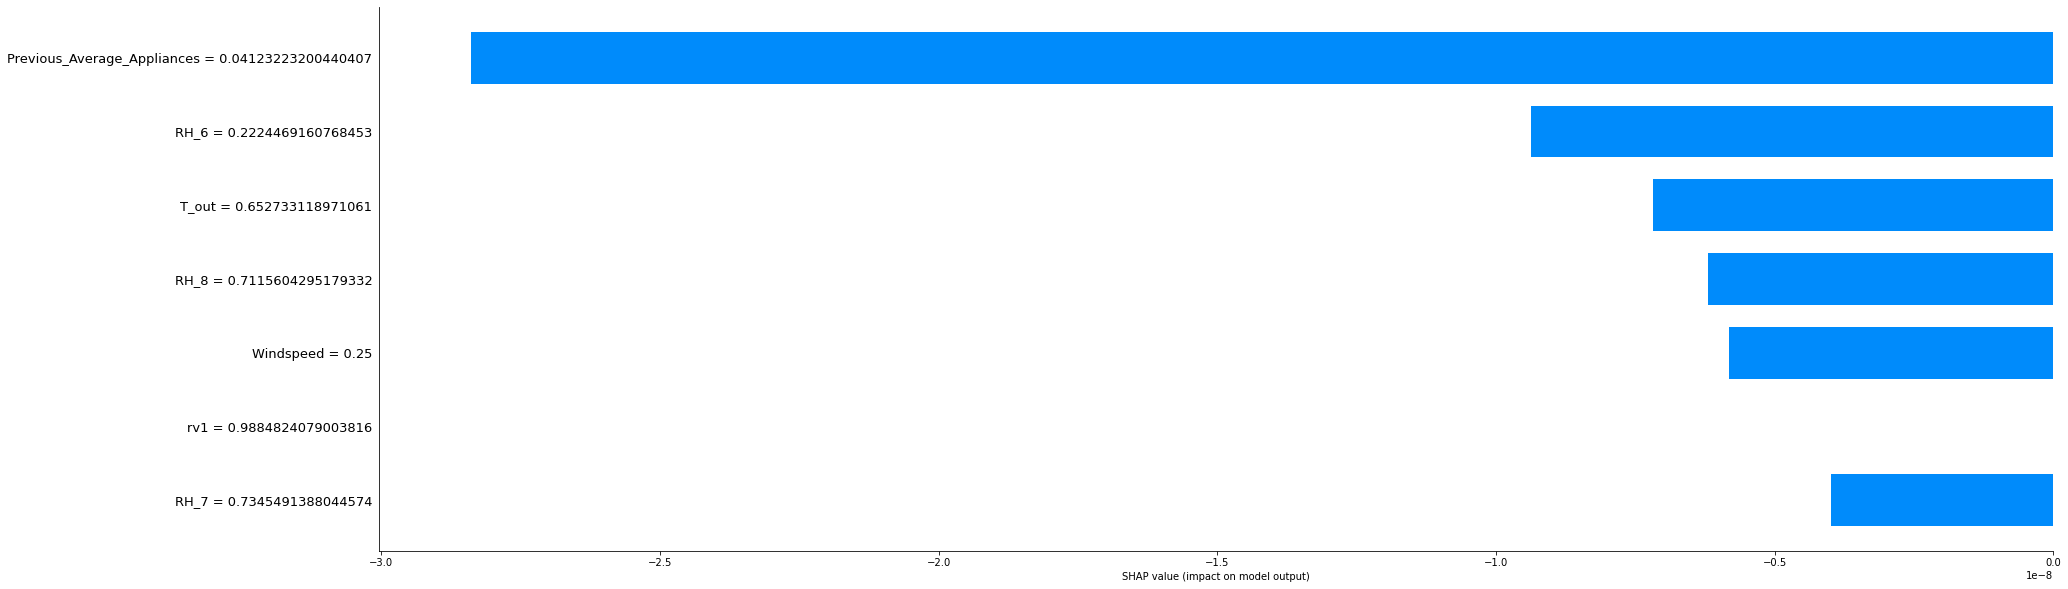

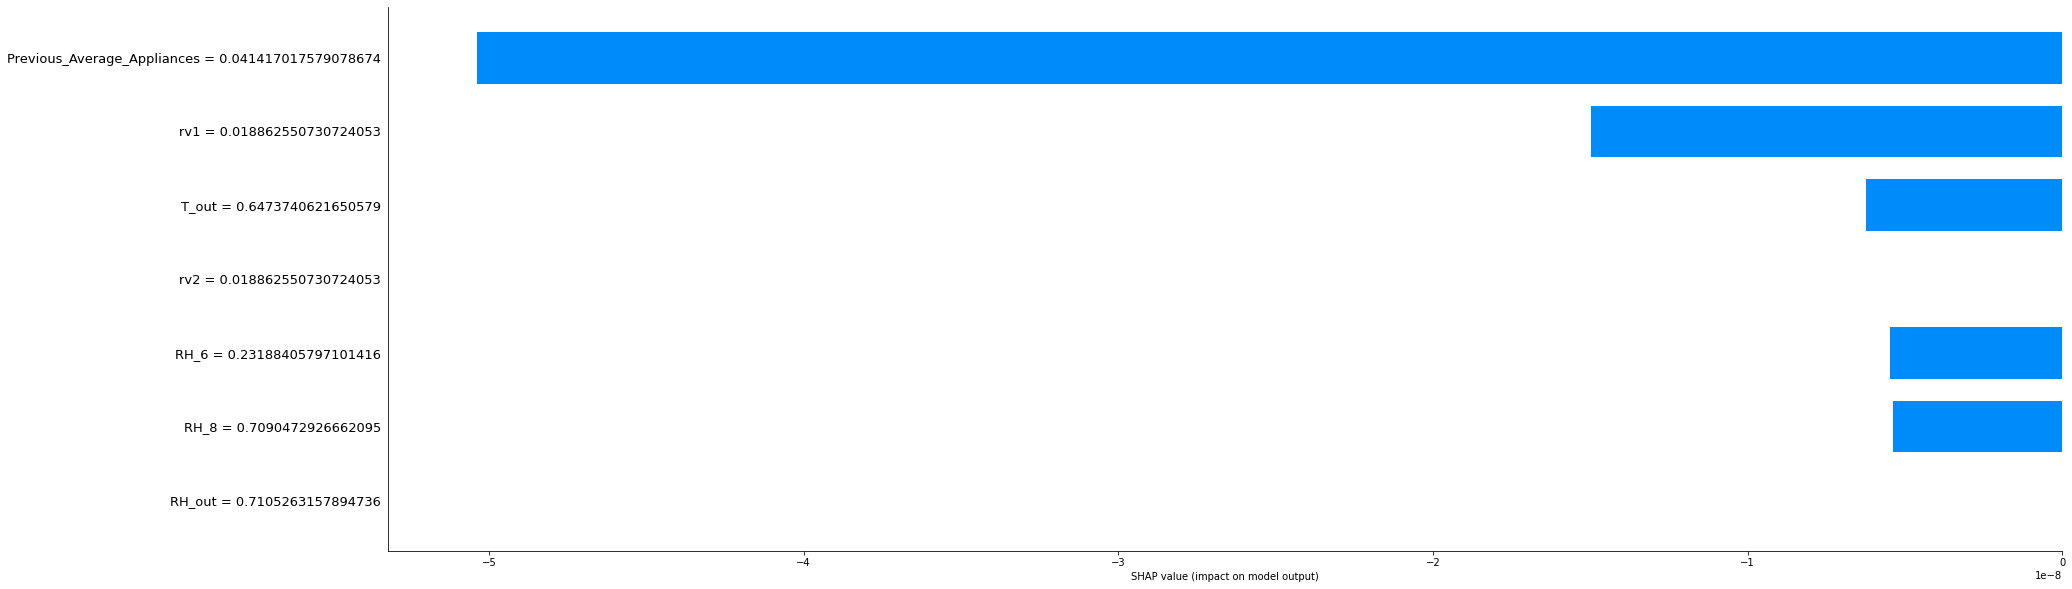

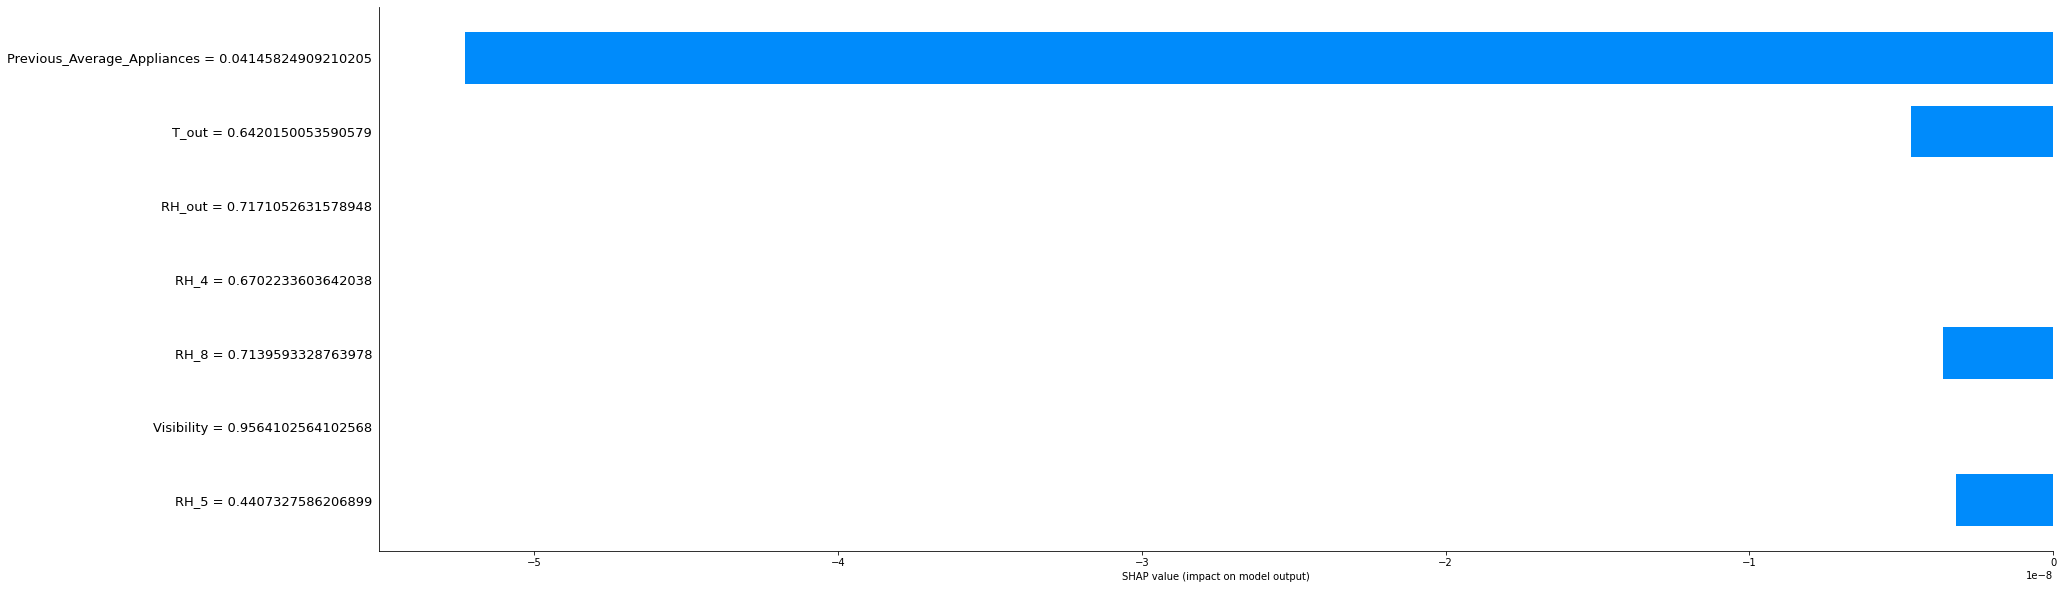

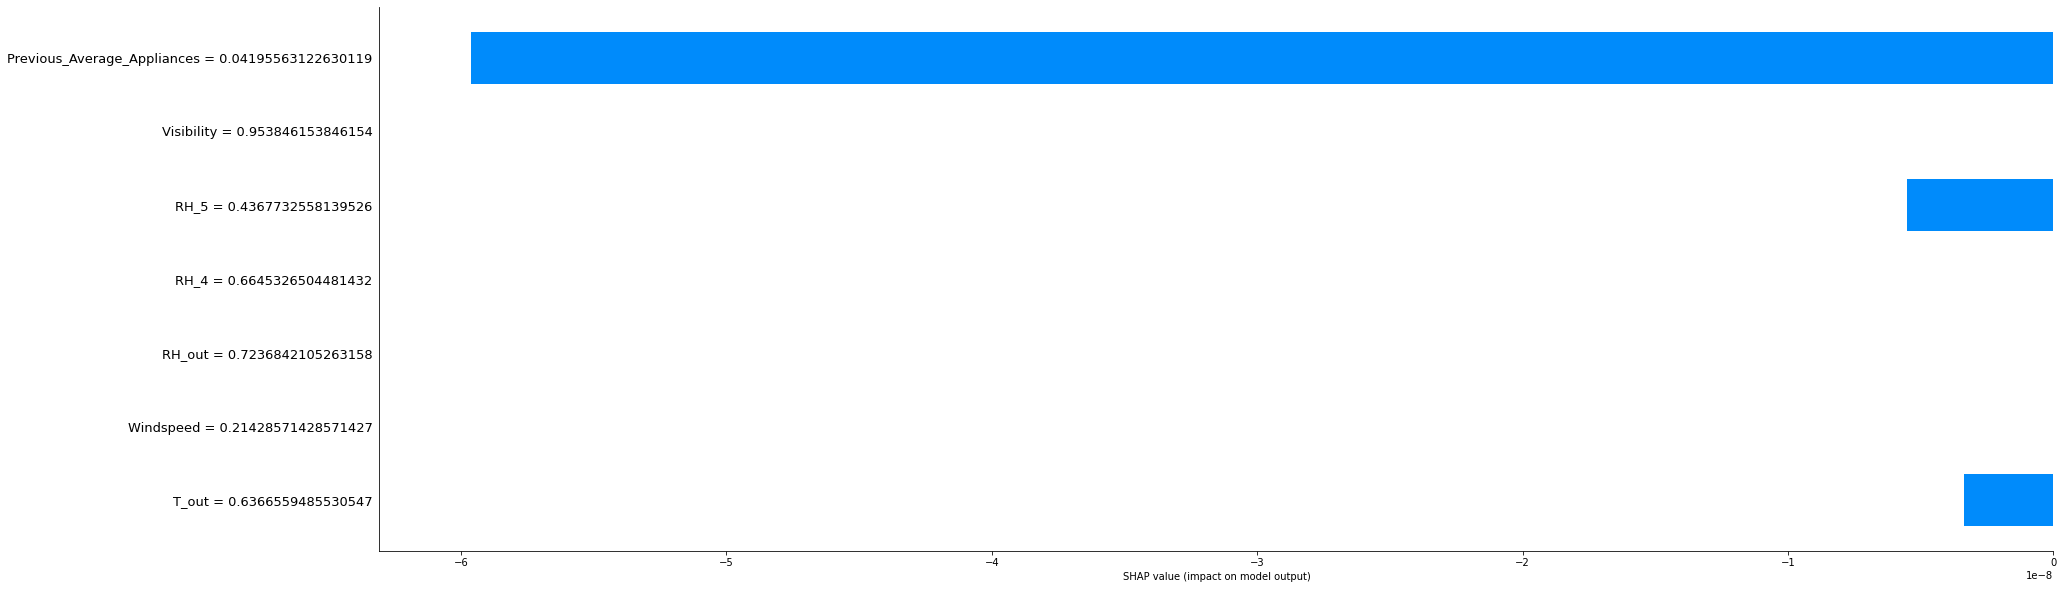

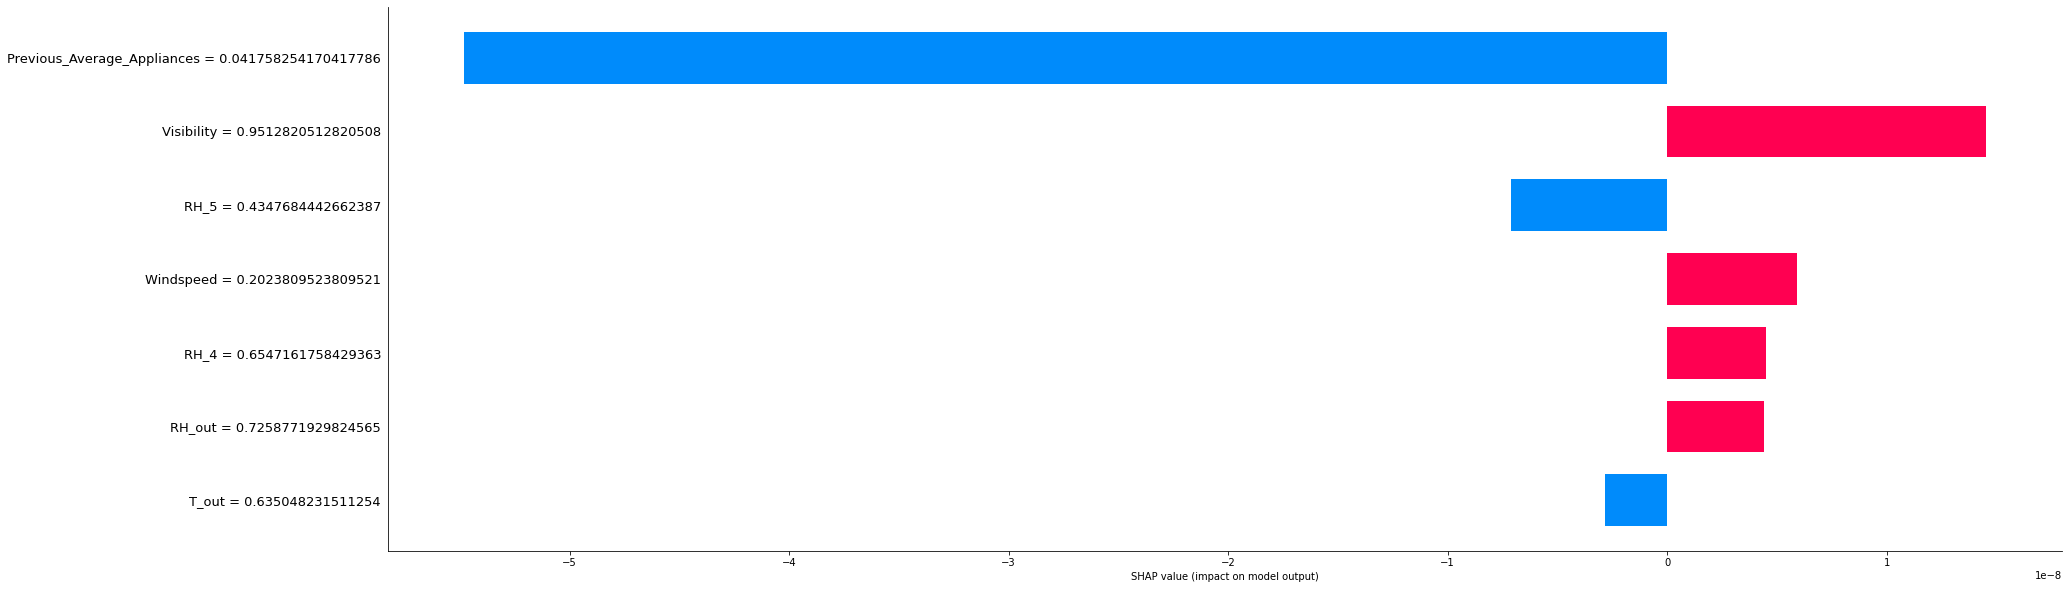

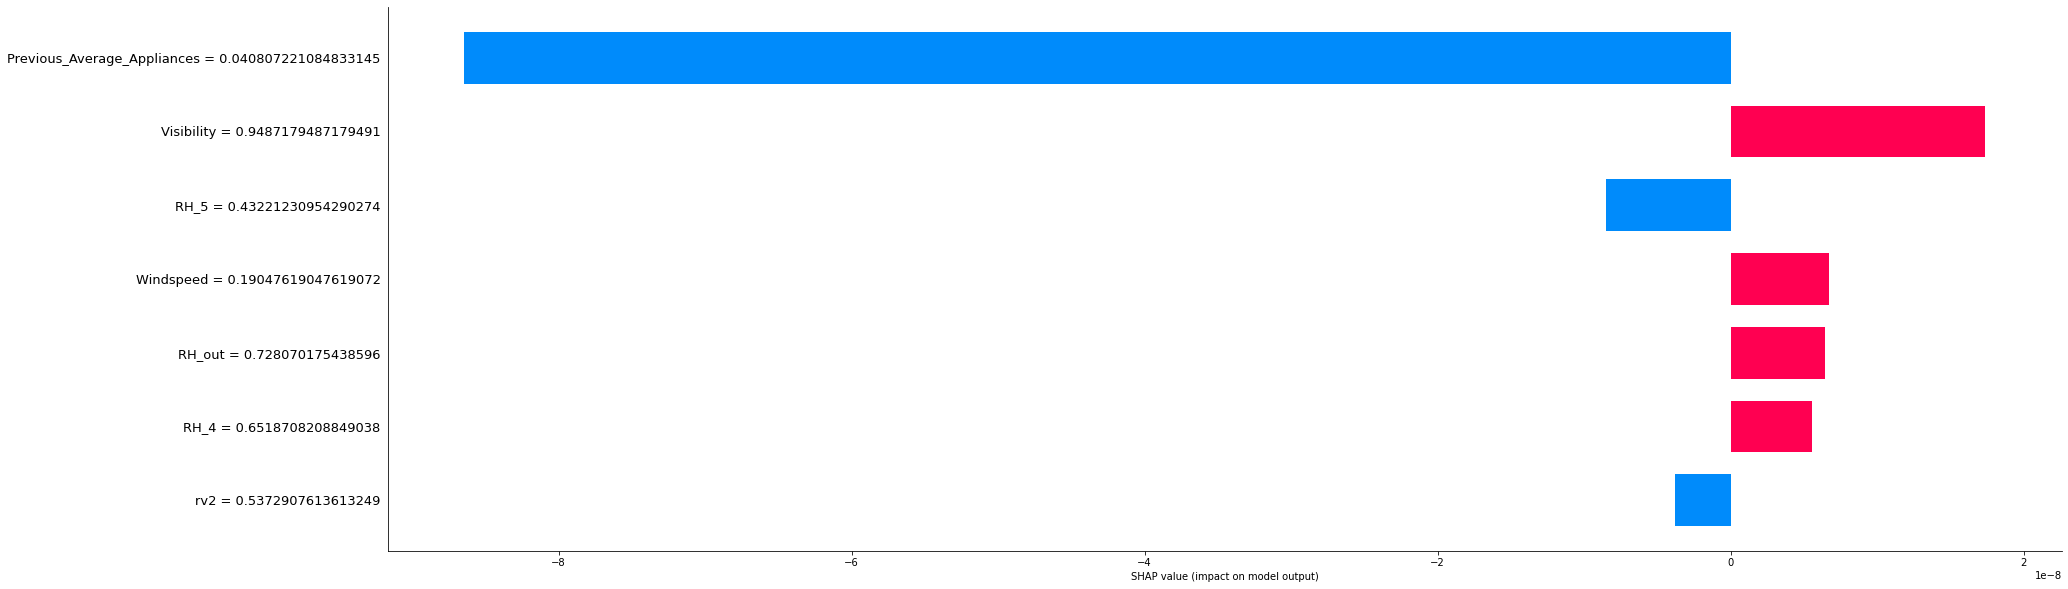

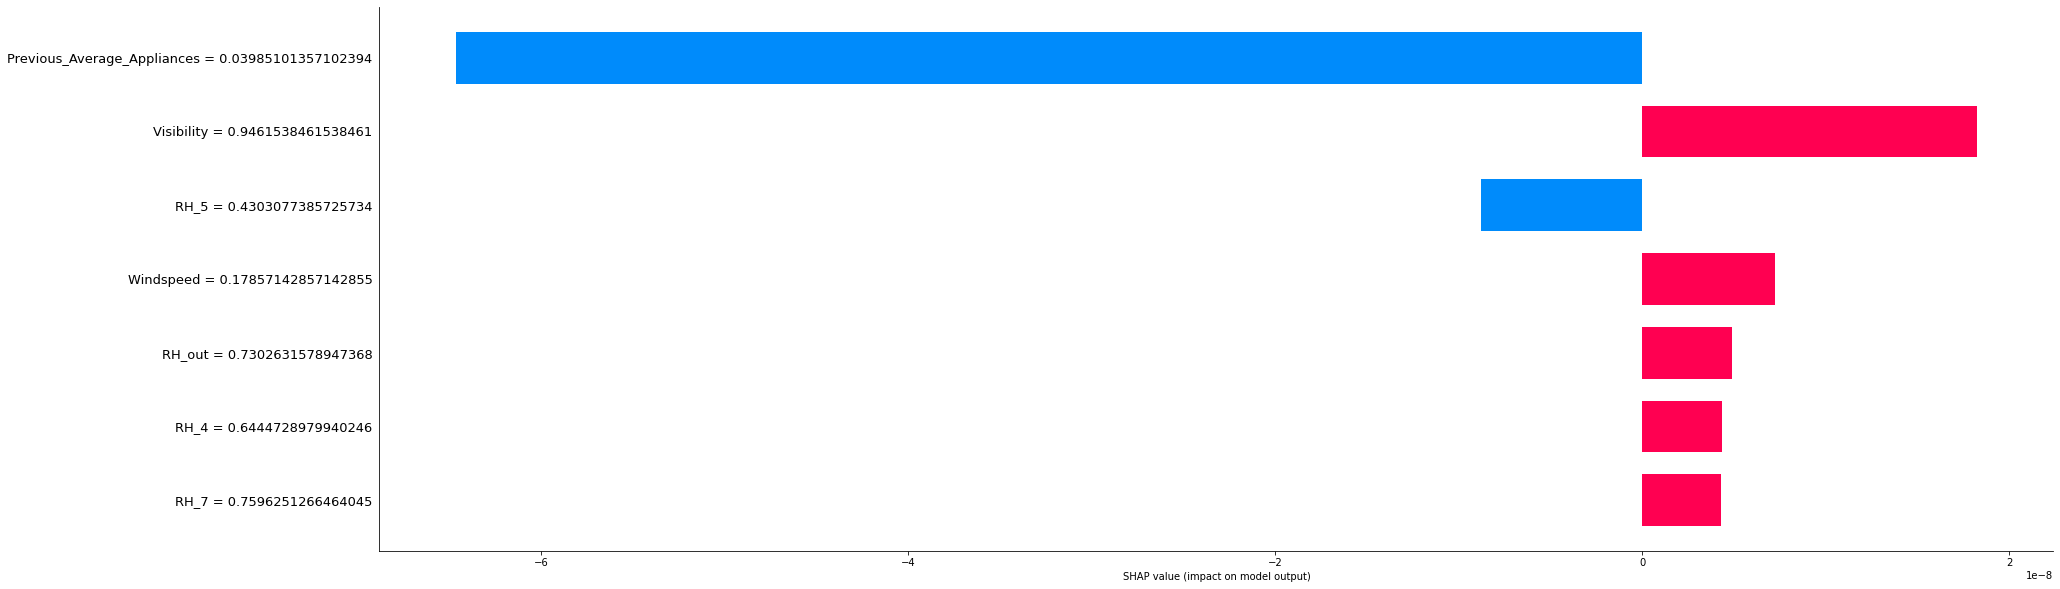

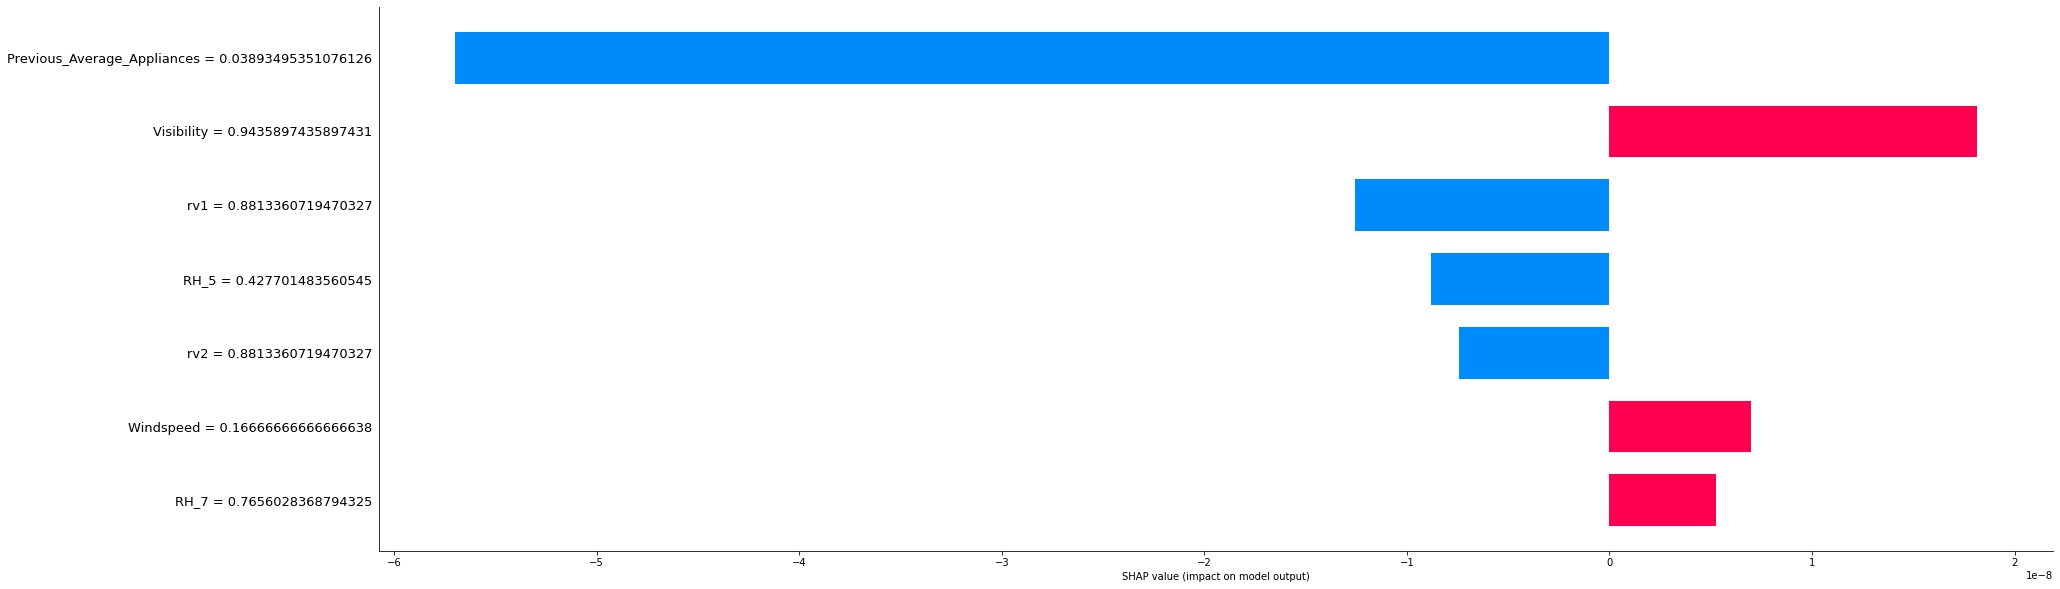

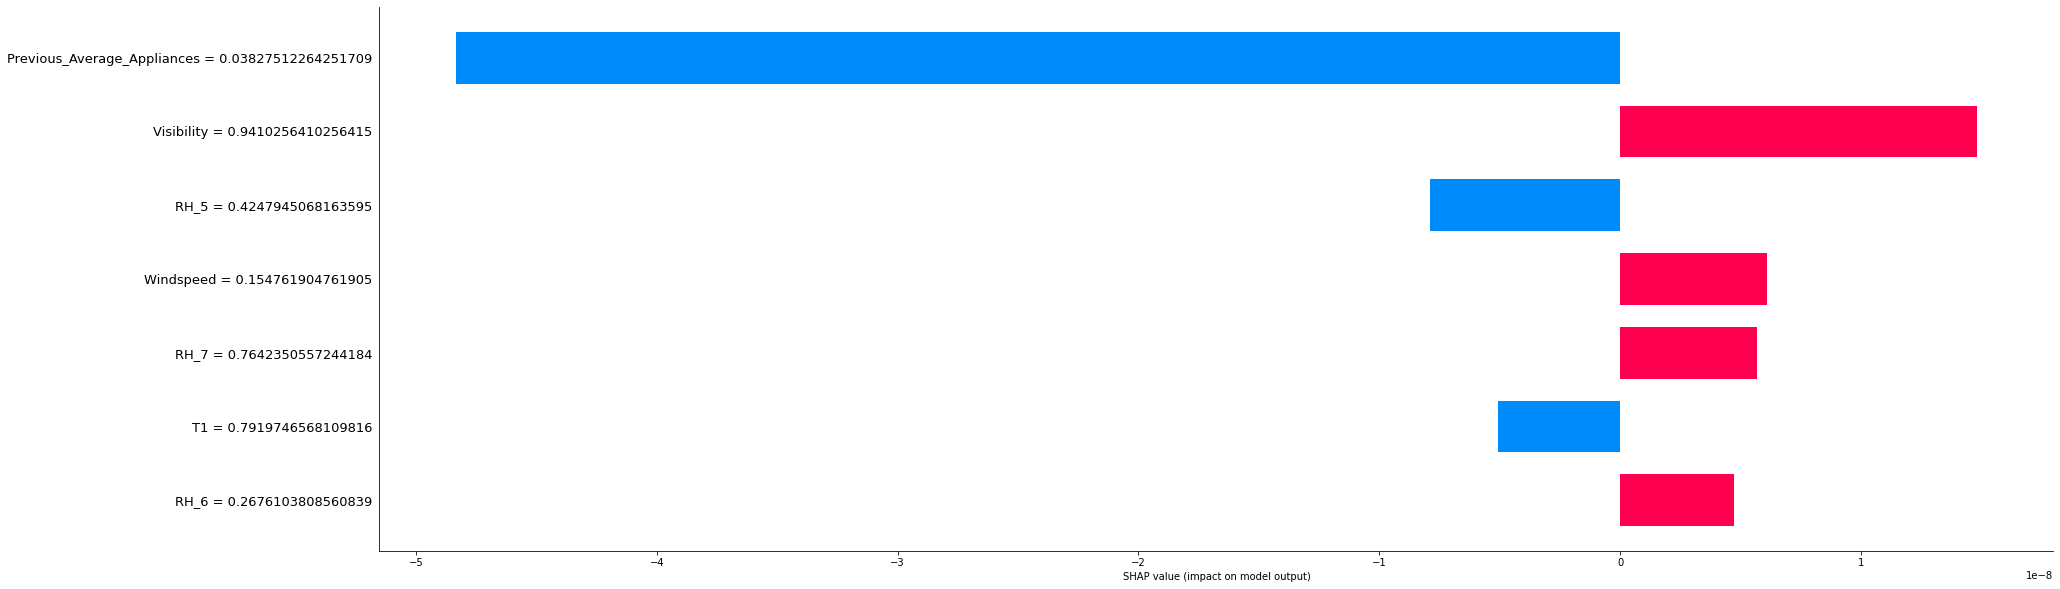

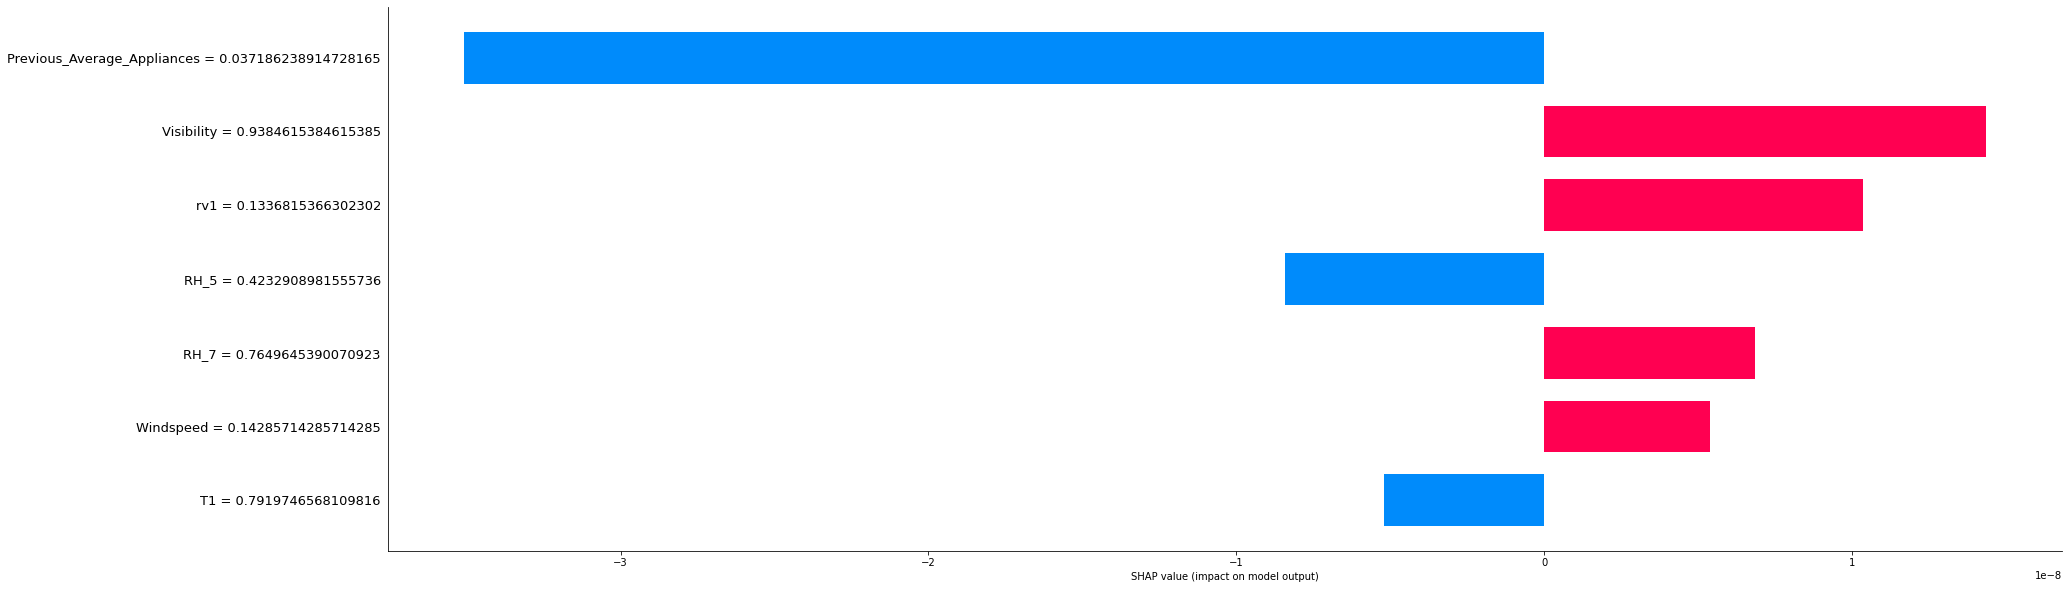

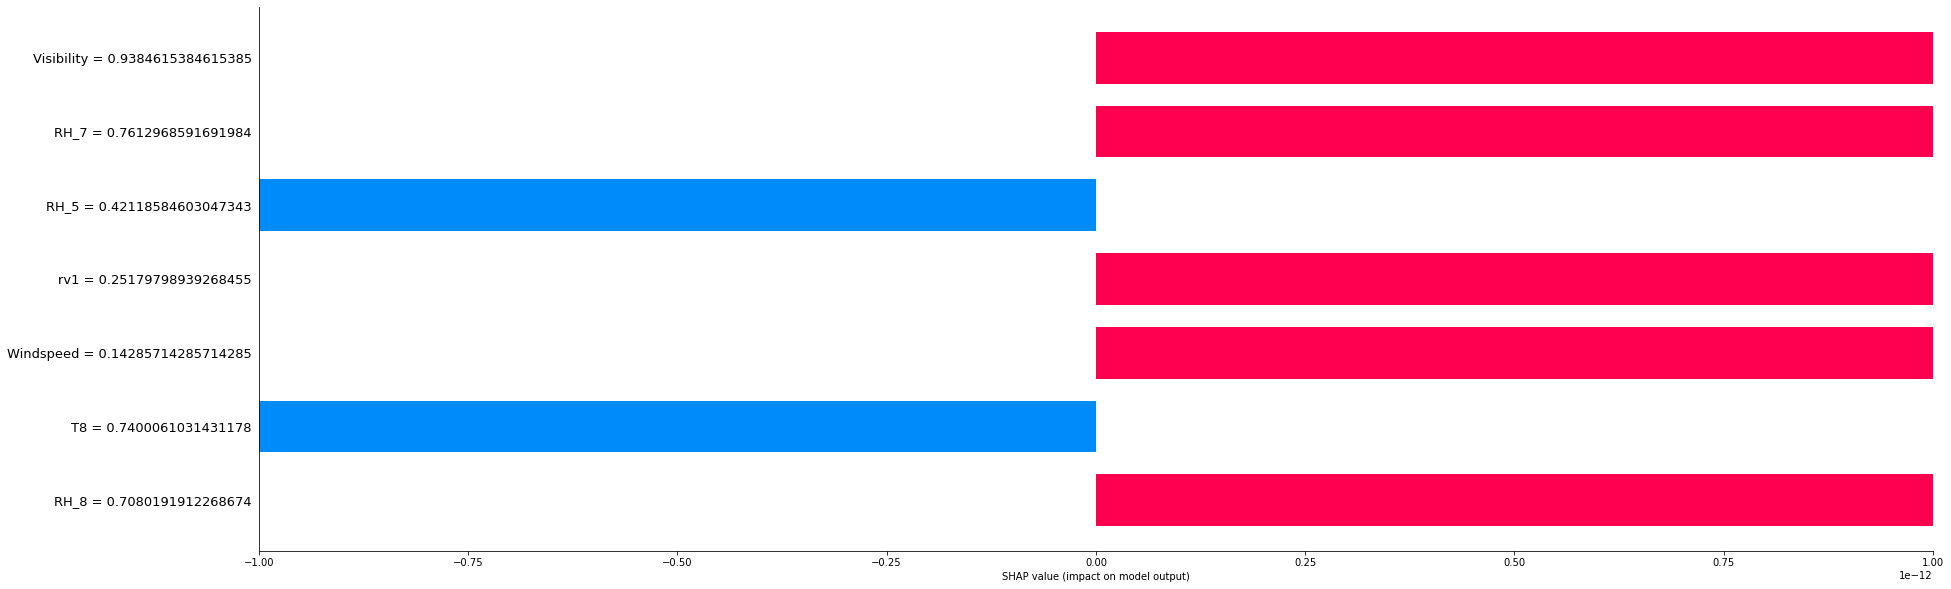

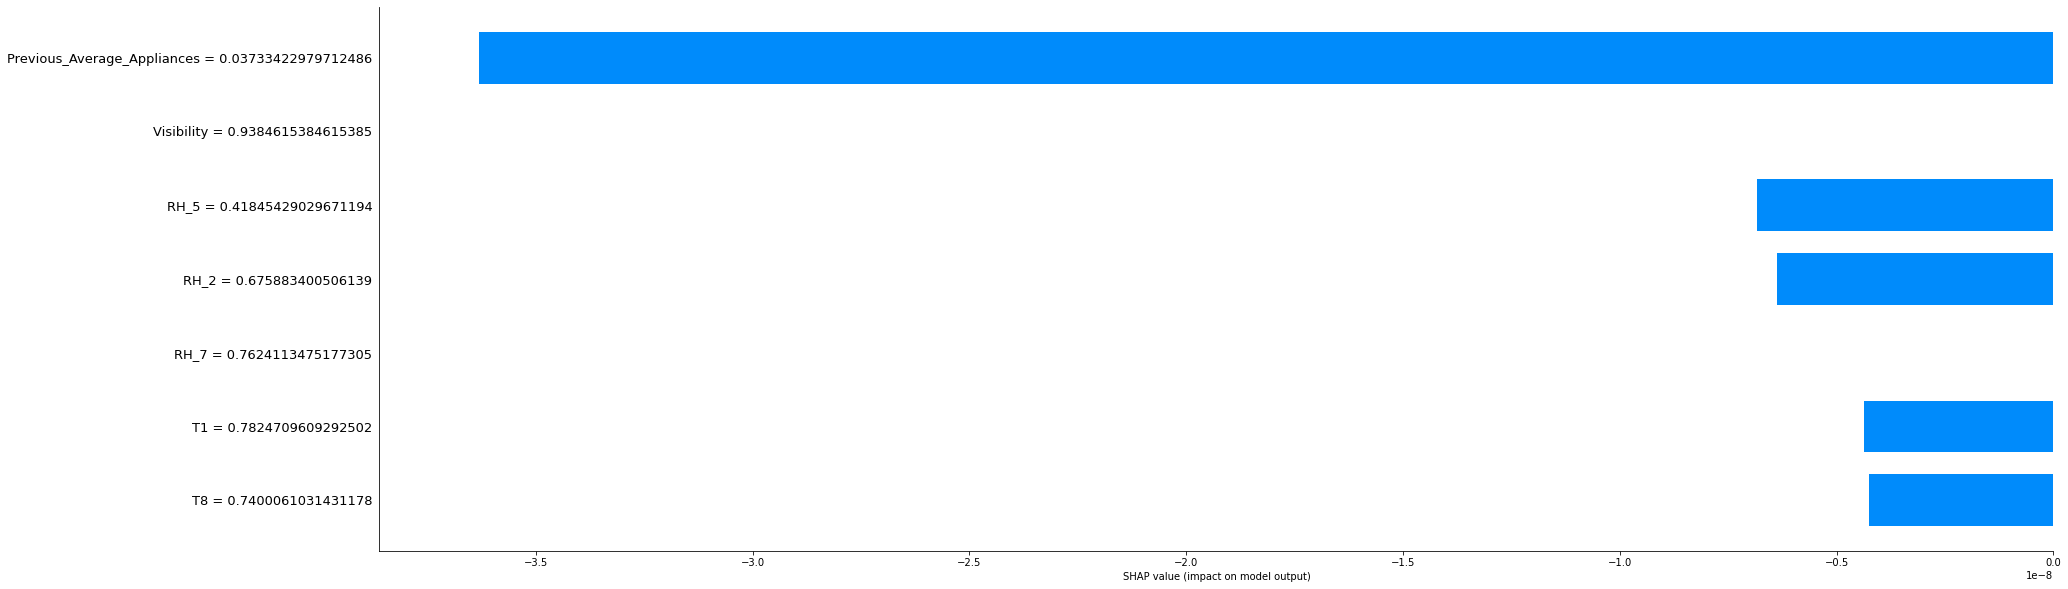

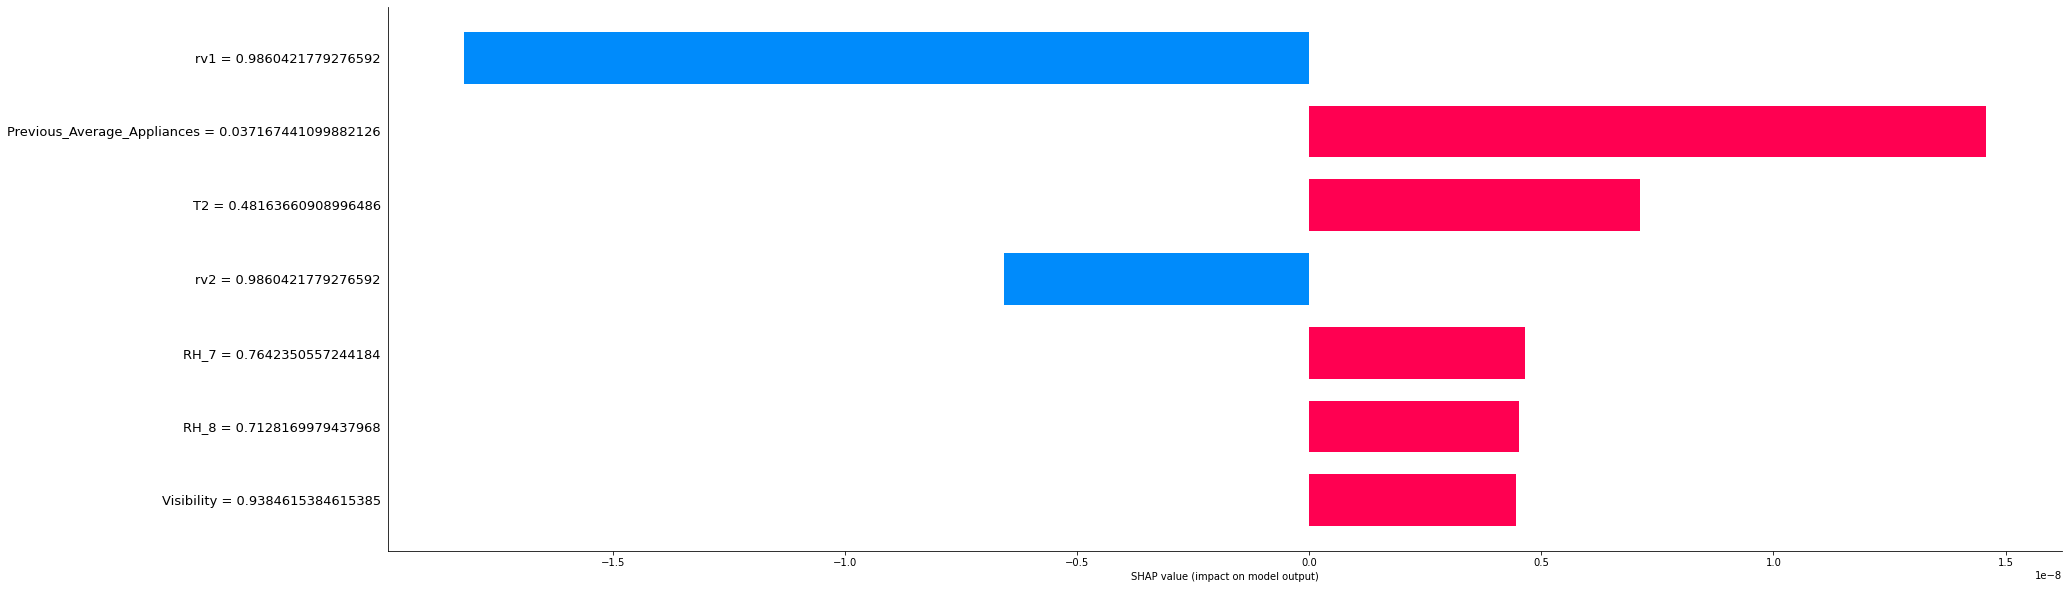

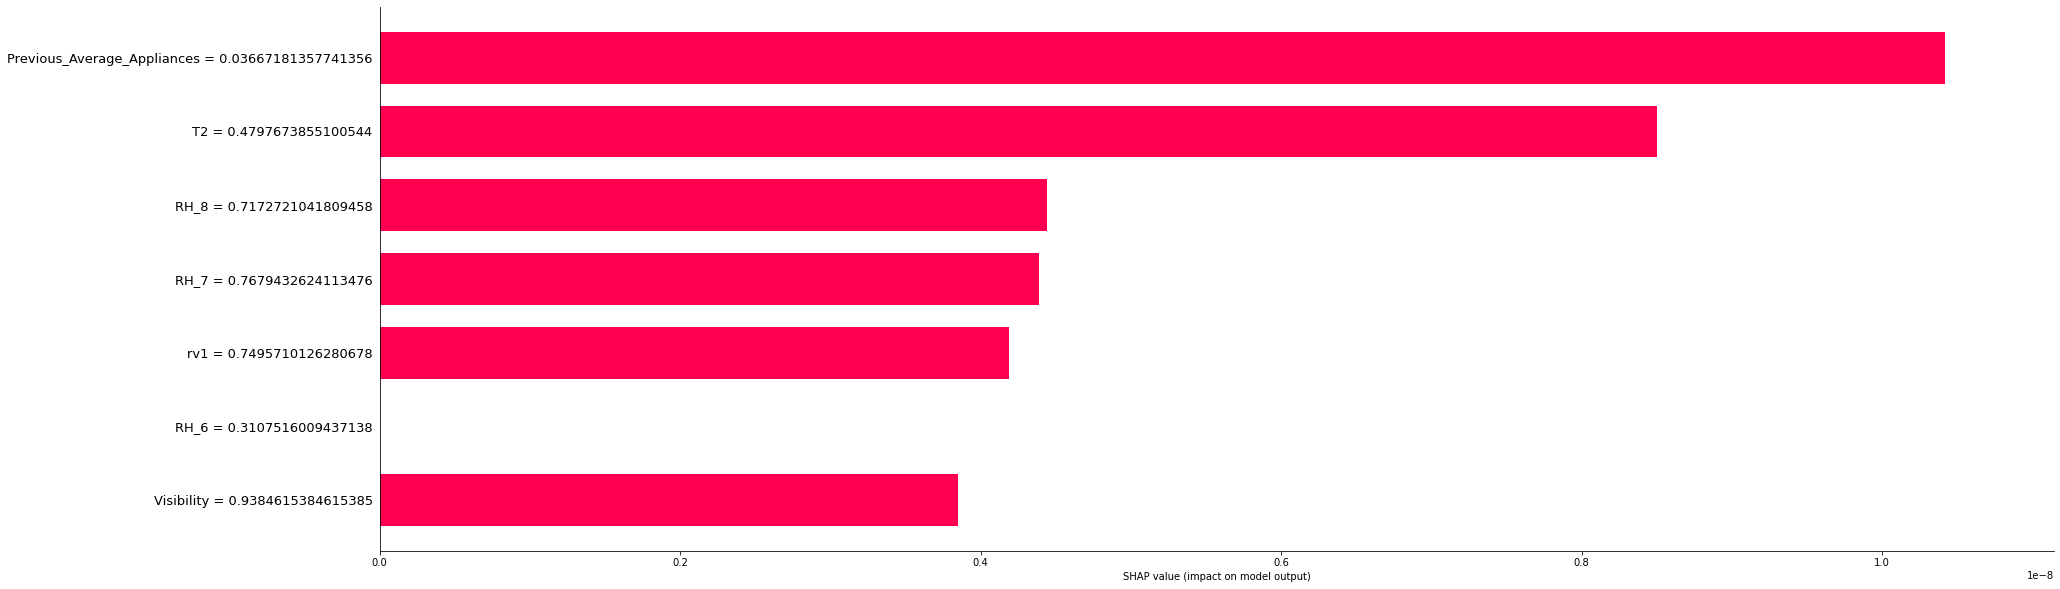

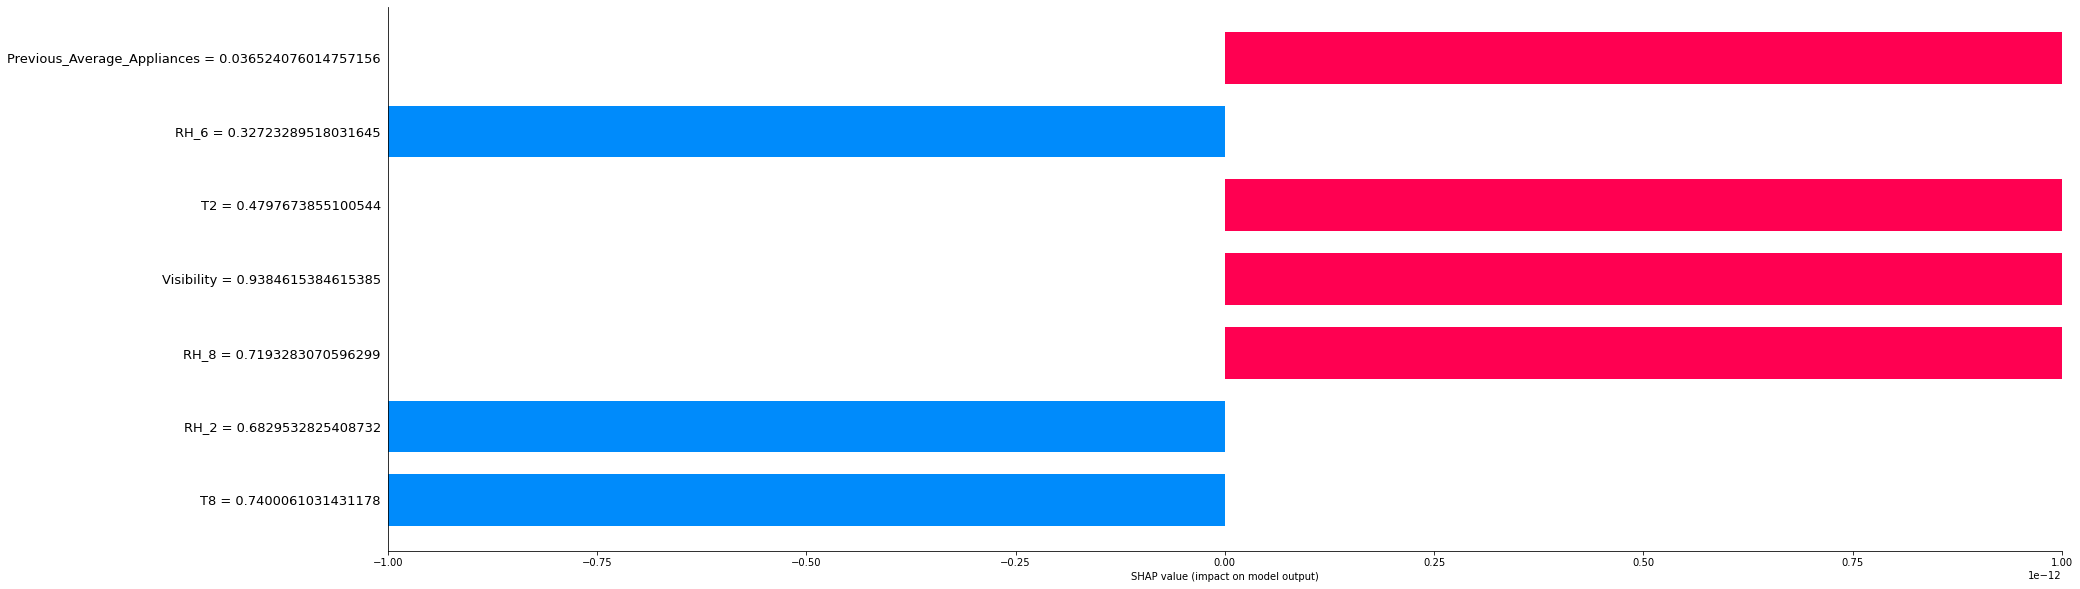

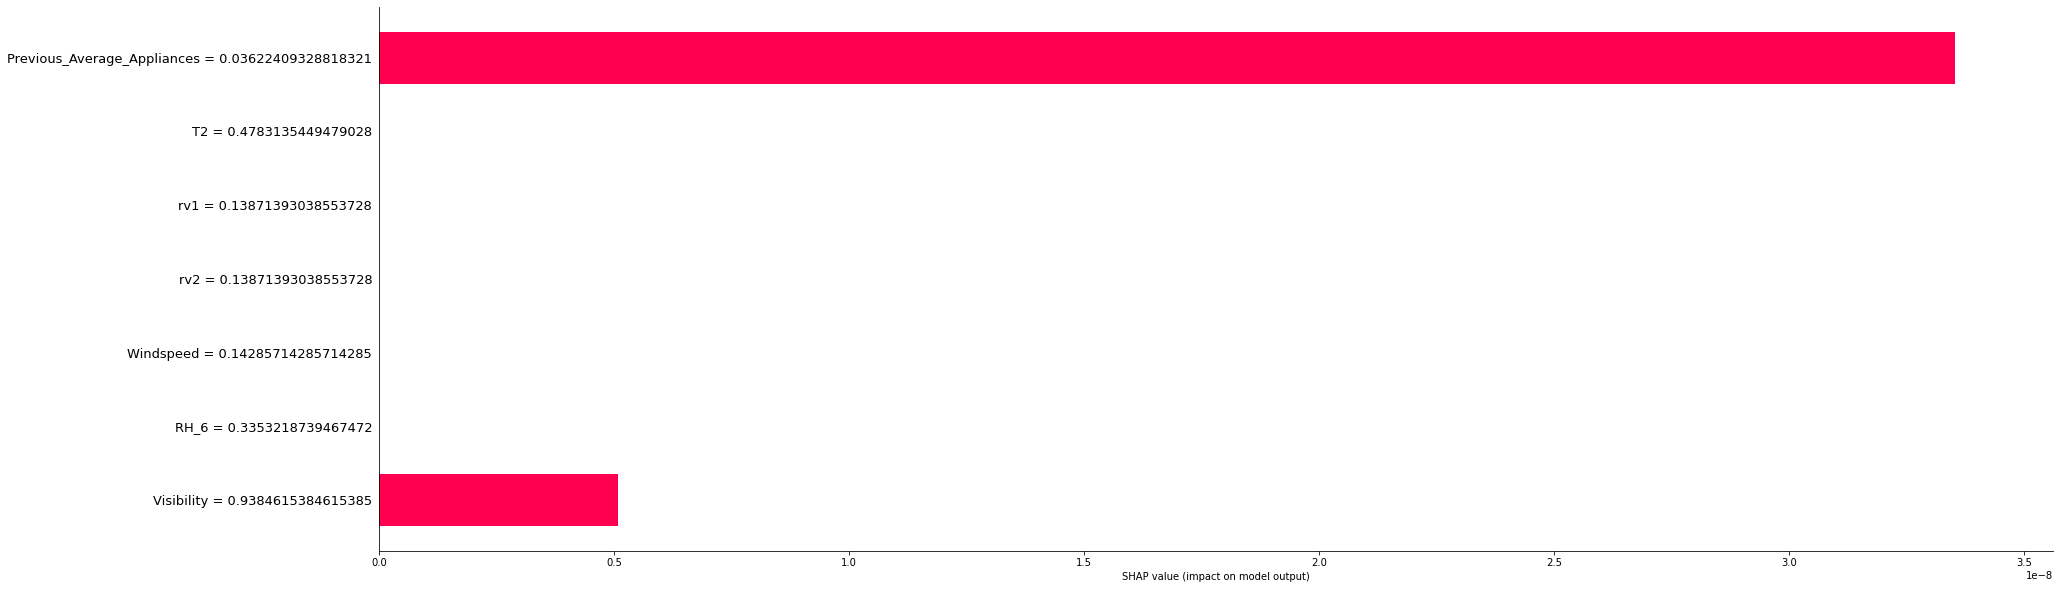

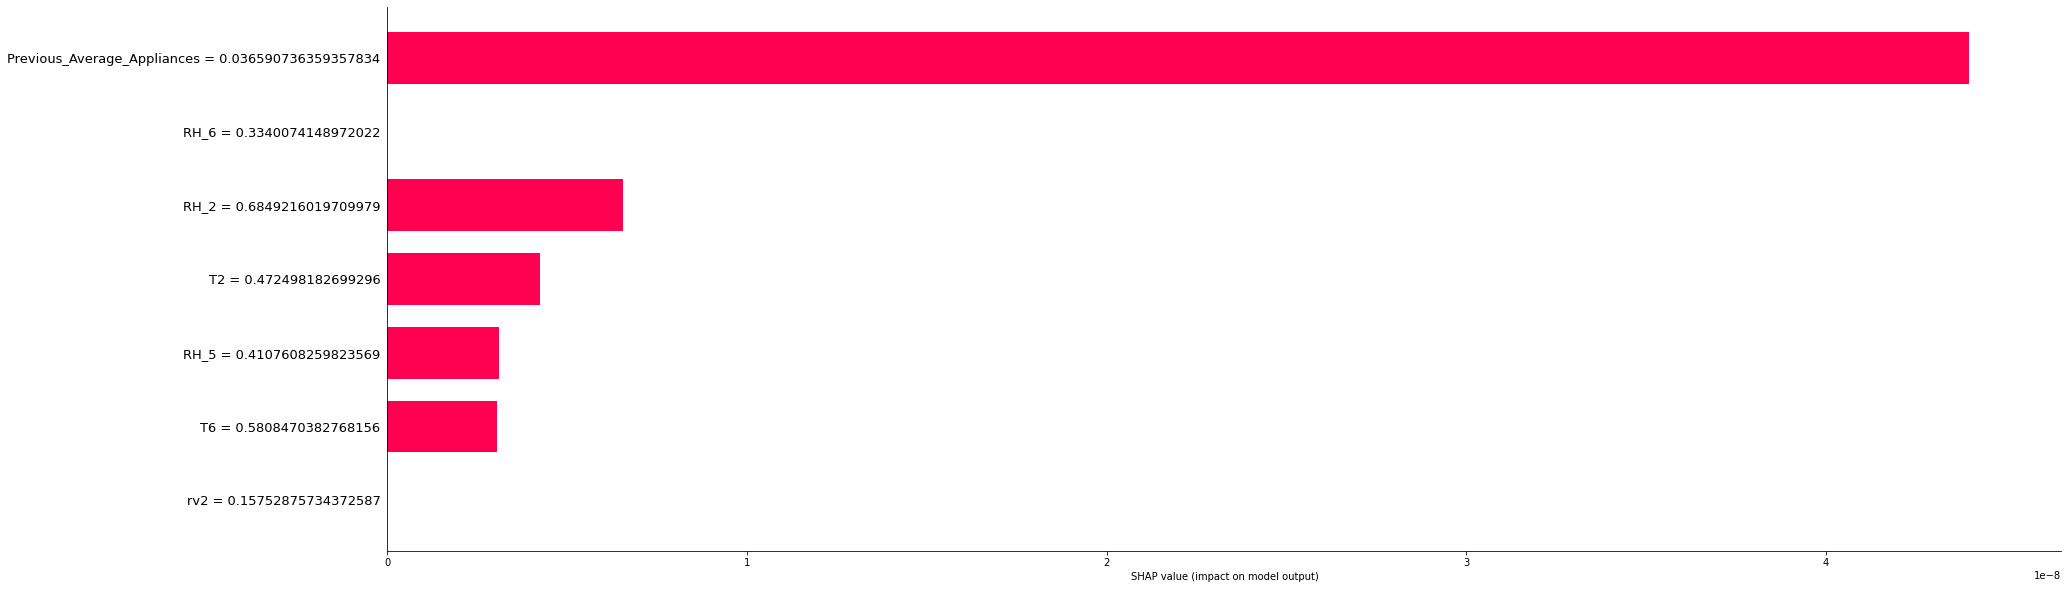

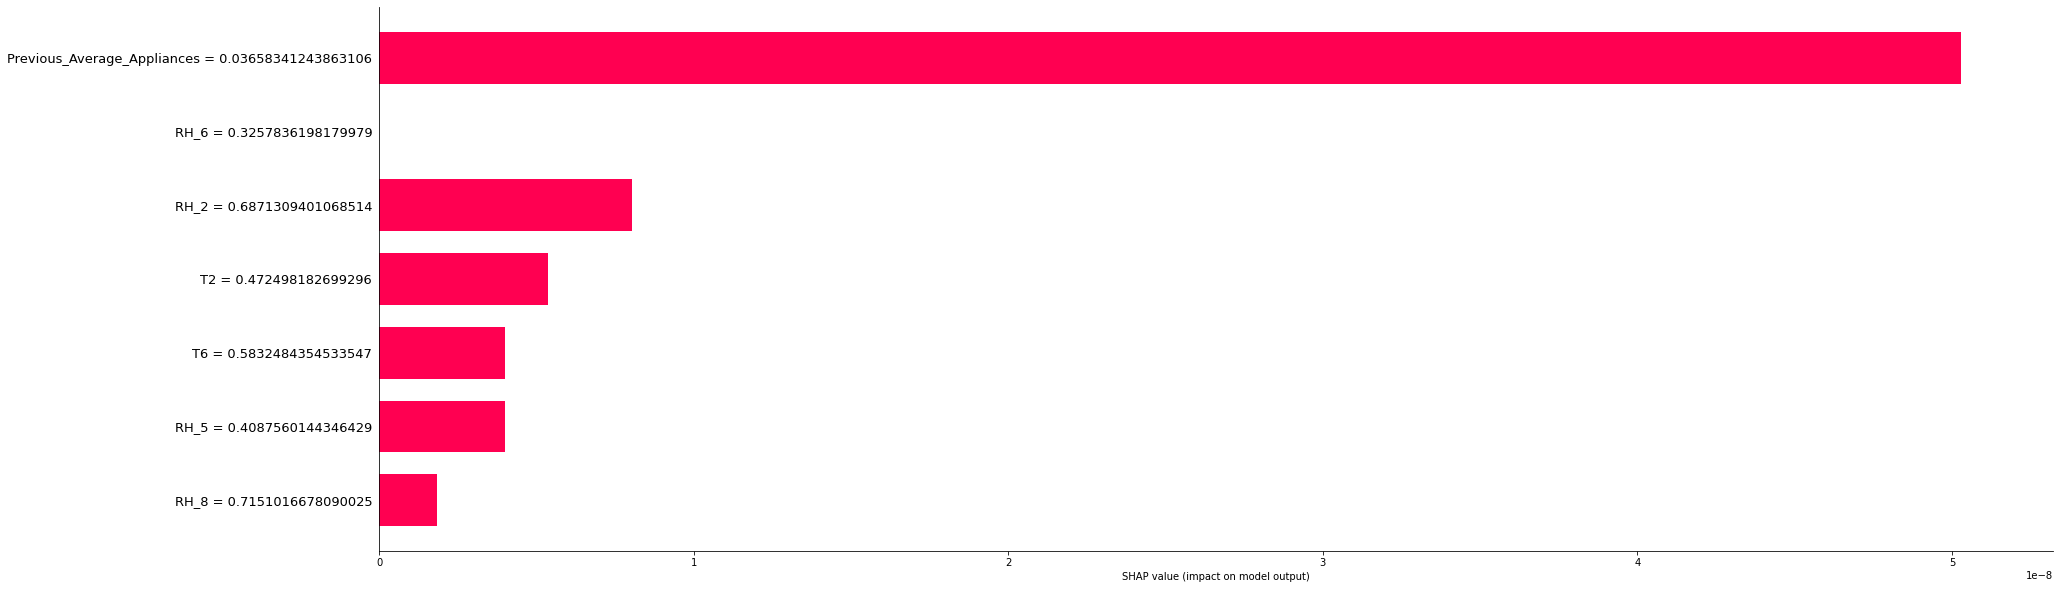

In [ ]:
test_df = inference_data[-n_inputs:]
for i in range(50):
    shap.bar_plot(new_shap_values[i], test_df[i], features) 

**shap.waterfall_plot()**

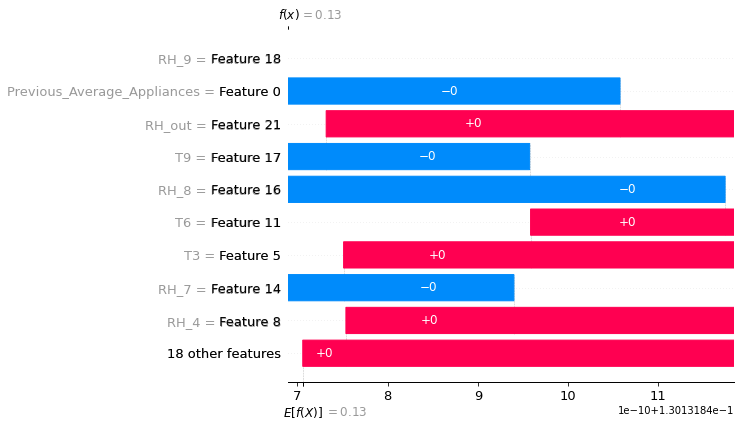

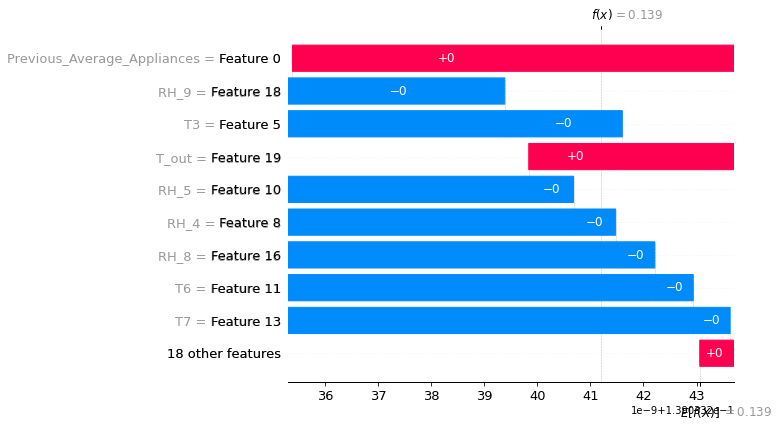

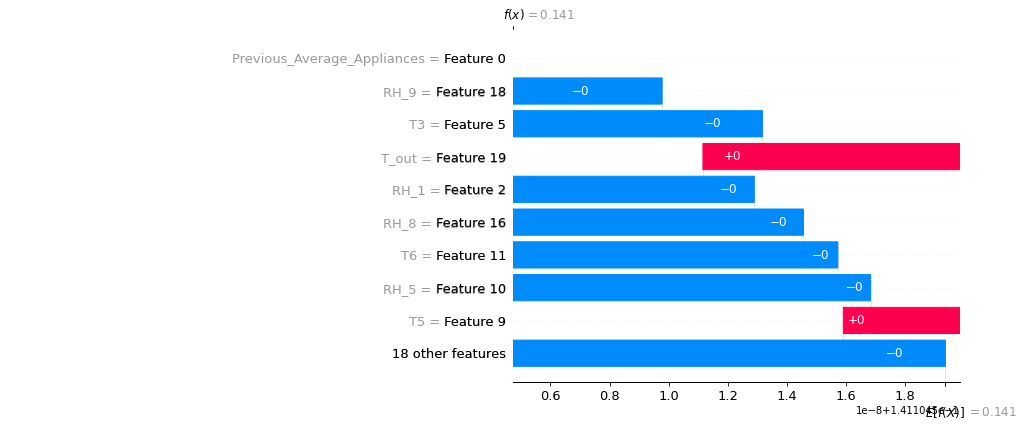

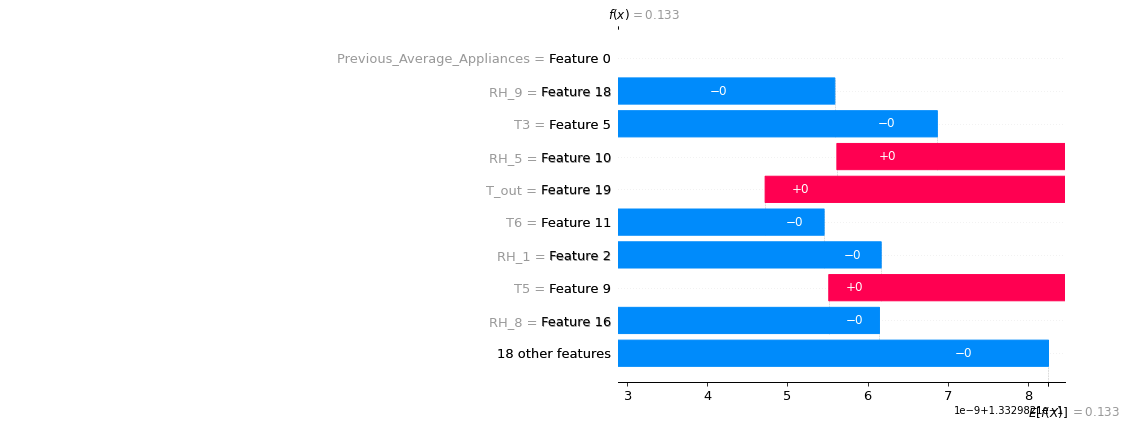

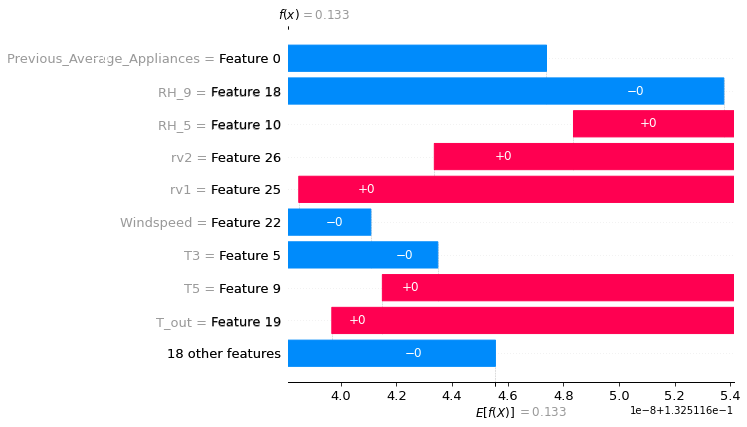

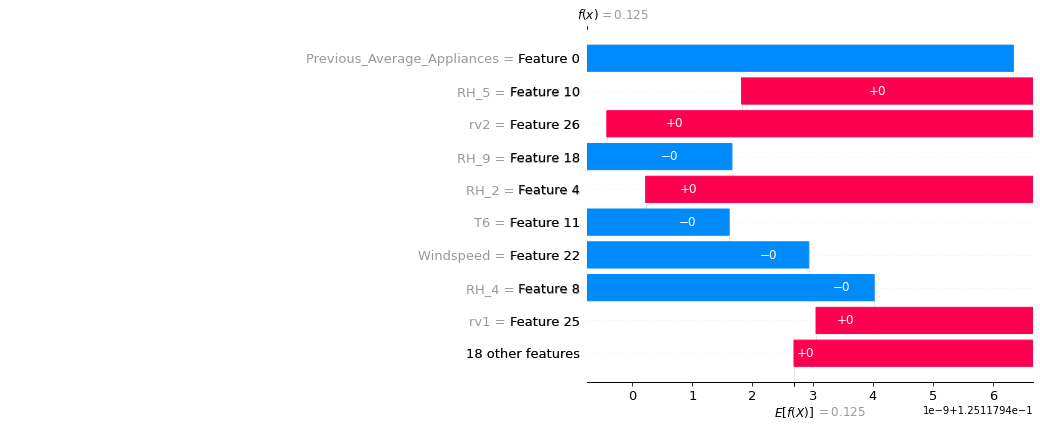

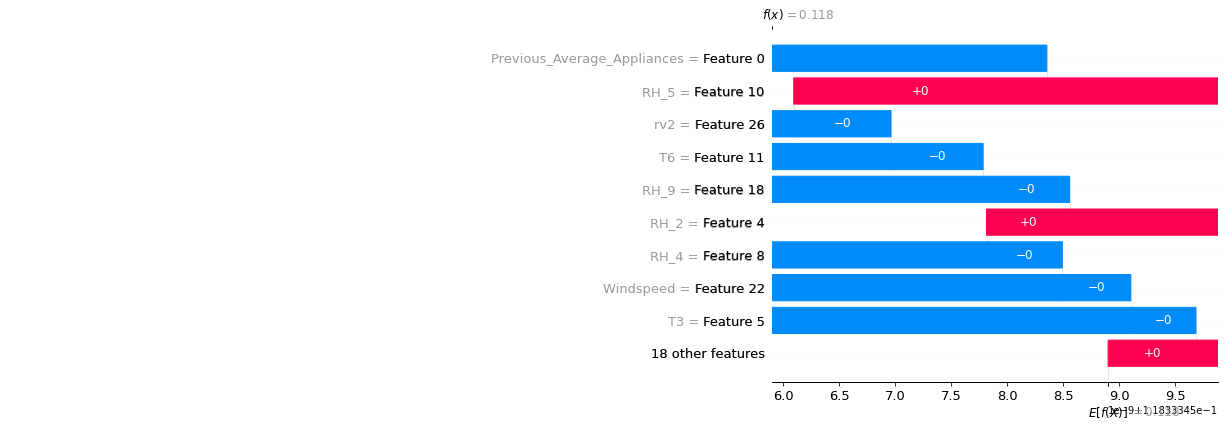

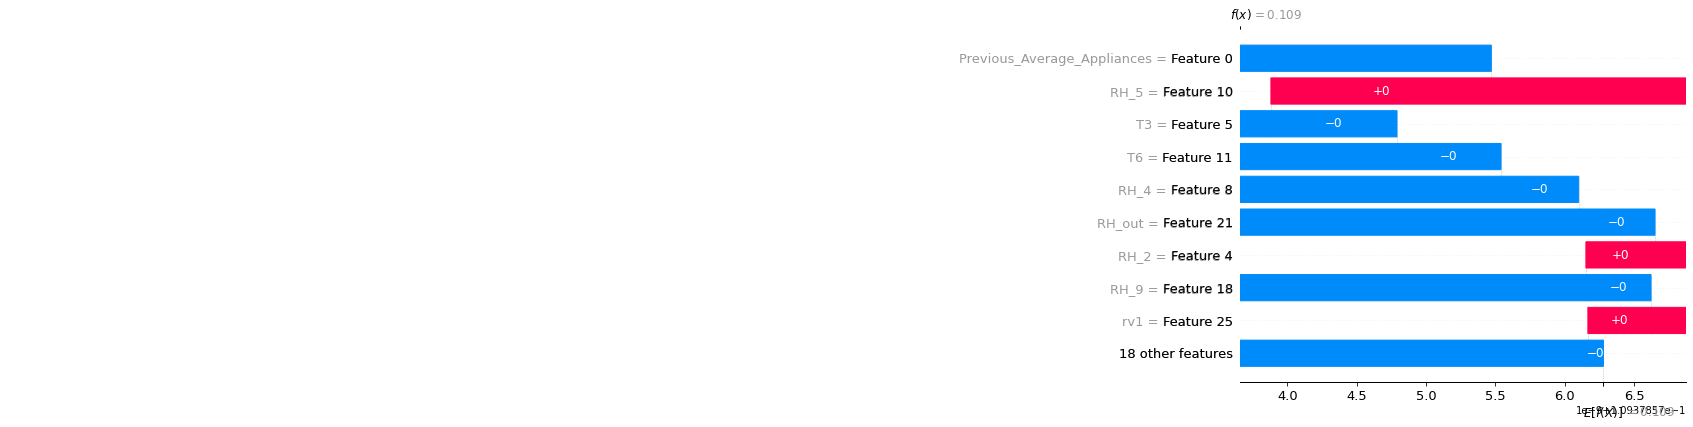

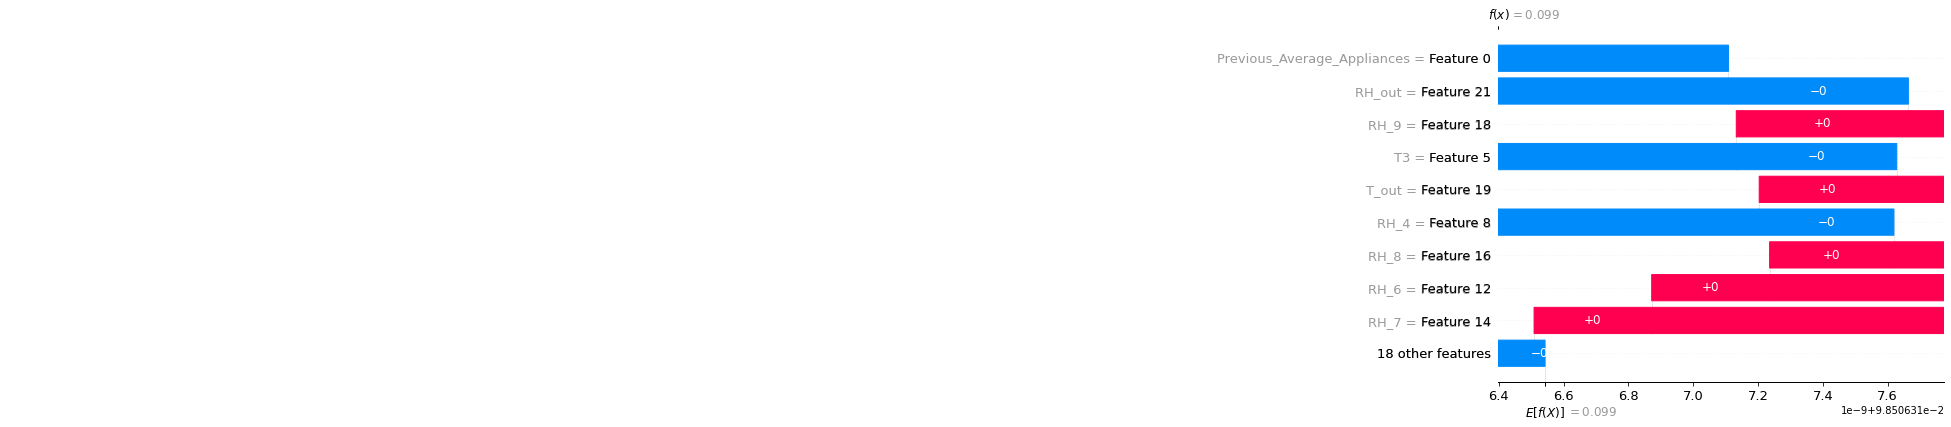

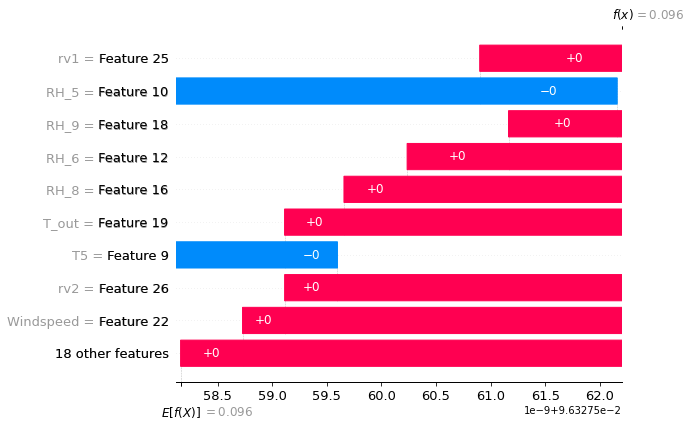

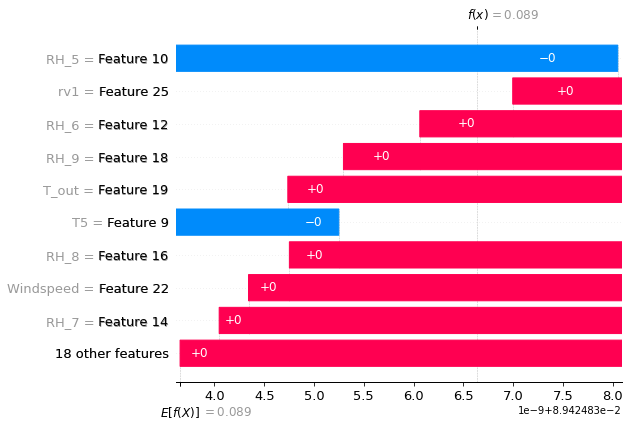

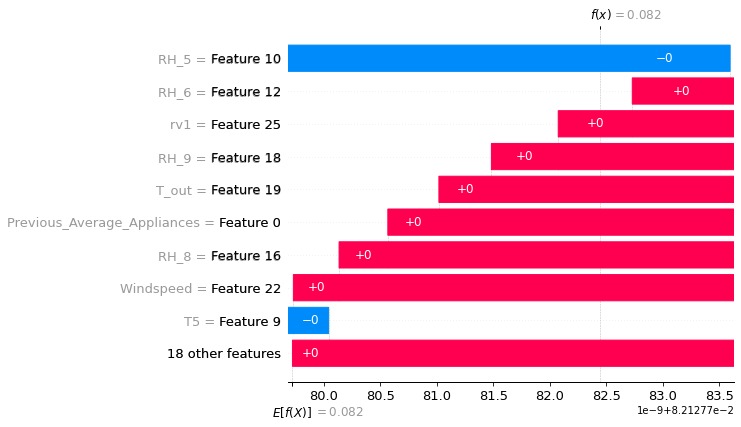

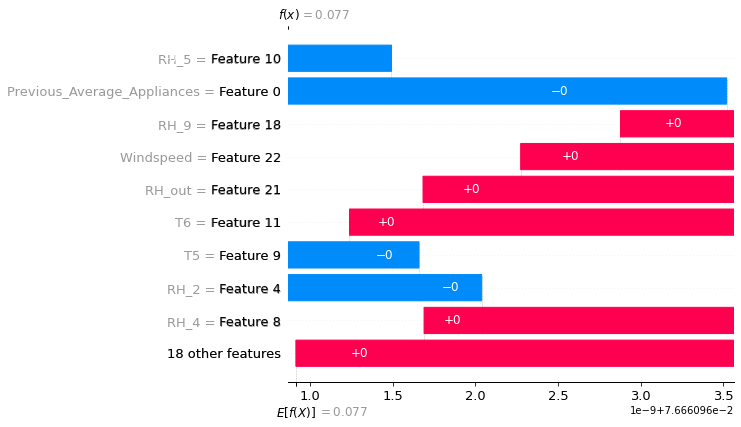

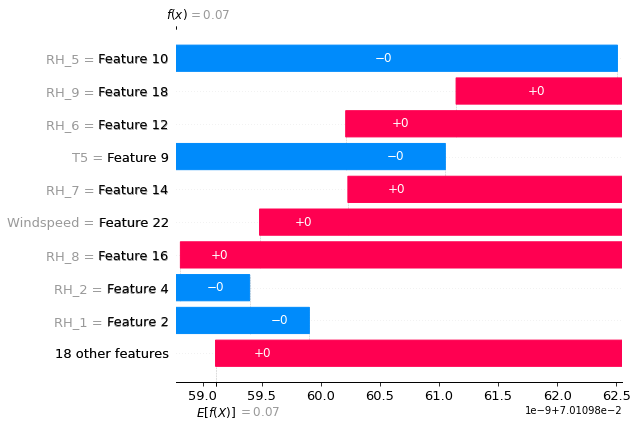

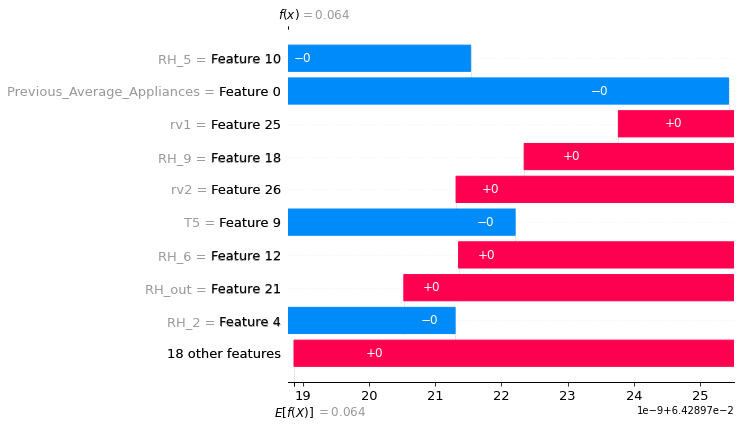

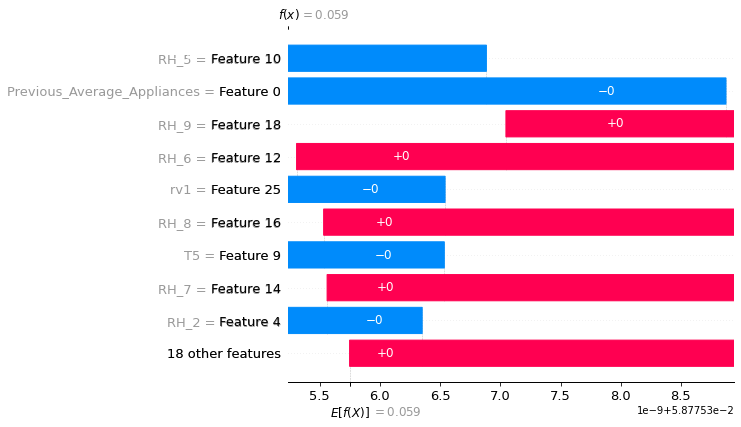

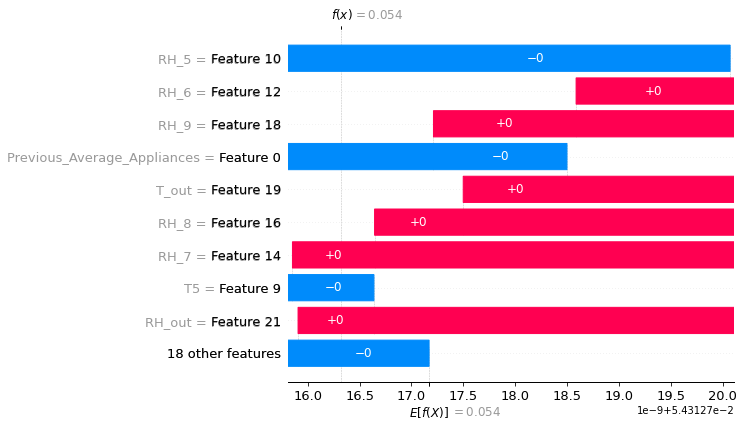

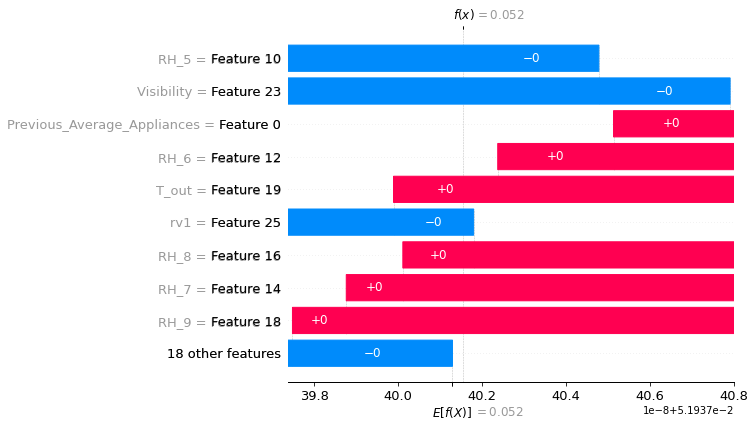

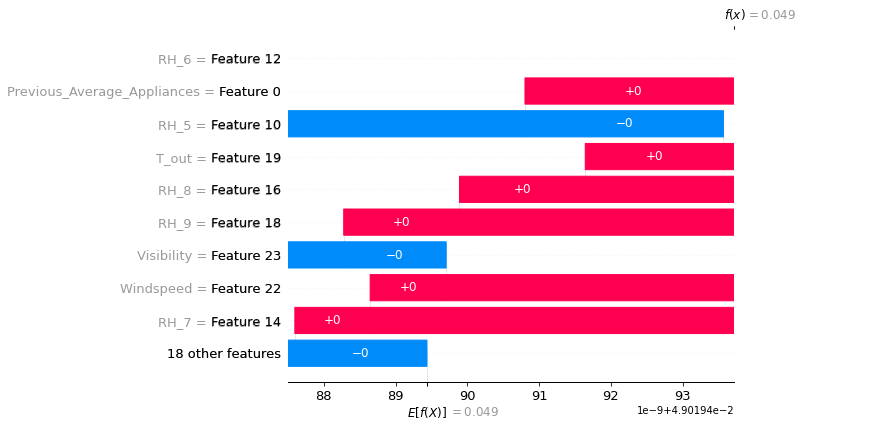

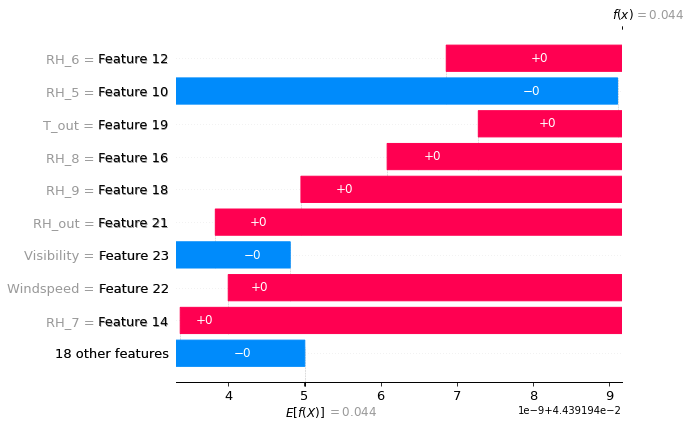

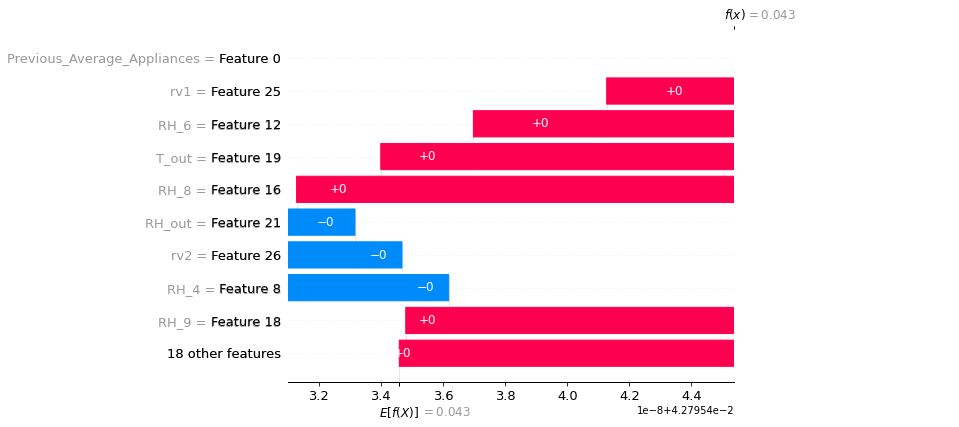

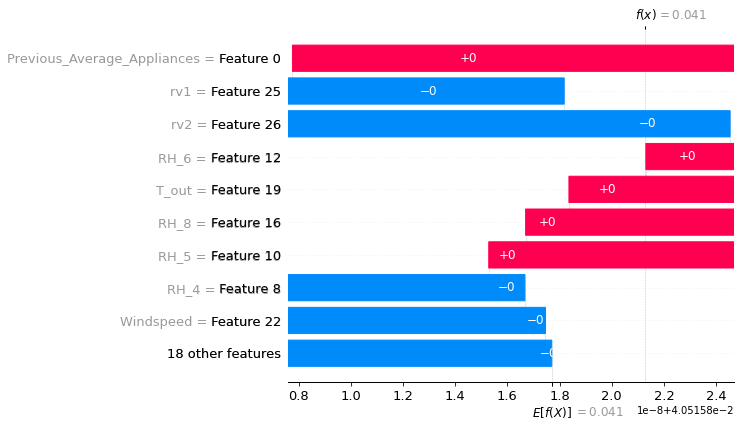

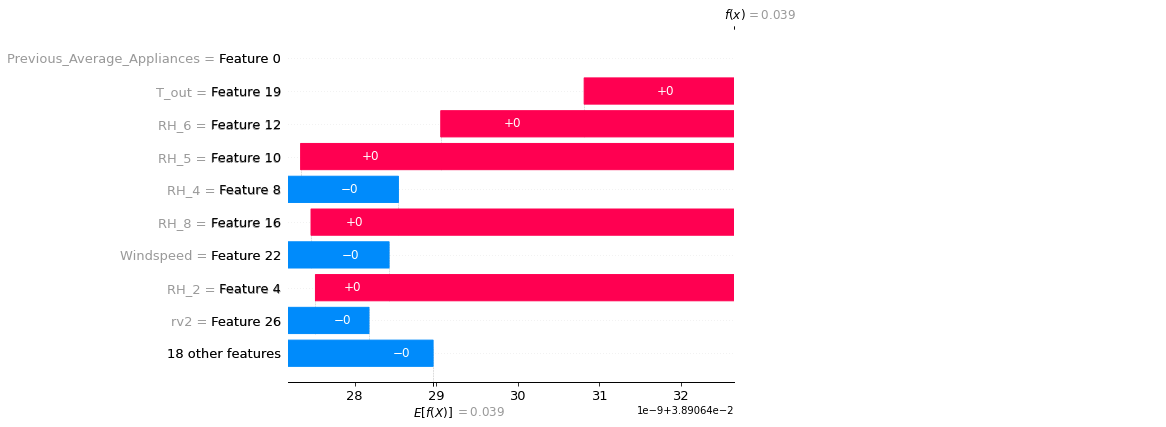

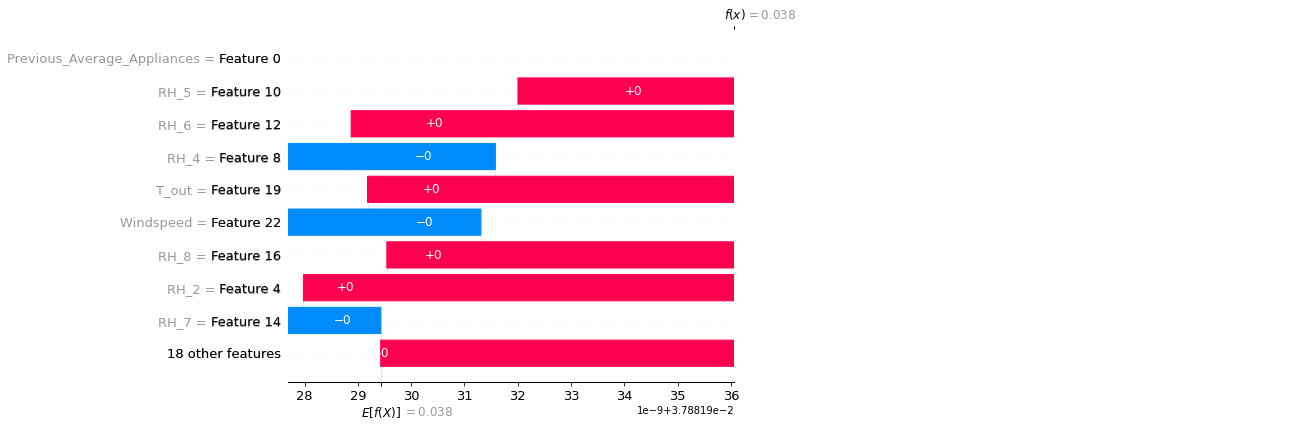

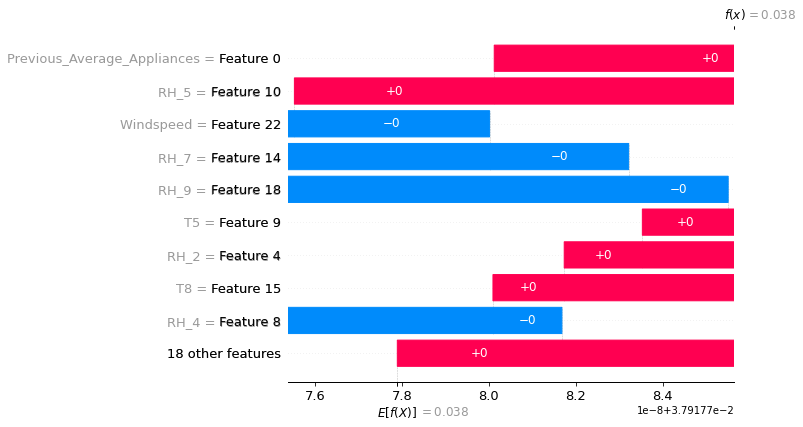

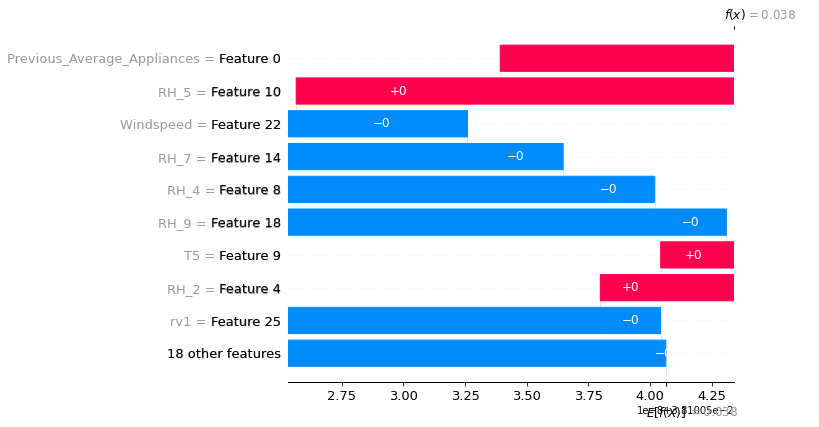

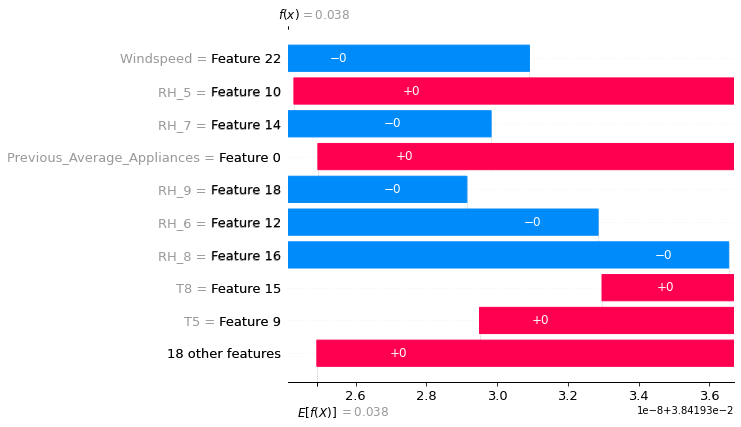

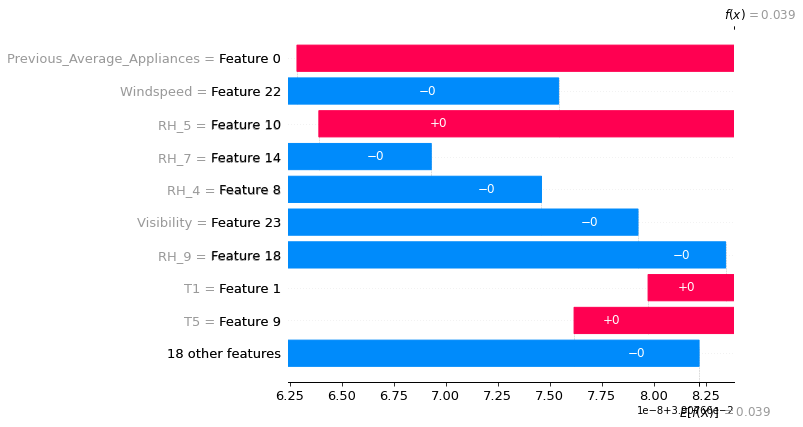

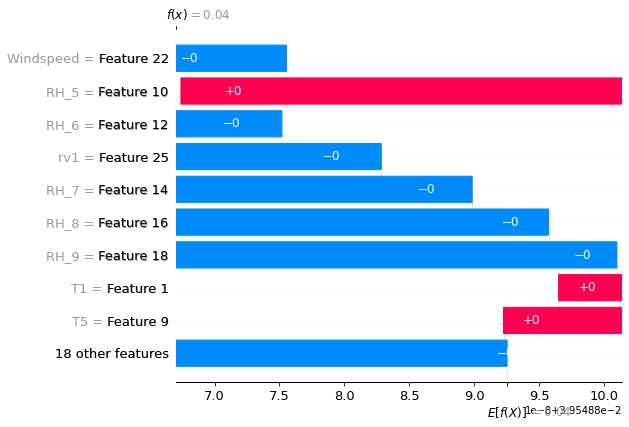

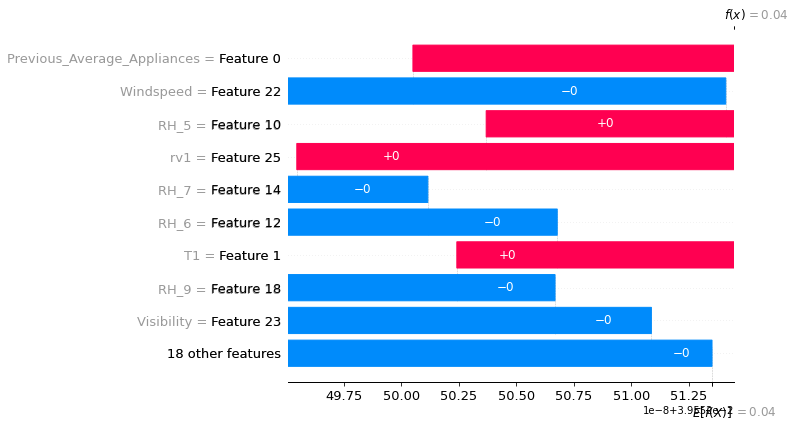

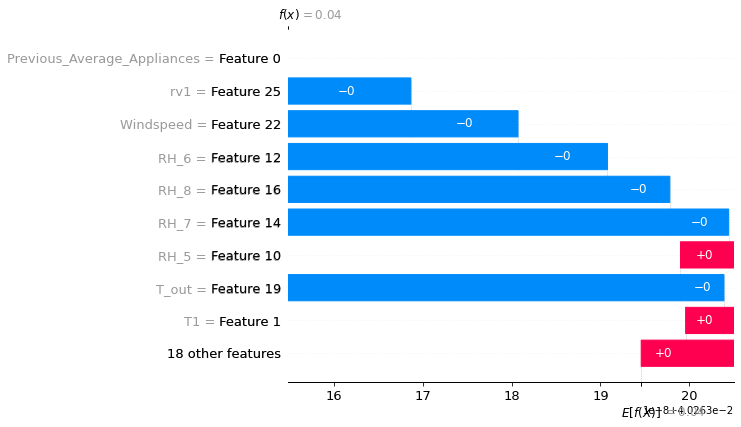

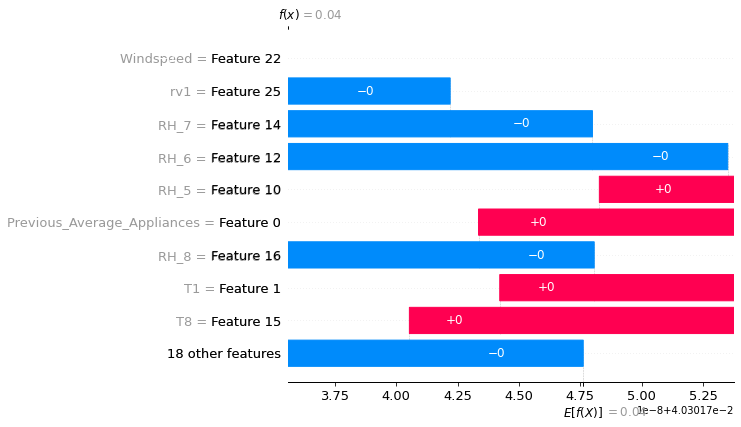

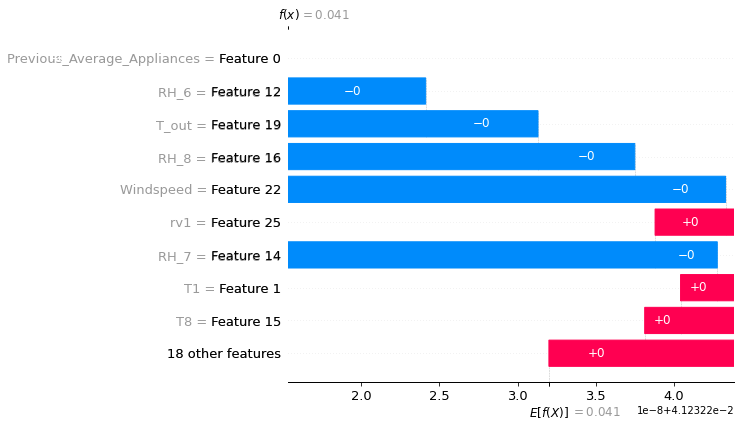

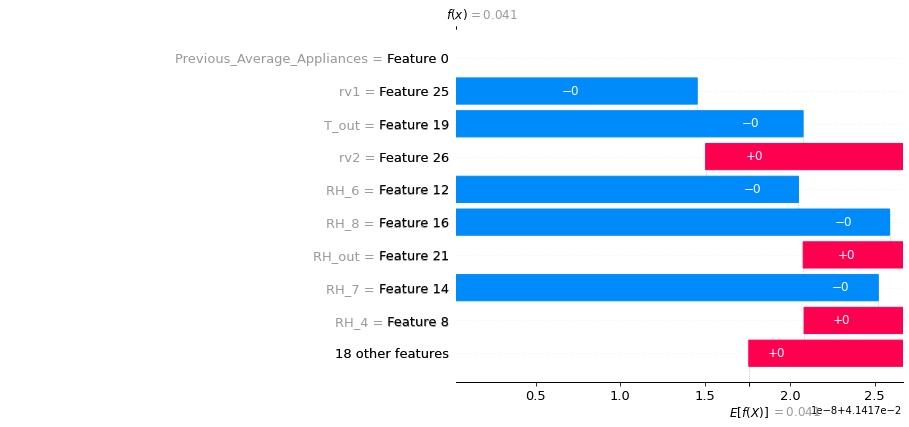

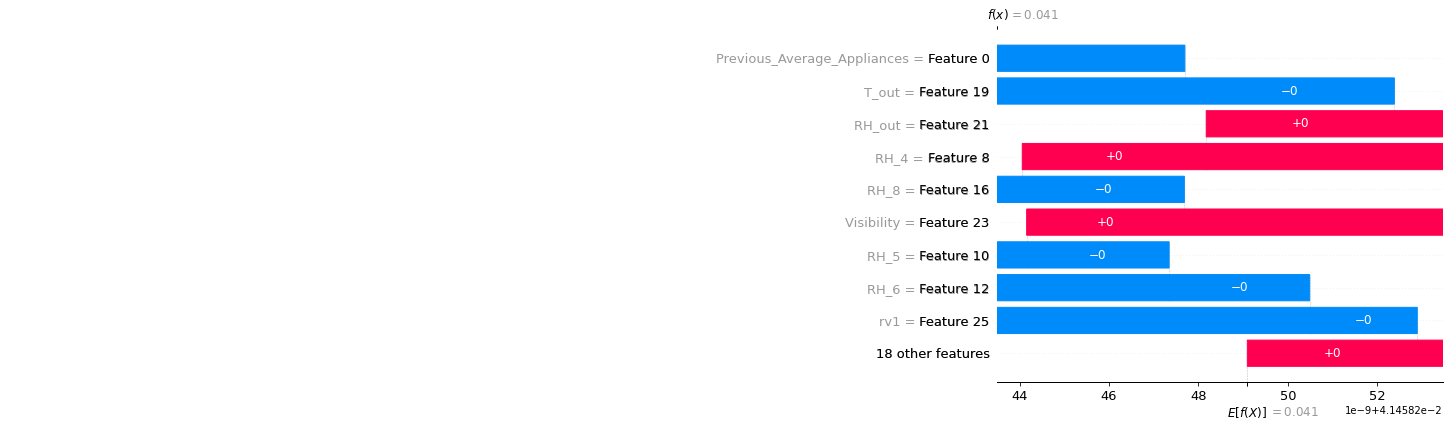

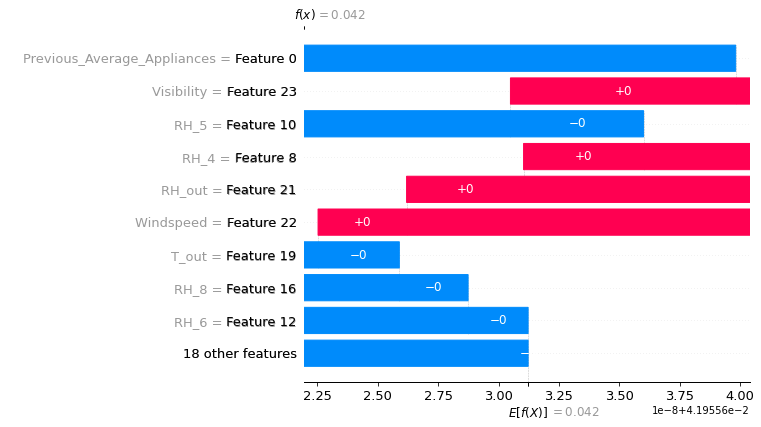

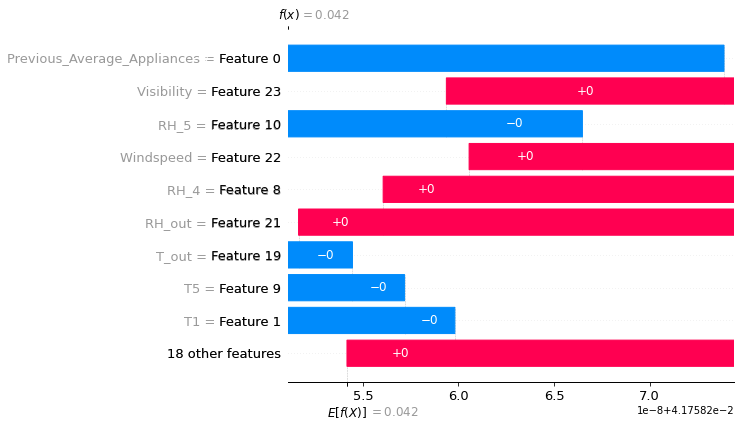

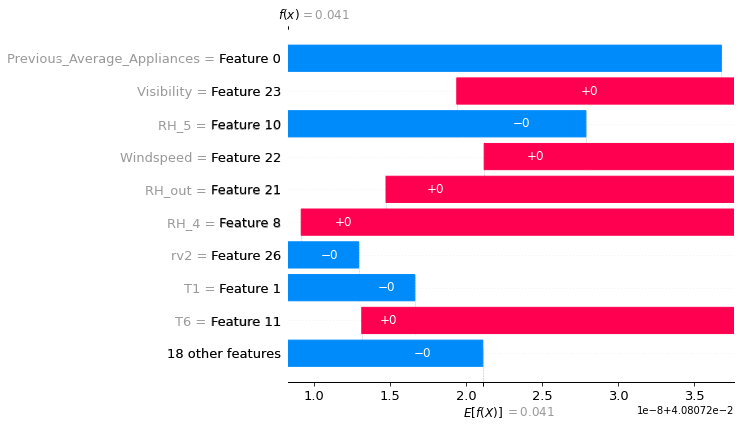

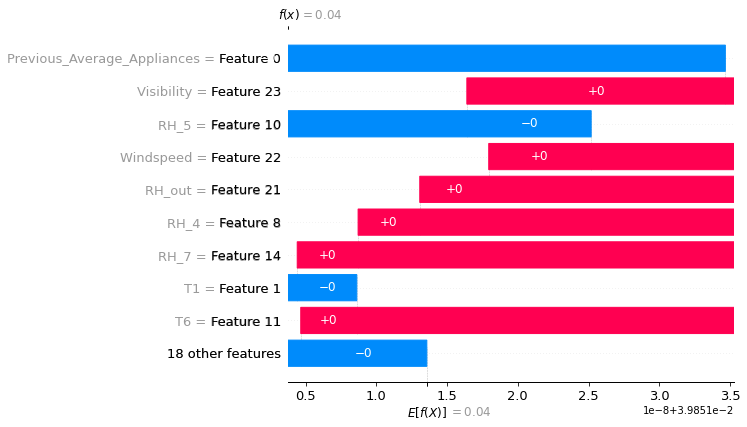

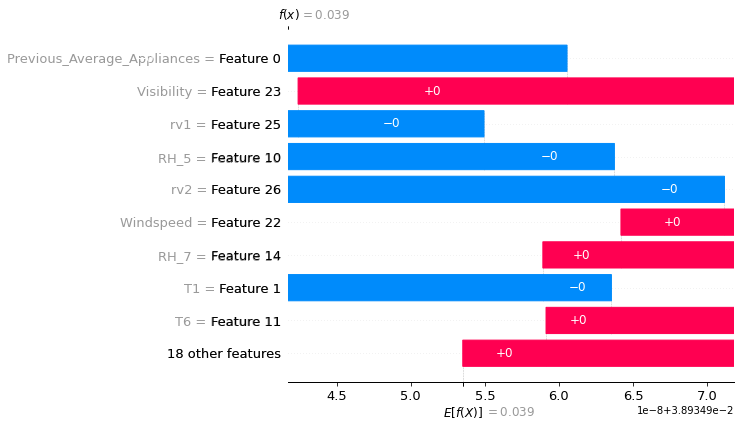

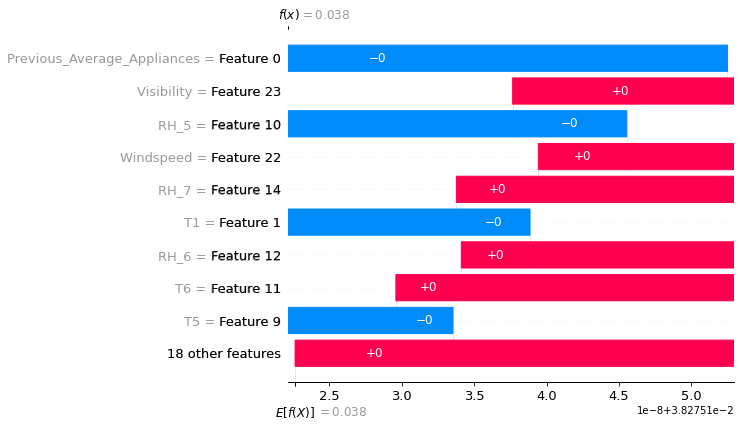

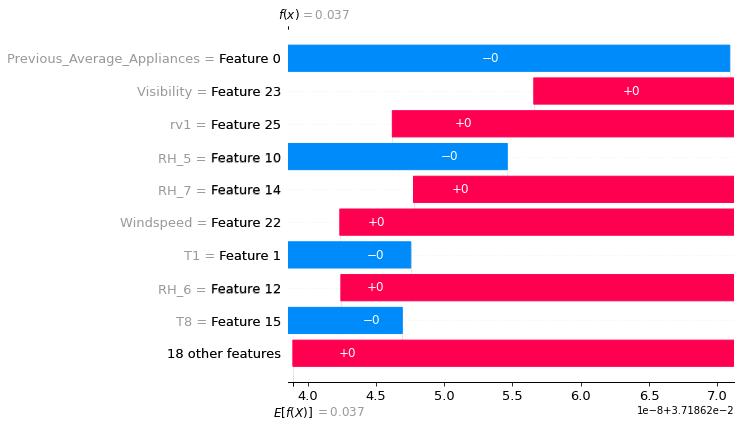

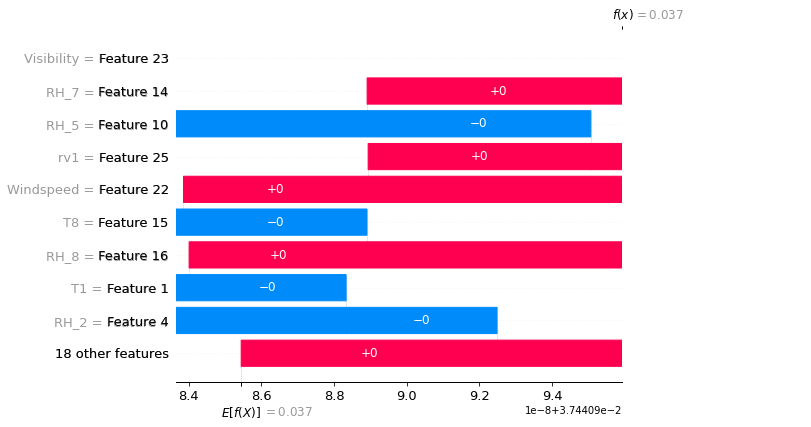

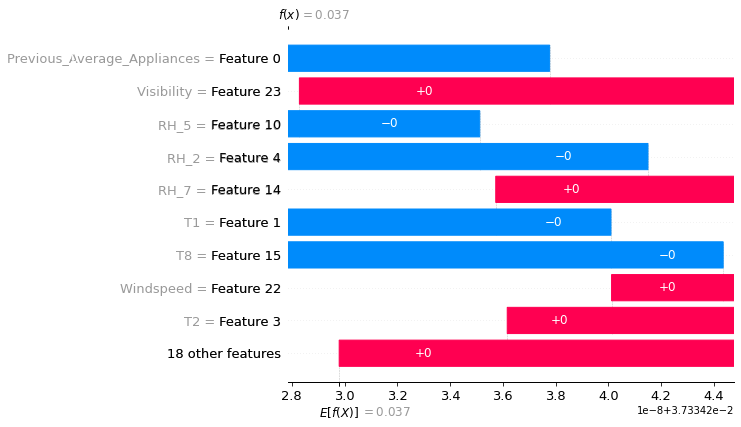

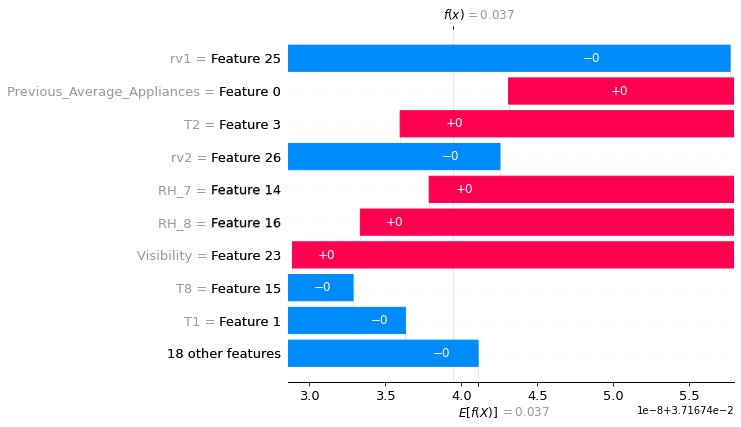

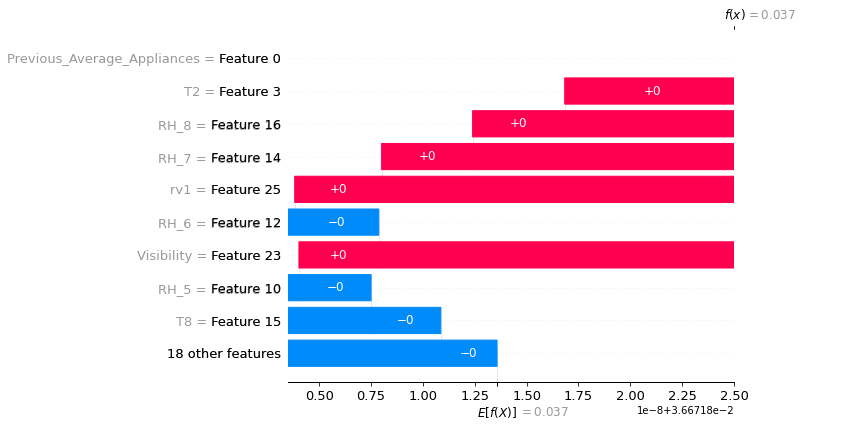

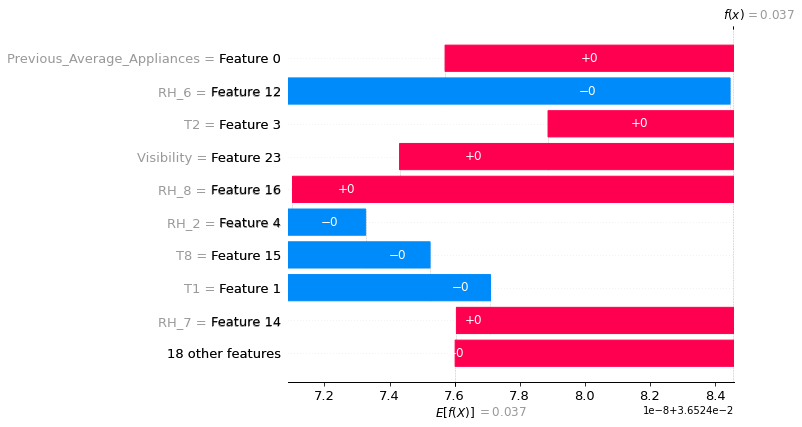

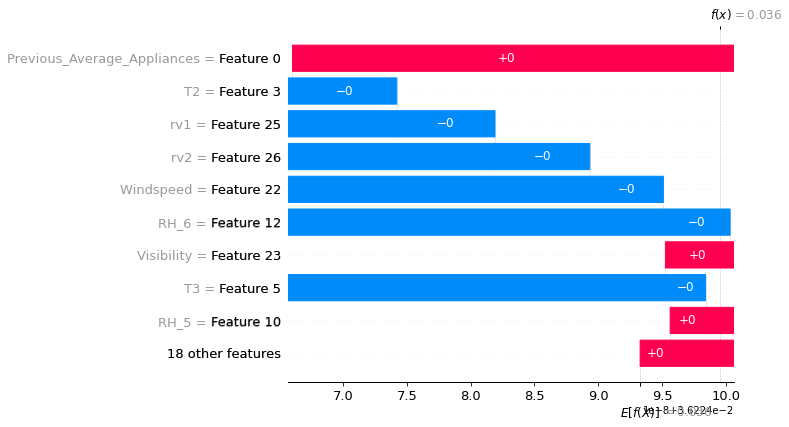

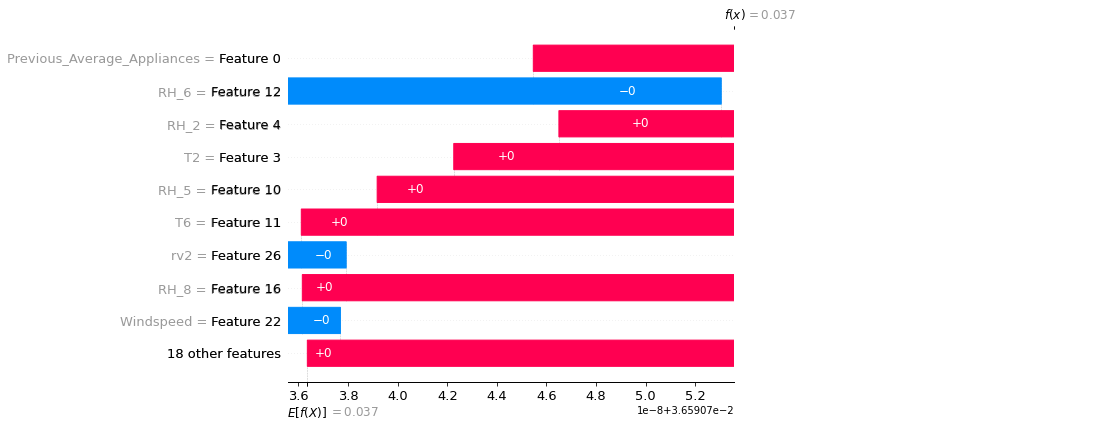

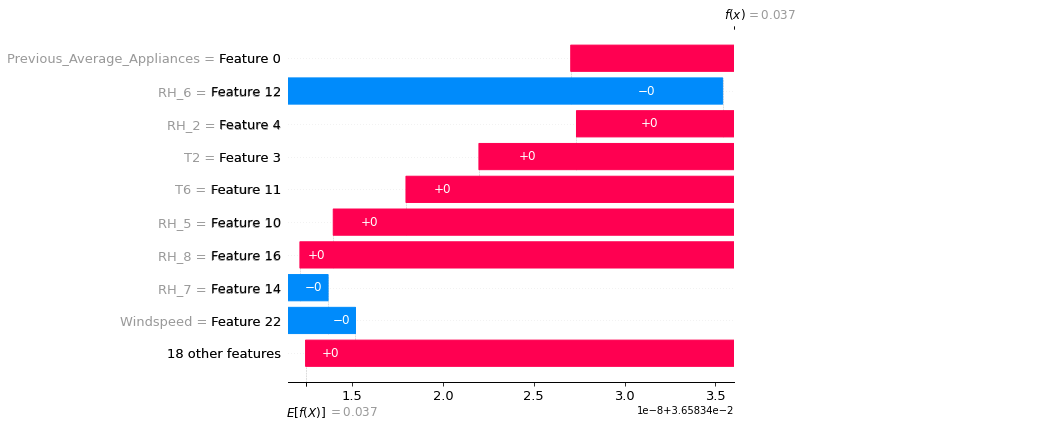

In [ ]:
for i in range(50):
  shap.plots._waterfall.waterfall_legacy(predictions[i].tolist()[0], new_shap_values[i], features)